In [1]:
#This script analyse the number of interactions between epitope and paratope.
#@Author: Henriette Capel
#@Date: 25-03-2022
#@Edited: Gemma Gordon April 2023

In [1]:
#Import modules
import Bio.PDB
from Bio.Data.IUPACData import protein_letters_3to1
from Bio.PDB.Polypeptide import standard_aa_names

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
#from ABDB import database as db
#from scalop.predict import assign
from collections import Counter

from statsmodels.stats.weightstats import ztest as ztest
import statistics

import re
import dabest
#%load_ext nb_black

In [2]:
plt.rcParams['figure.dpi'] = 1200

In [3]:
DISTANCE_CUTOFF = 4.5
dict_cdr_positions = {"CDRH1": [27,38], 
                     "CDRH2": [56,65],
                     "CDRH3": [105,117],
                     "CDRL1": [27,38], 
                     "CDRL2": [56,65],
                     "CDRL3": [105,117]}


In [4]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df

def determine_number_interactions(df, distance_cutoff):
    #Note: the paratope dictionaries of the full length domain are organised as: {"heavy_id" : ., "light_id": .}
    epitope_dicts_list = []
    paratope_dicts_list = []
    
    for index, row in df.iterrows():
        pdb_id = row['pdb']
        ag_chain = row['antigen_chain']
        ab_chain = row['antibody_chain']
        
        #epi_res_dict, para_res_dict = select_epitope_paratope_dict_from_df(row, ab_chain)
        epi_res_dict = row['epitope_MWV_dict'] #for full length this is a dictionary
        para_res_dict = row['paratope_MWV_dict'] #for full length this is a dictionary
        
        p = db.fetch(pdb_id)
        imgt_structure = p.get_structure(scheme="imgt", definition = 'imgt')
        
        #Epitope and Paratope
        if len(ab_chain) == 2:
            heavy_chain = ab_chain[0]
            light_chain = ab_chain[1]
            list_epitope_biopdb_residues = store_selected_residues(pdb_id, imgt_structure, ag_chain, epi_res_dict, full_length=True, vlvh_chain= ab_chain)
            list_paratope_biopdb_residues_heavy = store_selected_residues(pdb_id, imgt_structure, heavy_chain, para_res_dict, full_length=True)            
            list_paratope_biopdb_residues_light = store_selected_residues(pdb_id, imgt_structure, light_chain, para_res_dict, full_length=True)

            #Count interacting resdidues individualy for heavy and light chain
            dict_epitope_num_interactions_heavy, dict_paratope_num_interactions_heavy = determine_and_store_number_interactions(list_epitope_biopdb_residues, list_paratope_biopdb_residues_heavy, distance_cutoff)
            dict_epitope_num_interactions_light, dict_paratope_num_interactions_light = determine_and_store_number_interactions(list_epitope_biopdb_residues, list_paratope_biopdb_residues_light, distance_cutoff)
            
            #Combine epitope residue counts and store paratope residue counts seperately
            dict_epitope_num_interactions = combine_heavy_light_epitopes(dict_epitope_num_interactions_heavy, dict_epitope_num_interactions_light)
            dict_paratope_num_interactions= {heavy_chain: dict_paratope_num_interactions_heavy, light_chain: dict_paratope_num_interactions_light}
            
        else: #single domain
            list_epitope_biopdb_residues = store_selected_residues(pdb_id, imgt_structure, ag_chain, epi_res_dict)
            list_paratope_biopdb_residues = store_selected_residues(pdb_id, imgt_structure, ab_chain, para_res_dict)
            dict_epitope_num_interactions, dict_paratope_num_interactions = determine_and_store_number_interactions(list_epitope_biopdb_residues, list_paratope_biopdb_residues, distance_cutoff)
        
        epitope_dicts_list.append(dict_epitope_num_interactions)
        paratope_dicts_list.append(dict_paratope_num_interactions)
    
    df_interaction_info = df[['pdb', 'antigen_chain', 'antibody_chain', 'antigen_sequence', 'cdr_sequence']]
    df_interaction_info['epitope_num_interactions'] = epitope_dicts_list
    df_interaction_info['paratope_num_interactions'] = paratope_dicts_list
        
    return df_interaction_info
    
def combine_heavy_light_epitopes(dict_epitope_heavy, dict_epitope_light):
    counter_heavy = Counter(dict_epitope_heavy)
    counter_light = Counter(dict_epitope_light)
    dict_combined = dict(counter_heavy + counter_light)
    return dict_combined
    
def determine_and_store_number_interactions(list_res_epitope, list_res_paratope, distance_cutoff):    
    dict_epitope_num_interactions = {}
    dict_paratope_num_interactions = {}
    list_epitope_interactions = []
    
    atoms_epitope = Bio.PDB.Selection.unfold_entities(list_res_epitope, 'A') 
    #atoms_paratope = Bio.PDB.Selection.unfold_entities(list_res_paratope, 'A') 
    
    #Store the number of times every residue in epitope and paratope is interacting
    ns = Bio.PDB.NeighborSearch(atoms_epitope)
    for residue in list_res_paratope:
        residue_id = make_residue_id_from_biopdb(residue)
        temp_set_epi_per_res = set() #Needed otherwise we store number of interactions per atom instead of per amino acids
        for atom in residue:
            close_atoms = ns.search(atom.coord, distance_cutoff, level="R")
            if len(close_atoms) != 0: #The atom under consideration is interacting
                temp_set_epi_per_res.update(close_atoms)
        dict_paratope_num_interactions[residue_id] = len(temp_set_epi_per_res) #Store the number of amino acids to which the paratope residue under consideration is bound
        list_epitope_interactions = list_epitope_interactions + list(temp_set_epi_per_res) #add to list to count later
    
    #count number interactions per epitope residue
    occurence_epi_res_dict = Counter(list_epitope_interactions)
    for residue in occurence_epi_res_dict.keys():
        epi_residue_id = make_residue_id_from_biopdb(residue)
        dict_epitope_num_interactions[epi_residue_id] = occurence_epi_res_dict[residue]
    
    return dict_epitope_num_interactions, dict_paratope_num_interactions
        
    
def store_selected_residues(pdb_id, imgt_structure, selected_chain, selected_res_dict, full_length=False, vlvh_chain=False): #Note pdb_id later weerr uithalen
    #Loop through biopython structure, check for each residue of it belongs to the epitope of paratope residues (stored in selected_res_dict). If so, store.
    #vlvh_chain is only needed for determination of the epitope of the full length domain antibody
    
    list_selected_biopdb_residues = []
    
    if full_length: #Need to get elements from a nested dictionary
        if vlvh_chain: #Determination of the epitope of the full length antibody
            list_of_selected_res_num = make_residue_id_from_dfds(selected_res_dict[vlvh_chain])
        else: #Paratope of the full length antibody
            list_of_selected_res_num = make_residue_id_from_dfds(selected_res_dict[selected_chain])
    else:
        list_of_selected_res_num = make_residue_id_from_dfds(selected_res_dict)
    
    #Loop through whole biopython structure
    for model in imgt_structure:
        for chain_type in model:
            chain_type_id = chain_type.get_id()
            for chain in chain_type:
                chain_id = chain.get_id()
                if chain_id == selected_chain:
                    for residue in Bio.PDB.Selection.unfold_entities(chain, 'R'):
                        res_id = make_residue_id_from_biopdb(residue)
                        
                        #Store if it is one of the residues we are looking for   
                        if res_id in list_of_selected_res_num:  
                            list_selected_biopdb_residues.append(residue)

    return list_selected_biopdb_residues

def make_residue_id_from_dfds(dict_res_num_name):
    list_res_ids = []
    for residue_number in dict_res_num_name.keys():
        res_id = dict_res_num_name[residue_number] + "_" + str(residue_number)
        list_res_ids.append(res_id)
    return list_res_ids

def make_residue_id_from_biopdb(residue):
    #Input is residue in BIO PDB format
    res_name = residue.resname.strip()
    res_num = residue.get_id()[1]
    res_insertion_id = residue.get_id()[2]
    
    try:
        res_name_3code = res_name[0] + res_name[1:].lower()
        res_name_1code = Bio.Data.IUPACData.protein_letters_3to1[res_name_3code]
        if res_insertion_id == " ":
            res_id = res_name_1code + "_" + str(res_num)
        else:
            res_id = res_name_1code + "_" + str(res_num) + "_" + res_insertion_id
        
        return res_id
    
    except KeyError: #residues 1 code name can not be determined. We do not look into this one because we also havent stored these in our target list
        return None
    
    
def create_number_interactions_data(df_interaction_info):
    list_sum_interactions_per_complex = []
    list_sum_interactions_per_complex_heavy = []
    
    for index, row in df_interaction_info.iterrows():
        #Note: for full length nested dict        
        ab_chain = row['antibody_chain']
        is_full_length = (len(ab_chain) ==2) #Dealing with full length
        
        interaction_info_dict = row['paratope_num_interactions']
    
        if is_full_length:
            heavy_chain = ab_chain[0]
            light_chain = ab_chain[1]
            total_interactions = sum(interaction_info_dict[heavy_chain].values()) + sum(interaction_info_dict[light_chain].values())
        
            #Also save for full length antibodies the number of interactions for heavy chain only
            total_interactions_heavy = sum(interaction_info_dict[heavy_chain].values())
            list_sum_interactions_per_complex_heavy.append(total_interactions_heavy)
        else:
            total_interactions = sum(interaction_info_dict.values())
        list_sum_interactions_per_complex.append(total_interactions) 
    
    df_interaction_info['sum_interactions'] = list_sum_interactions_per_complex
    if is_full_length:
        df_interaction_info['sum_interactions_heavy'] = list_sum_interactions_per_complex_heavy
        

    return df_interaction_info

#####
#Extra columns with normalised or specific interaction information
def perform_extra_calculations(df_interactions_info, dict_cdr_positions, is_full_length=False):
    #This function calls other functions to normalise the number of interactions by; CDR length, epitope, paratope, and to determine number and proportion of cdr residues in paratope
    
    #Normalise number of interactions
    df_interactions_info = normalise_num_interaction(df_interactions_info, 'CDRH')
    if is_full_length:
        df_interactions_info = normalise_num_interaction(df_interactions_info, 'CDRHL')
    df_interactions_info = normalise_num_interaction_by_epitope(df_interactions_info)
    df_interactions_info = normalise_num_interaction_by_paratope(df_interactions_info)
    
    #Number of cdr residues in paratope
    if is_full_length:
        df_interactions_info = determine_number_cdr_aa_in_paratope(df_interactions_info, dict_cdr_positions, ["CDRH1", "CDRH2", "CDRH3", "CDRL1", "CDRL2", "CDRL3"], is_full_length)
    else:
        df_interactions_info = determine_number_cdr_aa_in_paratope(df_interactions_info, dict_cdr_positions, ["CDRH1", "CDRH2", "CDRH3"])
    
    #proportion of cdr residues in paratope
    df_interactions_info = proportion_allcdrs_in_paratope(df_interactions_info, is_full_length)

    return df_interactions_info


def normalise_num_interaction(df_interaction_info, cdr_type):
    #Normalise by the length of the CDR
    list_normalised_number_interaction = []
    for index, row in df_interaction_info.iterrows():
        cdr_dict = row['cdr_sequence']
        cdr_length = len(cdr_dict[cdr_type])
        num_interactions = row['sum_interactions']
        
        list_normalised_number_interaction.append(num_interactions/cdr_length)
    
    df_interaction_info[f"normalised_interactions_per_{cdr_type}_length"] = list_normalised_number_interaction

    return df_interaction_info

def normalise_num_interaction_by_epitope(df_interaction_info):
    #Function to normalise the number of interactions in the complex by the epitope length
    list_normalised_interactions = []
    for index, row in df_interaction_info.iterrows():
        epitope_dict = row['epitope_num_interactions']
        length_epitope = len(epitope_dict.keys())
        num_interactions = row['sum_interactions']
        
        list_normalised_interactions.append(num_interactions/length_epitope)
    
    df_interaction_info[f"normalised_interactions_by_epitope_length"] = list_normalised_interactions

    return df_interaction_info

def normalise_num_interaction_by_paratope(df_interaction_info):
    #Function to normalise the number of interactions by the paratope length. Note paratope of full length is save as {"heavy_chain": {}, "light_chain":{}}
    list_normalised_interactions = []
    list_normalised_interactions_heavy = []
    for index, row in df_interaction_info.iterrows():
        paratope_dict = row['paratope_num_interactions']
        
        is_full_length = (len(row['antibody_chain']) == 2)
        if is_full_length:
            length_paratope = 0
            for chain in paratope_dict.keys():
                length_paratope += len(paratope_dict[chain].keys())
                
            #Save also for paratope on heavy chain
            length_paratope_heavy = len(paratope_dict[row['antibody_chain'][0]].keys())
            num_int_heavy = row['sum_interactions_heavy']
            try:
                list_normalised_interactions_heavy.append(num_int_heavy/length_paratope_heavy)
            except ZeroDivisionError:
                list_normalised_interactions_heavy.append(0.0)
        else:
            length_paratope = len(paratope_dict.keys())
        num_interactions = row['sum_interactions']
        
        list_normalised_interactions.append(num_interactions/length_paratope)
    
    df_interaction_info[f"normalised_interactions_by_paratope_length"] = list_normalised_interactions
    
    if is_full_length:
        df_interaction_info[f"normalised_interactions_by_paratope_length_heavy"] = list_normalised_interactions_heavy
            
    return df_interaction_info

def determine_number_cdr_aa_in_paratope(df_info, dict_cdr_positions, cdr_interested, is_full_length =False):
    #this function determines the number of residues that belong to the cdr and are in the paratope.
    
    #Determine the interested positions for the heavy and light chain. Note this was not necesairy because the IMGT numbers are the same
    interested_positions = {"heavy": set(), "light": set()}
    for cdr in cdr_interested:
        start = dict_cdr_positions[cdr][0]
        stop = dict_cdr_positions[cdr][1]
        if cdr[3] == "H":
            interested_positions["heavy"].update(list(range(start,stop+1)))
        else:
            interested_positions["light"].update(list(range(start,stop+1)))
            
    #Set up empty lists
    list_number_positions_heavy = []
    list_number_interactions_heavy = []
    list_number_positions_light = []
    list_number_interactions_light = []
    
    #Determine the number of residues and the number of interactions made (by calling "count_found_residues")
    for dict_info in df_info['paratope_num_interactions'].tolist():
        if is_full_length: #Do seperately for heavy and light chain
            count_num_heavy, count_inter_heavy = count_found_residues(dict_info[list(dict_info.keys())[0]], interested_positions["heavy"])
            #Add to lists later because also needs to be done for single domain
            
            #Light chain; note can add to list directly
            count_num_light, count_inter_light = count_found_residues(dict_info[list(dict_info.keys())[1]], interested_positions["light"])
            list_number_positions_light.append(count_num_light)
            list_number_interactions_light.append(count_inter_light)
        else: #Single domain antibody
            count_num_heavy, count_inter_heavy = count_found_residues(dict_info, interested_positions["heavy"])
            
        list_number_positions_heavy.append(count_num_heavy)
        list_number_interactions_heavy.append(count_inter_heavy)

    #Save info as column in dataframe
    df_info["number_cdr_heavy_aa_in_paratope"] = list_number_positions_heavy
    df_info["number_cdr_heavy_interactions_in_paratope"] = list_number_interactions_heavy
    if is_full_length: #store also light chain info
        df_info["number_cdr_light_aa_in_paratope"] = list_number_positions_light
        df_info["number_cdr_light_interactions_in_paratope"] = list_number_interactions_light
    
    return df_info

def count_found_residues(dict_res_interaction, interested_positions):
    #Look up if the interaction residues are cdr residues. Used in "determine_number_cdr_aa_in_paratope"
    count = 0
    count_inter = 0
    for residue_id in dict_res_interaction.keys():
        res_num = int(residue_id.split("_")[1])
        if res_num in interested_positions:
            count += 1
            count_inter += dict_res_interaction[residue_id]
    return count, count_inter

def proportion_allcdrs_in_paratope(df_info, is_full_length = False):
    # This function determines the proportion of the cdr residues that are in the paratope. Do this both for the real number of residues present (length proportion) and the number of interactions they make (interaction proportion)
    
    ##Length proportion
    length_paratope_list = []
    length_paratope_list_heavy_fv = []
    
    if is_full_length:
        number_cdr_aa_list = df_info["number_cdr_heavy_aa_in_paratope"] + df_info["number_cdr_light_aa_in_paratope"]
        number_cdr_aa_list_heavy_fv = df_info["number_cdr_heavy_aa_in_paratope"]
    else:
        number_cdr_aa_list = df_info["number_cdr_heavy_aa_in_paratope"]
        
    for dict_para in df_info["paratope_num_interactions"].tolist():
        if is_full_length:
            length_paratope_list.append(sum(len(v) for v in dict_para.values())) #Nested dictionary
            length_paratope_list_heavy_fv.append(len(dict_para[list(dict_para.keys())[0]].values())) #Select heavy (first) chain
        else:
            length_paratope_list.append(len(dict_para.values()))
            
    df_info["length_proportion_all_cdrs_in_paratope"] = number_cdr_aa_list/length_paratope_list
    df_info["paratope_length"] = length_paratope_list
    
    if is_full_length: #Also save only for heavy chain
        df_info["length_proportion_cdrhs_in_paratope_heavy"] = number_cdr_aa_list_heavy_fv/length_paratope_list_heavy_fv
        df_info["paratope_length_heavy"] = length_paratope_list_heavy_fv
    
    ##interaction proportion
    if is_full_length:
        number_cdr_interaction_list = df_info["number_cdr_heavy_interactions_in_paratope"] + df_info["number_cdr_light_interactions_in_paratope"]
        number_cdr_interaction_list_heavy_fv = df_info["number_cdr_heavy_interactions_in_paratope"]
        assert len(number_cdr_interaction_list) == len(number_cdr_interaction_list_heavy_fv)
    else:
        number_cdr_interaction_list = df_info["number_cdr_heavy_interactions_in_paratope"]
    
    #Save the number of all cdr residues in the whole paratope
    df_info["interaction_proportion_all_cdrs_in_paratope"] = number_cdr_interaction_list/df_info["sum_interactions"]
    if is_full_length: 
        #Save the number of cdr residues in heavy chain in the paratope of the heavy chain
        df_info["interaction_proportion_cdrhs_in_paratope_heavy"] = number_cdr_interaction_list_heavy_fv/df_info["sum_interactions_heavy"]
    
    return df_info


#######
def evaluate_distributions_per_cdr(df_interaction_info_nb, df_interaction_info_fv, dict_cdr_positions, cdr_type, label1 = "Single domain Abs", label2 = "full length Abs", color1= 'royalblue', color2 = 'lightcoral'):
    df_sum_nb = sum_interactions_per_cdr(df_interaction_info_nb, dict_cdr_positions, cdr_type)
    df_sum_fv = sum_interactions_per_cdr(df_interaction_info_fv, dict_cdr_positions, cdr_type)
    df_interactions_cdr_normalised_cdrlength_nb = normalise_interactions_per_cdr_by_cdrlength(df_sum_nb, cdr_type)
    df_interactions_cdr_normalised_cdrlength_fv = normalise_interactions_per_cdr_by_cdrlength(df_sum_fv, cdr_type)
    df_all_nb = proportion_cdr_in_paratope(df_sum_nb, cdr_type)
    df_all_fv = proportion_cdr_in_paratope(df_sum_fv, cdr_type)

    plot_distribution(df_sum_nb, df_sum_fv, f"sum_interactions_{cdr_type}", f"sum_interactions_{cdr_type}", 1.0, label1, label2, color1, color2, f'Distribution interactions {cdr_type}')
    plot_distribution(df_interactions_cdr_normalised_cdrlength_nb, df_interactions_cdr_normalised_cdrlength_fv, f"normalised_interactions_{cdr_type}", f"normalised_interactions_{cdr_type}", 0.2, label1, label2, color1, color2, f"Normalised distribution interactions {cdr_type} by its length", "Normalised number of interactions")
    
    plot_distribution(df_all_nb, df_all_fv, f"length_fraction_{cdr_type}_in_paratope", f"length_fraction_{cdr_type}_in_heavy_paratope", 0.05, label1, label2, color1, color2, f"Lenght proportion {cdr_type} in heavy paratope", f"Proportion of total {cdr_type} residues in heavy paratope")
    plot_distribution(df_all_nb, df_all_fv, f"length_fraction_{cdr_type}_in_paratope", f"length_fraction_{cdr_type}_in_paratope", 0.05, label1, label2, color1, color2, f"Lenght proportion {cdr_type} in paratope", f"Proportion of total {cdr_type} residues in paratope")

    plot_distribution(df_all_nb, df_all_fv, f"interaction_fraction_{cdr_type}_in_paratope", f"interaction_fraction_{cdr_type}_in_heavy_paratope", 0.05, label1, label2, color1, color2, f"Interaction proportion {cdr_type} in heavy paratope", f"Proportion of total interactions of {cdr_type} residues in heavy paratope")
    plot_distribution(df_all_nb, df_all_fv, f"interaction_fraction_{cdr_type}_in_paratope", f"interaction_fraction_{cdr_type}_in_paratope", 0.05, label1, label2, color1, color2, f"Interaction proportion {cdr_type} in paratope", f"Proportion of total interactions of {cdr_type} residues in paratope")

    return df_all_nb, df_all_fv


def sum_interactions_per_cdr(df_interaction_info, dict_cdr_positions, cdr_type):
    #Function to determine the number of interactions per cdr region. 
    #Note this function does only work for heavy chain CDR
    
    #Warning if light chain is considered
    if cdr_type[3] == "L":
        print(f"WARNING; you are asking for the CDR on the light chain, but inside this function the heavy chain is selected. Consider studying the heavy chain, or change code to light chain.")
    
    #Make list of all the IMGT positions belonging to the CDR
    min_position = dict_cdr_positions[cdr_type][0]
    max_position = dict_cdr_positions[cdr_type][1]
    cdrh_numbers = list(range(min_position, max_position+1))
    
    #Set up empty lists
    list_sum_interaction_cdr = []
    list_cdr_in_para = []
    
    #make a list of the paratope dictionaries. For the full length antibody, select only the heavy chain
    list_dicts_paratope_num_interactions = store_info_paratope_interactions_list(df_interaction_info)
    
    #determine how many interactions and how many cdr residues in paratope
    for dict_paratope_num_interactions in list_dicts_paratope_num_interactions:
        sum_region = 0
        num_cdr_aa_in_paratope = 0
        for residue_id in dict_paratope_num_interactions.keys():
            res_num = int(residue_id.split("_")[1])
            if int(res_num) in cdrh_numbers:
                sum_region += dict_paratope_num_interactions[residue_id]
                num_cdr_aa_in_paratope += 1
        
        #Store complex info in dataframe
        list_sum_interaction_cdr.append(sum_region)
        list_cdr_in_para.append(num_cdr_aa_in_paratope)
    
    #Store new info in dataframe
    df_interaction_info[f"sum_interactions_{cdr_type}"] = list_sum_interaction_cdr
    df_interaction_info[f"num_{cdr_type}_aa_in_paratope"] = list_cdr_in_para
    
    return df_interaction_info

def normalise_interactions_per_cdr_by_cdrlength(df_info, cdr_type):
    df_info[f'normalised_interactions_{cdr_type}'] = df_info[f'sum_interactions_{cdr_type}'] / determine_length_cdr(df_info, cdr_type)
    return df_info

def determine_length_cdr(df_info, cdr_type):
    list_length_cdr = []
    for dict_cdrs in list(df_info['cdr_sequence']):
        list_length_cdr.append(len(dict_cdrs[cdr_type]))
    return list_length_cdr       

def proportion_cdr_in_paratope(df, cdr_type):
    #Determine the proportion (both length and interaction) of the CDR in paratope
    #Note: for full length the length_fraction is divided by the length of the paratope of the HEAVY chain
    #Note: for the interaction fraction in flabs it is divided by the number of interactions in the heavy chain. 
    
    # list_dicts_paratope_num_interactions = store_info_paratope_interactions_list(df)
    # list_length_paratope = [len(listElem) for listElem in list_dicts_paratope_num_interactions]
    try: 
        df[f"length_fraction_{cdr_type}_in_heavy_paratope"] = df[f"num_{cdr_type}_aa_in_paratope"]/df["paratope_length_heavy"]
        df[f"length_fraction_{cdr_type}_in_paratope"] = df[f"num_{cdr_type}_aa_in_paratope"]/df["paratope_length"]
        df[f"interaction_fraction_{cdr_type}_in_heavy_paratope"] = df[f"sum_interactions_{cdr_type}"]/df["sum_interactions_heavy"]
        df[f"interaction_fraction_{cdr_type}_in_paratope"] = df[f"sum_interactions_{cdr_type}"]/df["sum_interactions"]
    except KeyError: #Fails in case of a single domain antibody because "paratope_length_heavy" does not exist
        df[f"length_fraction_{cdr_type}_in_paratope"] = df[f"num_{cdr_type}_aa_in_paratope"]/df["paratope_length"]
        df[f"interaction_fraction_{cdr_type}_in_paratope"] = df[f"sum_interactions_{cdr_type}"]/df["sum_interactions"]

    return df

def store_info_paratope_interactions_list(df):
    #make a list containing all the paratope_num_interaction dictionaries. For full length antibodies store only the positions of the heavy chain. 
    
    is_full_length = (len(df['antibody_chain'][0]) == 2) #Check if full length
    if is_full_length:
        list_dicts_info = []
        dicts_both_chain = list(df['paratope_num_interactions'])
        for nested_dict in dicts_both_chain:
            heavy_chain = list(nested_dict.keys())[0]
            list_dicts_info.append(nested_dict[heavy_chain]) #Store the positions of the heavy chain
    else:
        list_dicts_info = list(df['paratope_num_interactions'])
    
    return list_dicts_info

def store_interactions_per_position(df_interaction_info, min_position, max_position):
    cdrh_numbers = list(range(min_position, max_position+1))
    dict_position_interactions = {}
    
    #Set up dictionary with imgt_positions as key and empty lists as values
    for imgt_position in cdrh_numbers:
        dict_position_interactions[imgt_position] = []
        
    list_dicts_paratope_num_interactions = store_info_paratope_interactions_list(df_interaction_info)

    for dict_info in list_dicts_paratope_num_interactions:
        for imgt_position in dict_position_interactions.keys():
            found = False
            for res_id in dict_info.keys():
                position = int(res_id.split("_")[1])
                if imgt_position == position:
                    found = True
            if found == True:
                dict_position_interactions[imgt_position].append(dict_info[res_id]) #store the number of interactions for this position
            else: 
                dict_position_interactions[imgt_position].append(0) #the position is not interacting
                
    df_interactions_per_position = pd.DataFrame.from_dict(dict_position_interactions)
    
    return df_interactions_per_position

def perform_bootstrap(n_sample, interaction_sizes):
    df = pd.DataFrame([np.random.choice(interaction_sizes[k],n_sample,replace=False) for k in interaction_sizes]).T
    df.columns = [k for k in interaction_sizes]
    x = dabest.load(df, idx=(list(interaction_sizes.keys())[0],list(interaction_sizes.keys())[1]))
    print(x.mean_diff)

###Plotting
def plot_distribution(df_input1: pd.DataFrame, df_input2: pd.DataFrame, column_name1: str, column_name2: str, binwidth, label1: str, label2: str, color1: str, color2: str, title = False, xlabel = "Number of interactions", grid = False):
    data_input1 = df_input1[column_name1]
    data_input2 = df_input2[column_name2]
    
    digits = 2
    
    #perform statistical tests
    print(ztest(data_input1, data_input2))
    perform_bootstrap(300, {'sdab': data_input1, 'flab': data_input2})
    
    mean_1 = round(data_input1.mean(),digits)
    median_1 = round(data_input1.median(),digits)
    std_1 = round(data_input1.std(),digits)
    mean_2 = round(data_input2.mean(),digits)
    median_2 = round(data_input2.median(),digits)
    std_2 = round(data_input2.std(),digits)
    
    max_length = max([max(data_input1), max(data_input2)])
    
    #Here
    plt.hist(data_input1, alpha=0.7, bins = np.arange(0.0, max_length+binwidth, binwidth), label= f"{label1}", color = color1, weights=np.zeros_like(data_input1) + 1. / data_input1.size, stacked = True)
    plt.hist(data_input2, alpha=0.7, bins = np.arange(0.0, max_length+binwidth, binwidth), label= f"{label2}", color = color2, weights=np.zeros_like(data_input2) + 1. / data_input2.size, stacked = True)

    #plt.title(f"Normalised number of interactions")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Normalised frequency", fontsize=12)
    if title:
        plt.title(title)
    if grid:
        plt.grid(axis = 'y')
    #plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.legend(fontsize = 12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    # plt.savefig(f'distribution_{title}.png', bbox_inches='tight')

def plot_distribution_per_position(df_interactions_per_position_nb, df_interactions_per_position_fv, binwidth, label1, label2, color1, color2):
    for position in list(df_interactions_per_position_nb.columns):
        data_input1 = df_interactions_per_position_nb[position]
        data_input2 = df_interactions_per_position_fv[position]

        plt.hist(data_input1, alpha=0.7, bins = np.arange(0.0, max_length+binwidth, binwidth), label= label1, color = color1, weights=np.zeros_like(data_input1) + 1. / data_input1.size, stacked = True)
        plt.hist(data_input2, alpha=0.7, bins = np.arange(0.0, max_length+binwidth, binwidth), label= label2, color = color2, weights=np.zeros_like(data_input2) + 1. / data_input2.size, stacked = True)
        
        plt.title(f"IMGT positon {position}")
        plt.xlabel("Number of interactions")
        plt.ylabel("Normalised frequency")
        plt.legend()
        plt.show()
        
###Functions needed for arpeggio output
def prepare_df_arpeggio_output(df_ds_my_interactions, df_ds_arpeggio_interactions, is_full_length=False):
    #This function selects the interesting columns of the arpeggio output and adds the antigen sequence and cdr sequence to the dataframe (found by matching to "df_ds_my_interactions")
    #Note: For a fair comparison we use the interactions determined by arpeggio for which the hetero atoms are removed. So, "df_ds_arpeggio_interactions" should be the result of the notebook "interaction_residues_arpeggio". 
    
    columns_to_select = ["pdb","antigen_chain","antibody_chain", "epitope_num_interactions", "paratope_num_interactions"]
    df_selected = df_ds_arpeggio_interactions[columns_to_select]
    
    #Add the antigen_sequence and cdr_sequence info
    df_ds_my_interactions_extra_info = df_ds_my_interactions[["pdb","antigen_chain","antibody_chain", "antigen_sequence", "cdr_sequence"]]
    df_result = pd.merge(df_selected, df_ds_my_interactions_extra_info, on=["pdb","antigen_chain","antibody_chain"])
    
    #Need to create "sum_interactions". Easiest based on epitope
    sum_interactions = []
    for index,row in df_result.iterrows():
        sum_interactions.append(sum(row["epitope_num_interactions"].values()))
    df_result["sum_interactions"] = sum_interactions
    
    if is_full_length:
        sum_interactions_heavy = []
        for index,row in df_result.iterrows():
            sum_interactions_heavy.append(sum(row["paratope_num_interactions"][row["antibody_chain"][0]].values()))
        df_result["sum_interactions_heavy"] = sum_interactions_heavy
    
    return df_result



In [5]:
#Single domain antibodies
ds_name_nb = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_filtered.csv"
df_nb = read_dataset(ds_name_nb)

#Determine interactions 
# df_interaction_info_nb = determine_number_interactions(df_nb, DISTANCE_CUTOFF)
# df_sum_interactions_per_complex_nb = create_number_interactions_data(df_interaction_info_nb)

In [6]:
#Full length antibodies
ds_name_fv = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_filtered.csv"
df_fv = read_dataset(ds_name_fv)

#Determine interactions
# df_interaction_info_fv = determine_number_interactions(df_fv, DISTANCE_CUTOFF)
# df_sum_interactions_per_complex_fv = create_number_interactions_data(df_interaction_info_fv)

In [44]:
# ## #Save df number interactions
#df_interaction_info_nb.to_csv("Dataset_nb_filtered_num_interactions.csv", index=False)
#df_interaction_info_fv.to_csv("Dataset_fv_filtered_num_interactions.csv", index=False)

In [45]:
########### Load data if already stored before

In [7]:
#Load interaction dataframes (instead of running again)
df_interaction_info_nb = read_dataset("/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_filtered_num_interactions.csv")
df_sum_interactions_per_complex_nb = create_number_interactions_data(df_interaction_info_nb)

df_interaction_info_fv = read_dataset("/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_filtered_num_interactions.csv")
df_sum_interactions_per_complex_fv = create_number_interactions_data(df_interaction_info_fv)

In [47]:
########PLOT

(-4.840525457914032, 1.294962649287634e-06)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:18 2022.

The unpaired mean difference between sdab and flab is 3.66 [95%CI 1.6, 5.82].
The p-value of the two-sided permutation t-test is 0.001. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


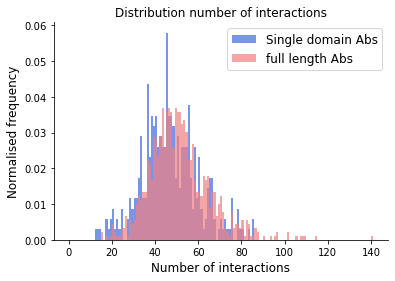

(14.647726474689353, 1.3929932468273807e-48)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:21 2022.

The unpaired mean difference between sdab and flab is -13.1 [95%CI -15.2, -10.9].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


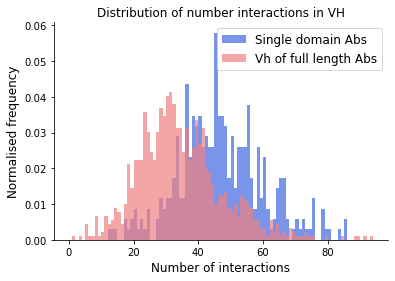

In [48]:
#Plot single domain vs full length
plot_distribution(df_sum_interactions_per_complex_nb, df_sum_interactions_per_complex_fv, "sum_interactions", "sum_interactions", 1.0, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Distribution number of interactions')

#Plot heavy only
plot_distribution(df_sum_interactions_per_complex_nb, df_sum_interactions_per_complex_fv, "sum_interactions", "sum_interactions_heavy", 1.0, "Single domain Abs", "Vh of full length Abs", 'royalblue', 'lightcoral', 'Distribution of number interactions in VH')


In [8]:
##Extend datasets with information about normalised interactions and fraction of CDR interactions
# Single domain
df_summary_interaction_nb = perform_extra_calculations(df_sum_interactions_per_complex_nb, dict_cdr_positions, is_full_length=False)

# Full length
df_summary_interaction_fv = perform_extra_calculations(df_sum_interactions_per_complex_fv, dict_cdr_positions, is_full_length=True)

(19.422360837492214, 4.994052038879611e-84)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:24 2022.

The unpaired mean difference between sdab and flab is -0.483 [95%CI -0.553, -0.414].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


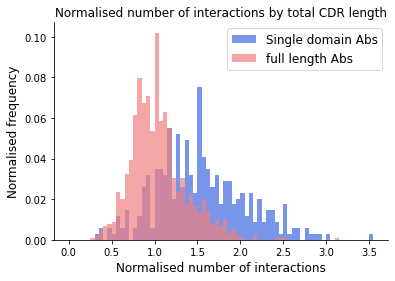

(-5.790509739704195, 7.017312867448428e-09)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:26 2022.

The unpaired mean difference between sdab and flab is 0.154 [95%CI 0.0676, 0.237].
The p-value of the two-sided permutation t-test is 0.001. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


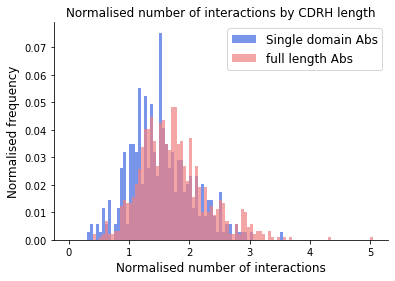

(-7.1256891350585265, 1.035612147523752e-12)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:28 2022.

The unpaired mean difference between sdab and flab is 0.181 [95%CI 0.116, 0.247].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


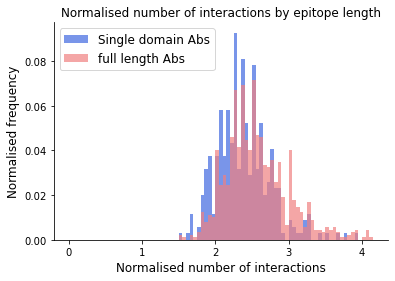

(11.008144291340345, 3.4912050126661483e-28)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:29 2022.

The unpaired mean difference between sdab and flab is -0.247 [95%CI -0.304, -0.183].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


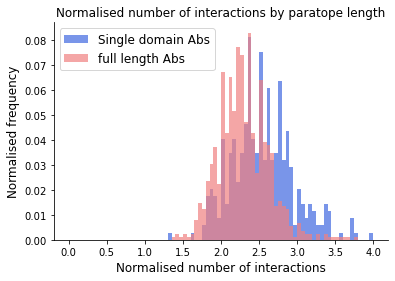

In [50]:
# #Plot normalised number interactions
#Normalised by CDRH for single domain and by CDRHL for full length
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "normalised_interactions_per_CDRH_length", "normalised_interactions_per_CDRHL_length", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Normalised number of interactions by total CDR length', 'Normalised number of interactions')

## normalised by the CDRH for both heavy and light
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "normalised_interactions_per_CDRH_length", "normalised_interactions_per_CDRH_length", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Normalised number of interactions by CDRH length', 'Normalised number of interactions')

#Plot normalised fraction by epitope length
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "normalised_interactions_by_epitope_length", "normalised_interactions_by_epitope_length", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Normalised number of interactions by epitope length', 'Normalised number of interactions')

# #Plot normalised fraction by paratope length
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "normalised_interactions_by_paratope_length", "normalised_interactions_by_paratope_length", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Normalised number of interactions by paratope length', 'Normalised number of interactions')


(-7.944700000335749, 1.9466131591598802e-15)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:54:11 2023.

The unpaired mean difference between sdab and flab is 0.0637 [95%CI 0.0407, 0.0874].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


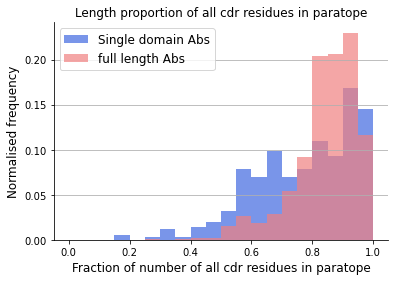

(-9.85894409171345, 6.270532677109372e-23)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:54:12 2023.

The unpaired mean difference between sdab and flab is 0.095 [95%CI 0.0711, 0.12].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


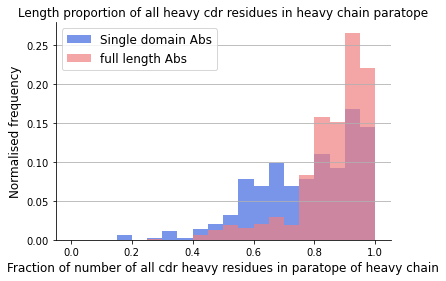

(-6.558476031977792, 5.4360441965921965e-11)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:54:13 2023.

The unpaired mean difference between sdab and flab is 0.0566 [95%CI 0.035, 0.0778].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


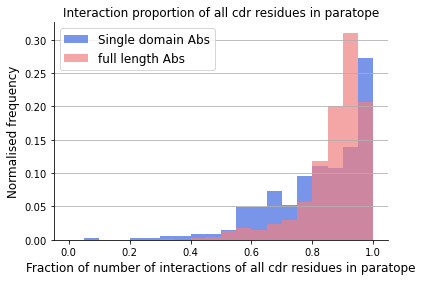

(-7.621348032122727, 2.5104006966737424e-14)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:54:14 2023.

The unpaired mean difference between sdab and flab is 0.0618 [95%CI 0.0383, 0.087].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


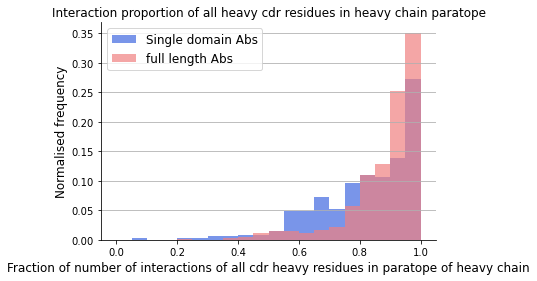

In [10]:
## Fraction of CDR in paratope
#to study how many fragment amino acids in paratope
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "length_proportion_all_cdrs_in_paratope", "length_proportion_all_cdrs_in_paratope", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Length proportion of all cdr residues in paratope', 'Fraction of number of all cdr residues in paratope', grid = True)
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "length_proportion_all_cdrs_in_paratope", "length_proportion_cdrhs_in_paratope_heavy", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Length proportion of all heavy cdr residues in heavy chain paratope', 'Fraction of number of all cdr heavy residues in paratope of heavy chain', grid = True)

plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "interaction_proportion_all_cdrs_in_paratope", "interaction_proportion_all_cdrs_in_paratope", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Interaction proportion of all cdr residues in paratope', 'Fraction of number of interactions of all cdr residues in paratope', grid = True)
plot_distribution(df_summary_interaction_nb, df_summary_interaction_fv, "interaction_proportion_all_cdrs_in_paratope", "interaction_proportion_cdrhs_in_paratope_heavy", 0.05, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral', 'Interaction proportion of all heavy cdr residues in heavy chain paratope', 'Fraction of number of interactions of all cdr heavy residues in paratope of heavy chain', grid = True)


In [52]:
##Study distributions per cdr type

(2.86713324750353, 0.0041420857767239284)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:36 2022.

The unpaired mean difference between sdab and flab is -0.933 [95%CI -1.84, -0.02].
The p-value of the two-sided permutation t-test is 0.045. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


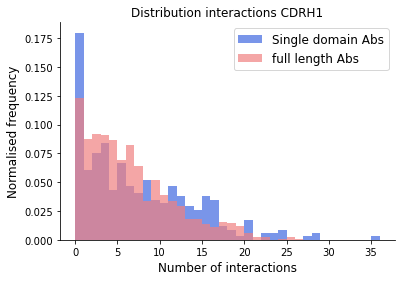

(3.2658822789368998, 0.001091236039968368)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:37 2022.

The unpaired mean difference between sdab and flab is -0.128 [95%CI -0.244, -0.00969].
The p-value of the two-sided permutation t-test is 0.0346. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


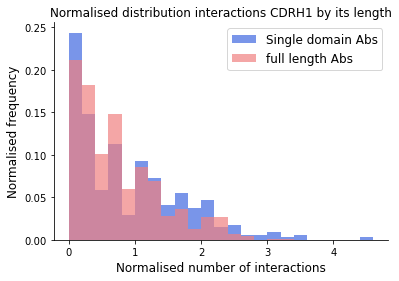

(-5.057895493759988, 4.2390862332329937e-07)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:38 2022.

The unpaired mean difference between sdab and flab is 0.0348 [95%CI 0.0164, 0.0532].
The p-value of the two-sided permutation t-test is 0.0006. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


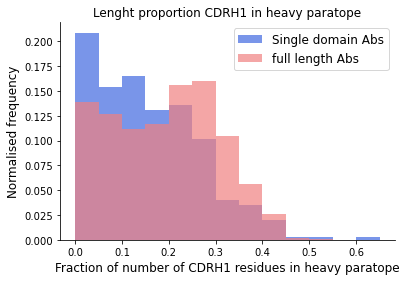

(5.181265330211748, 2.203857329324025e-07)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:39 2022.

The unpaired mean difference between sdab and flab is -0.0207 [95%CI -0.0363, -0.00474].
The p-value of the two-sided permutation t-test is 0.0094. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


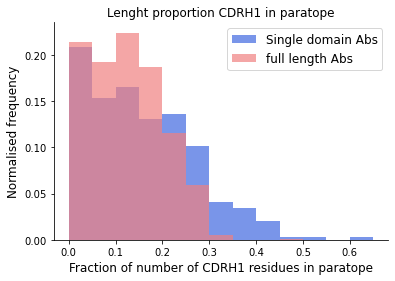

(-2.174263107748301, 0.029685381353188423)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:40 2022.

The unpaired mean difference between sdab and flab is 0.0184 [95%CI -0.00328, 0.0393].
The p-value of the two-sided permutation t-test is 0.0992. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


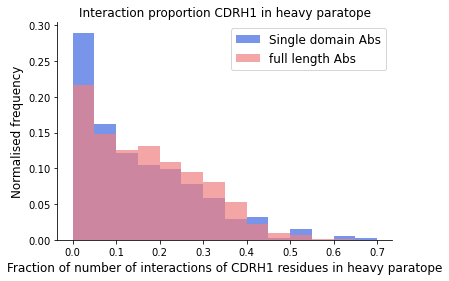

(5.345883008645017, 8.997731404707075e-08)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:42 2022.

The unpaired mean difference between sdab and flab is -0.0281 [95%CI -0.0468, -0.00992].
The p-value of the two-sided permutation t-test is 0.0036. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


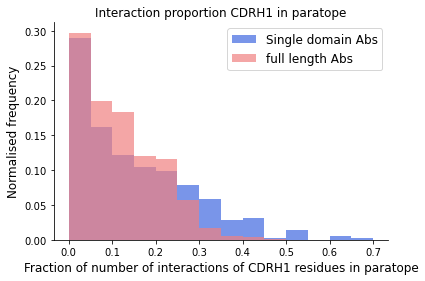

In [53]:
cdr_type = "CDRH1"
df_all_info_nb, df_all_info_fv = evaluate_distributions_per_cdr(df_interaction_info_nb, df_interaction_info_fv, dict_cdr_positions, cdr_type)

(-3.877187484979414, 0.00010567092895703696)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:43 2022.

The unpaired mean difference between sdab and flab is 1.42 [95%CI 0.457, 2.37].
The p-value of the two-sided permutation t-test is 0.0034. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


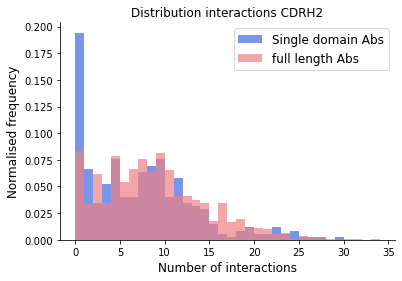

(-3.7790410022743948, 0.00015743350221235014)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:45 2022.

The unpaired mean difference between sdab and flab is 0.177 [95%CI 0.0499, 0.302].
The p-value of the two-sided permutation t-test is 0.006. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


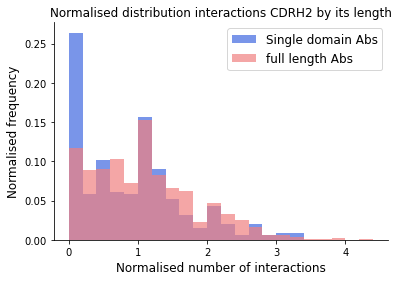

(-10.379315115056508, 3.079766088592577e-25)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:47 2022.

The unpaired mean difference between sdab and flab is 0.0931 [95%CI 0.0727, 0.114].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


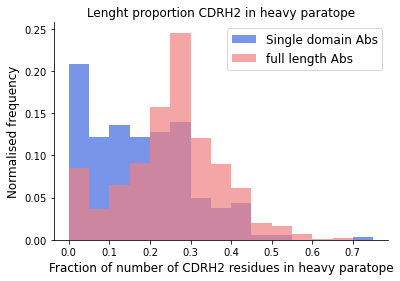

(1.5773613603091634, 0.11471240097003033)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:49 2022.

The unpaired mean difference between sdab and flab is -0.00433 [95%CI -0.0208, 0.0117].
The p-value of the two-sided permutation t-test is 0.622. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


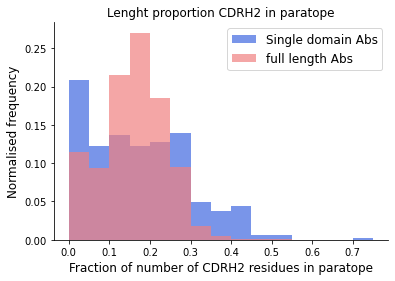

(-9.563369052033943, 1.1398442602508723e-21)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:50 2022.

The unpaired mean difference between sdab and flab is 0.0832 [95%CI 0.0595, 0.106].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


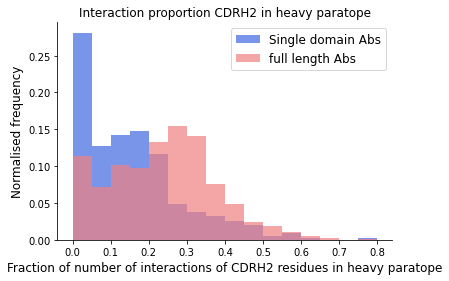

(-1.161342188870735, 0.24550276894676637)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:45:51 2022.

The unpaired mean difference between sdab and flab is 0.0159 [95%CI -0.00452, 0.0341].
The p-value of the two-sided permutation t-test is 0.0986. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


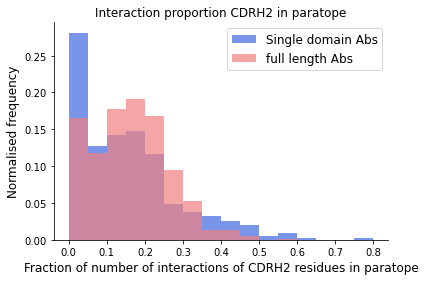

In [54]:
cdr_type = "CDRH2"
df_all_info_nb, df_all_info_fv = evaluate_distributions_per_cdr(df_interaction_info_nb, df_interaction_info_fv, dict_cdr_positions, cdr_type)

(14.236597948869194, 5.430721156822428e-46)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:54:58 2023.

The unpaired mean difference between sdab and flab is -7.59 [95%CI -9.18, -5.99].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


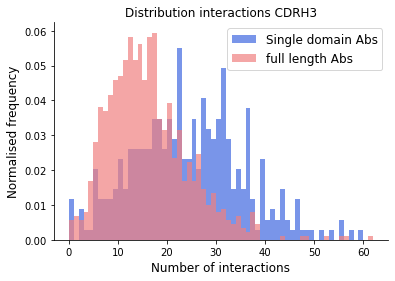

(13.874839133292266, 8.999477066951487e-44)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:55:00 2023.

The unpaired mean difference between sdab and flab is -0.483 [95%CI -0.573, -0.394].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


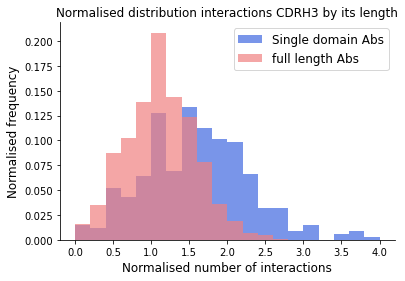

(2.6856039373222753, 0.007239885288400065)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:55:01 2023.

The unpaired mean difference between sdab and flab is -0.0374 [95%CI -0.0678, -0.00646].
The p-value of the two-sided permutation t-test is 0.0148. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


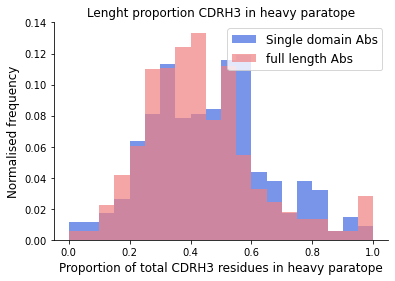

(21.380174469851596, 2.043640920801222e-101)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:55:02 2023.

The unpaired mean difference between sdab and flab is -0.189 [95%CI -0.215, -0.164].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


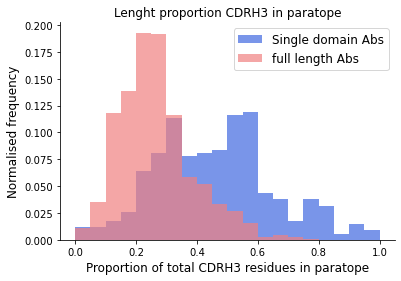

(2.6513057206647805, 0.008018122726569018)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:55:03 2023.

The unpaired mean difference between sdab and flab is -0.0405 [95%CI -0.0751, -0.00619].
The p-value of the two-sided permutation t-test is 0.022. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


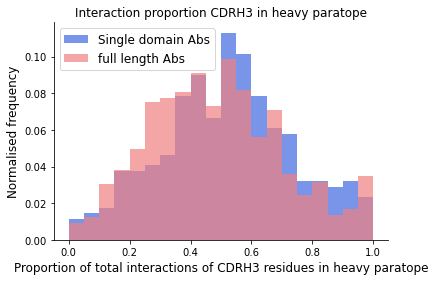

(18.046860528998405, 8.350438301423171e-73)
DABEST v0.3.1
             
Good evening!
The current time is Tue May 16 20:55:04 2023.

The unpaired mean difference between sdab and flab is -0.205 [95%CI -0.235, -0.174].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


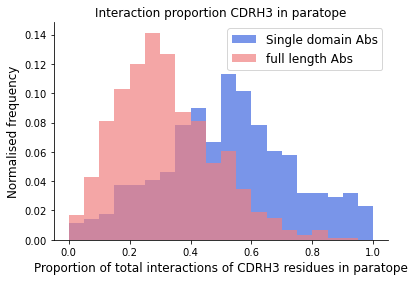

In [11]:
cdr_type = "CDRH3"
df_all_info_nb, df_all_info_fv = evaluate_distributions_per_cdr(df_interaction_info_nb, df_interaction_info_fv, dict_cdr_positions, cdr_type)

In [56]:
# #Plot per IMGT CDRH3 position
# start_position = 105
# end_position = 117
# df_interactions_per_position_nb = store_interactions_per_position(df_interaction_info_nb, start_position, end_position)
# df_interactions_per_position_fv = store_interactions_per_position(df_interaction_info_fv, start_position, end_position)
# plot_distribution_per_position(df_interactions_per_position_nb, df_interactions_per_position_fv, 1.0, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral')

In [57]:
# #Plot per IMGT CDRH1 position
# start_position = 27
# end_position = 38
# df_interactions_per_position_nb = store_interactions_per_position(df_interaction_info_nb, start_position, end_position)
# df_interactions_per_position_fv = store_interactions_per_position(df_interaction_info_fv, start_position, end_position)
# plot_distribution_per_position(df_interactions_per_position_nb, df_interactions_per_position_fv, 1.0, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral')

In [58]:
# #Plot per IMGT CDRH2 position
# start_position = 56
# end_position = 65
# df_interactions_per_position_nb = store_interactions_per_position(df_interaction_info_nb, start_position, end_position)
# df_interactions_per_position_fv = store_interactions_per_position(df_interaction_info_fv, start_position, end_position)
# plot_distribution_per_position(df_interactions_per_position_nb, df_interactions_per_position_fv, 1.0, "Single domain Abs", "full length Abs", 'royalblue', 'lightcoral')

In [59]:
###### AFTER ARPEGGIO

In [9]:
#import df's and rename columuns such that code works for these dataframes
ds_name_arp_nb = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_arpeggio_interactions.csv"
df_arp_nb = read_dataset(ds_name_arp_nb)
df_arp_nb_info = prepare_df_arpeggio_output(df_interaction_info_nb, df_arp_nb)

#full length antibodies
ds_name_arp_fv = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_arpeggio_interactions.csv"
df_arp_fv = read_dataset(ds_name_arp_fv)
df_arp_fv_info = prepare_df_arpeggio_output(df_interaction_info_fv, df_arp_fv, is_full_length=True)
# df_arp_fv_info = create_number_interactions_data(df_arp_fv_info) #To select heavy chain only interactions

In [10]:
#Extend datasets with all the usefull informatio
#Single domain
df_summary_arpeggio_nb = perform_extra_calculations(df_arp_nb_info, dict_cdr_positions, is_full_length=False)

#full length
df_summary_arpeggio_fv = perform_extra_calculations(df_arp_fv_info, dict_cdr_positions, is_full_length=True)

In [63]:
####Compare my vs arpeggio sdAbs
# plot_distribution(df_summary_interaction_nb, df_summary_arpeggio_nb, "sum_interactions", "sum_interactions", 2.0, "SdAb our", "SdAb arpeggio", 'royalblue', 'mediumblue', 'Distribution number of interactions')
# plot_distribution(df_summary_interaction_nb, df_summary_arpeggio_nb, "normalised_interactions_per_CDRH_length", "normalised_interactions_per_CDRH_length", 0.1, "SdAb our", "SdAb arpeggio", 'royalblue', 'mediumblue', 'Normalised number of interactions by total CDR length', 'Normalised number of interactions')
# plot_distribution(df_summary_interaction_nb, df_summary_arpeggio_nb, "normalised_interactions_by_paratope_length", "normalised_interactions_by_paratope_length", 0.1, "SdAb our", "SdAb arpeggio", 'royalblue', 'mediumblue', 'Normalised number of interactions by paratope length', 'Normalised number of interactions')

# plot_distribution(df_summary_interaction_nb, df_summary_arpeggio_nb, "length_proportion_all_cdrs_in_paratope", "length_proportion_all_cdrs_in_paratope", 0.05, "SdAb our", "SdAb arpeggio", 'royalblue', 'mediumblue', 'Length proportion of all cdr residues in paratope', 'Fraction of number of all cdr residues in paratope', grid = True)
# plot_distribution(df_summary_interaction_nb, df_summary_arpeggio_nb, "interaction_proportion_all_cdrs_in_paratope", "interaction_proportion_all_cdrs_in_paratope", 0.05, "SdAb our", "SdAb arpeggio", 'royalblue', 'mediumblue', 'Interaction proportion of all cdr residues in paratope', 'Fraction of number of interactions of all cdr residues in paratope', grid = True)


In [64]:
####Compare my vs arpeggio full_length
# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "sum_interactions", "sum_interactions", 2.0, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Distribution number of interactions')
# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "normalised_interactions_per_CDRHL_length", "normalised_interactions_per_CDRHL_length", 0.1, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Normalised number of interactions by total CDR length', 'Normalised number of interactions')
# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "normalised_interactions_per_CDRH_length", "normalised_interactions_per_CDRH_length", 0.1, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Normalised number of interactions by total CDRH length', 'Normalised number of interactions')
# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "normalised_interactions_by_paratope_length", "normalised_interactions_by_paratope_length", 0.1, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Normalised number of interactions by paratope length', 'Normalised number of interactions')

# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "length_proportion_all_cdrs_in_paratope", "length_proportion_all_cdrs_in_paratope", 0.05, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Length proportion of all cdr residues in paratope', 'Fraction of number of all cdr residues in paratope', grid = True)
# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "length_proportion_cdrhs_in_paratope_heavy", "length_proportion_cdrhs_in_paratope_heavy", 0.05, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Length proportion of all heavy cdr residues in paratope of heavy chain', 'Fraction of number of all cdr heavy residues in paratope of heavy chain', grid = True)

# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "interaction_proportion_all_cdrs_in_paratope", "interaction_proportion_all_cdrs_in_paratope", 0.05, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Interaction proportion of all cdr residues in paratope', 'Fraction of number of interactions of all cdr residues in paratope', grid = True)
# plot_distribution(df_summary_interaction_fv, df_summary_arpeggio_fv, "interaction_proportion_cdrhs_in_paratope_heavy", "interaction_proportion_cdrhs_in_paratope_heavy", 0.05, "flAb our", "flAb arpeggio", 'lightcoral', 'red', 'Interaction proportion of all heavy cdr residues in paratope of heavy chain', 'Fraction of number of interactions of all cdr heavy residues in paratope of heavy chain', grid = True)


(-4.194783957511209, 2.7313179158217126e-05)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:53:54 2023.

The unpaired mean difference between sdab and flab is 1.85 [95%CI 0.593, 3.06].
The p-value of the two-sided permutation t-test is 0.0032. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


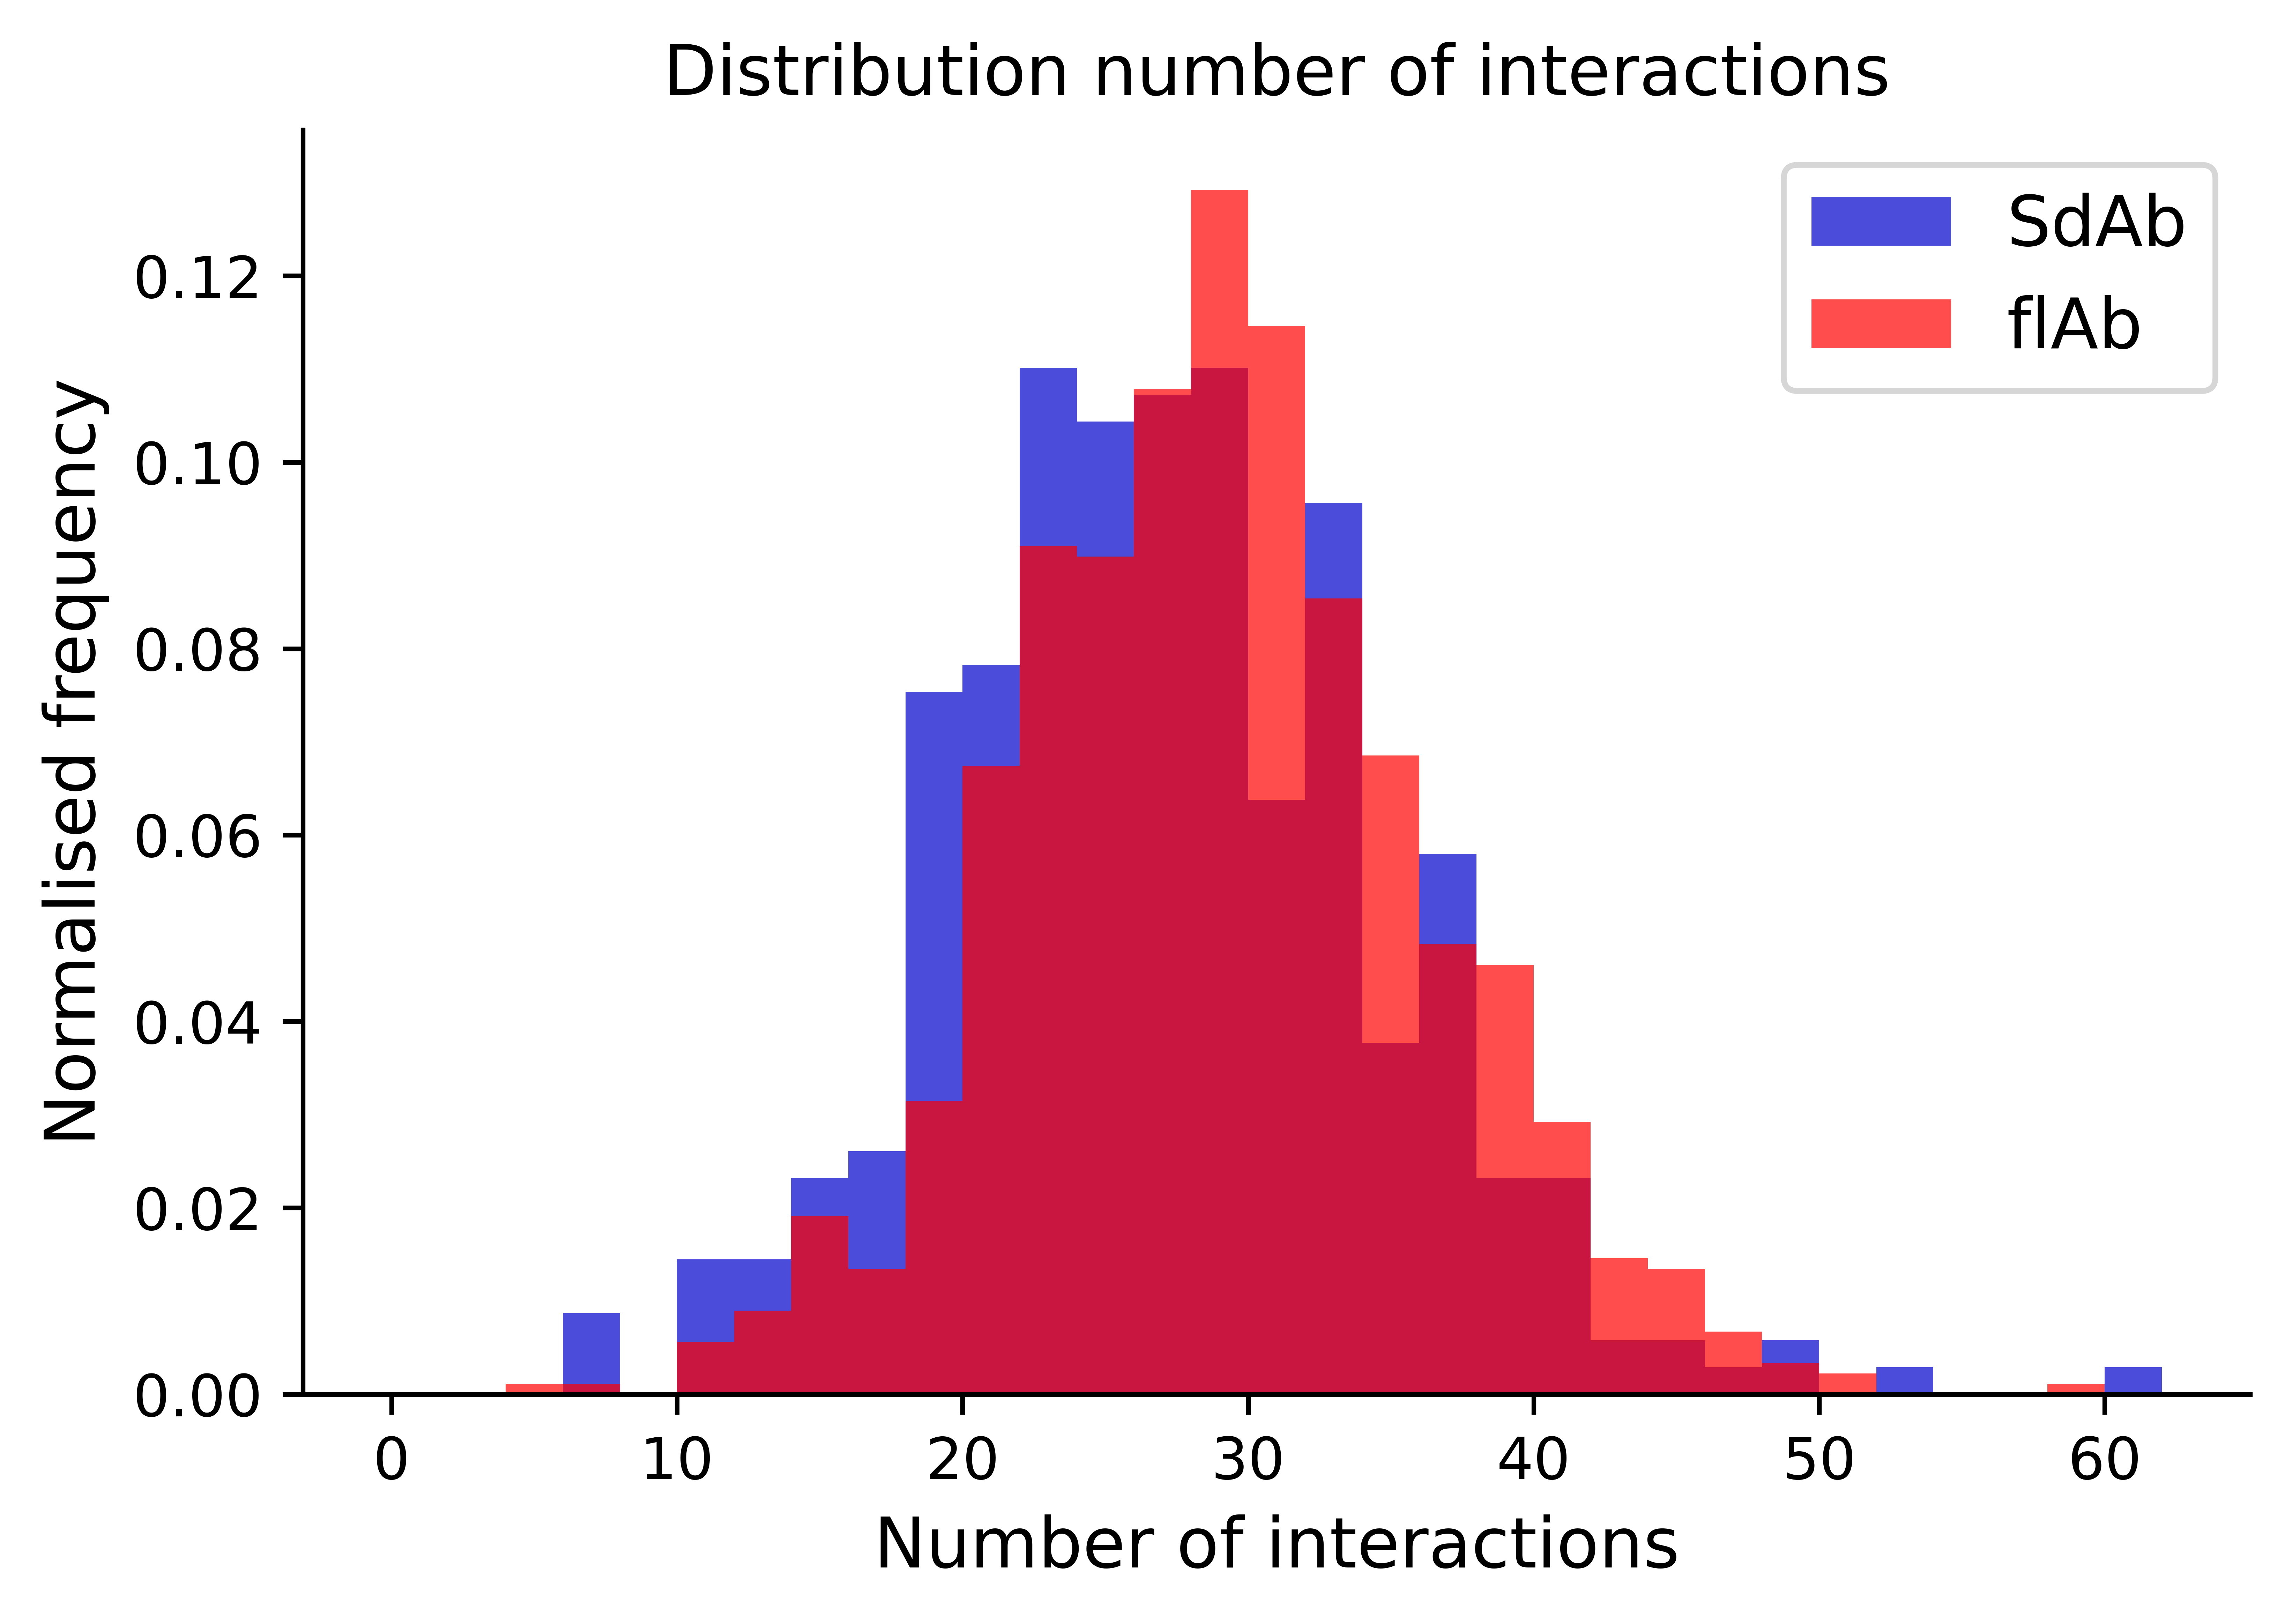

(15.623728877903202, 5.018295642417585e-55)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:53:57 2023.

The unpaired mean difference between sdab and flab is -6.94 [95%CI -8.19, -5.79].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


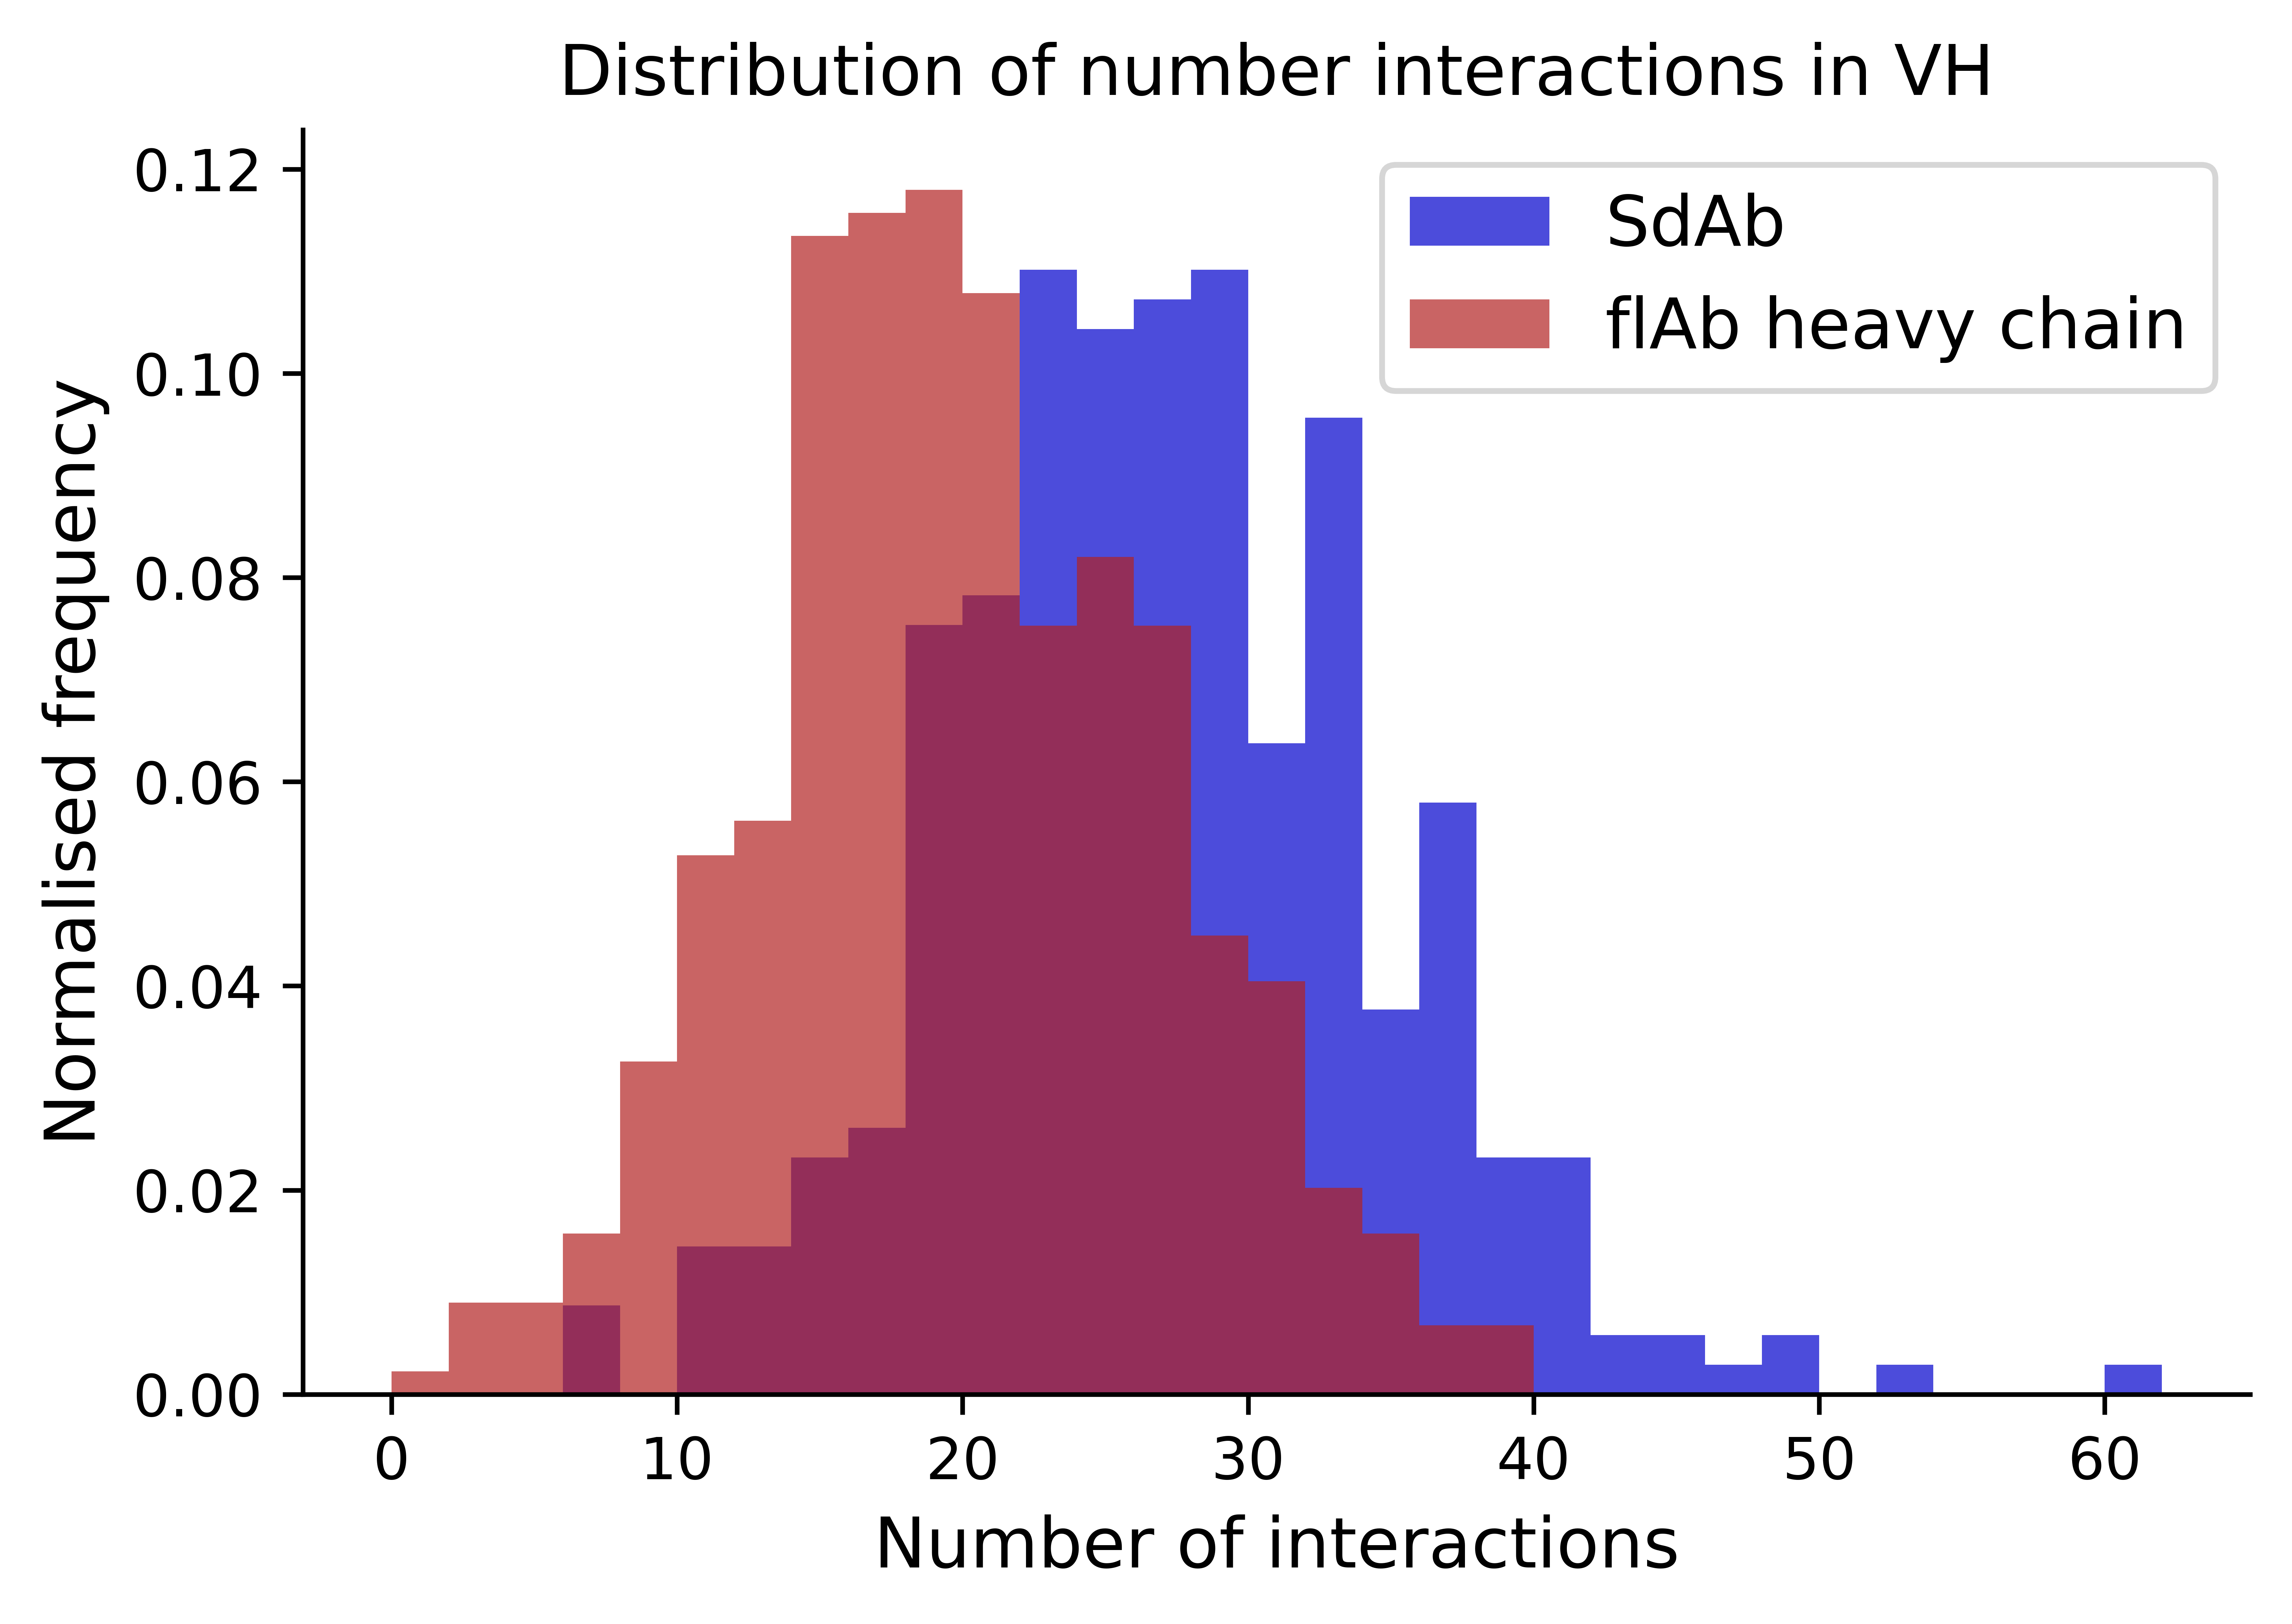

(10.54094894741997, 5.593164457659576e-26)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:02 2023.

The unpaired mean difference between sdab and flab is -0.181 [95%CI -0.223, -0.136].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


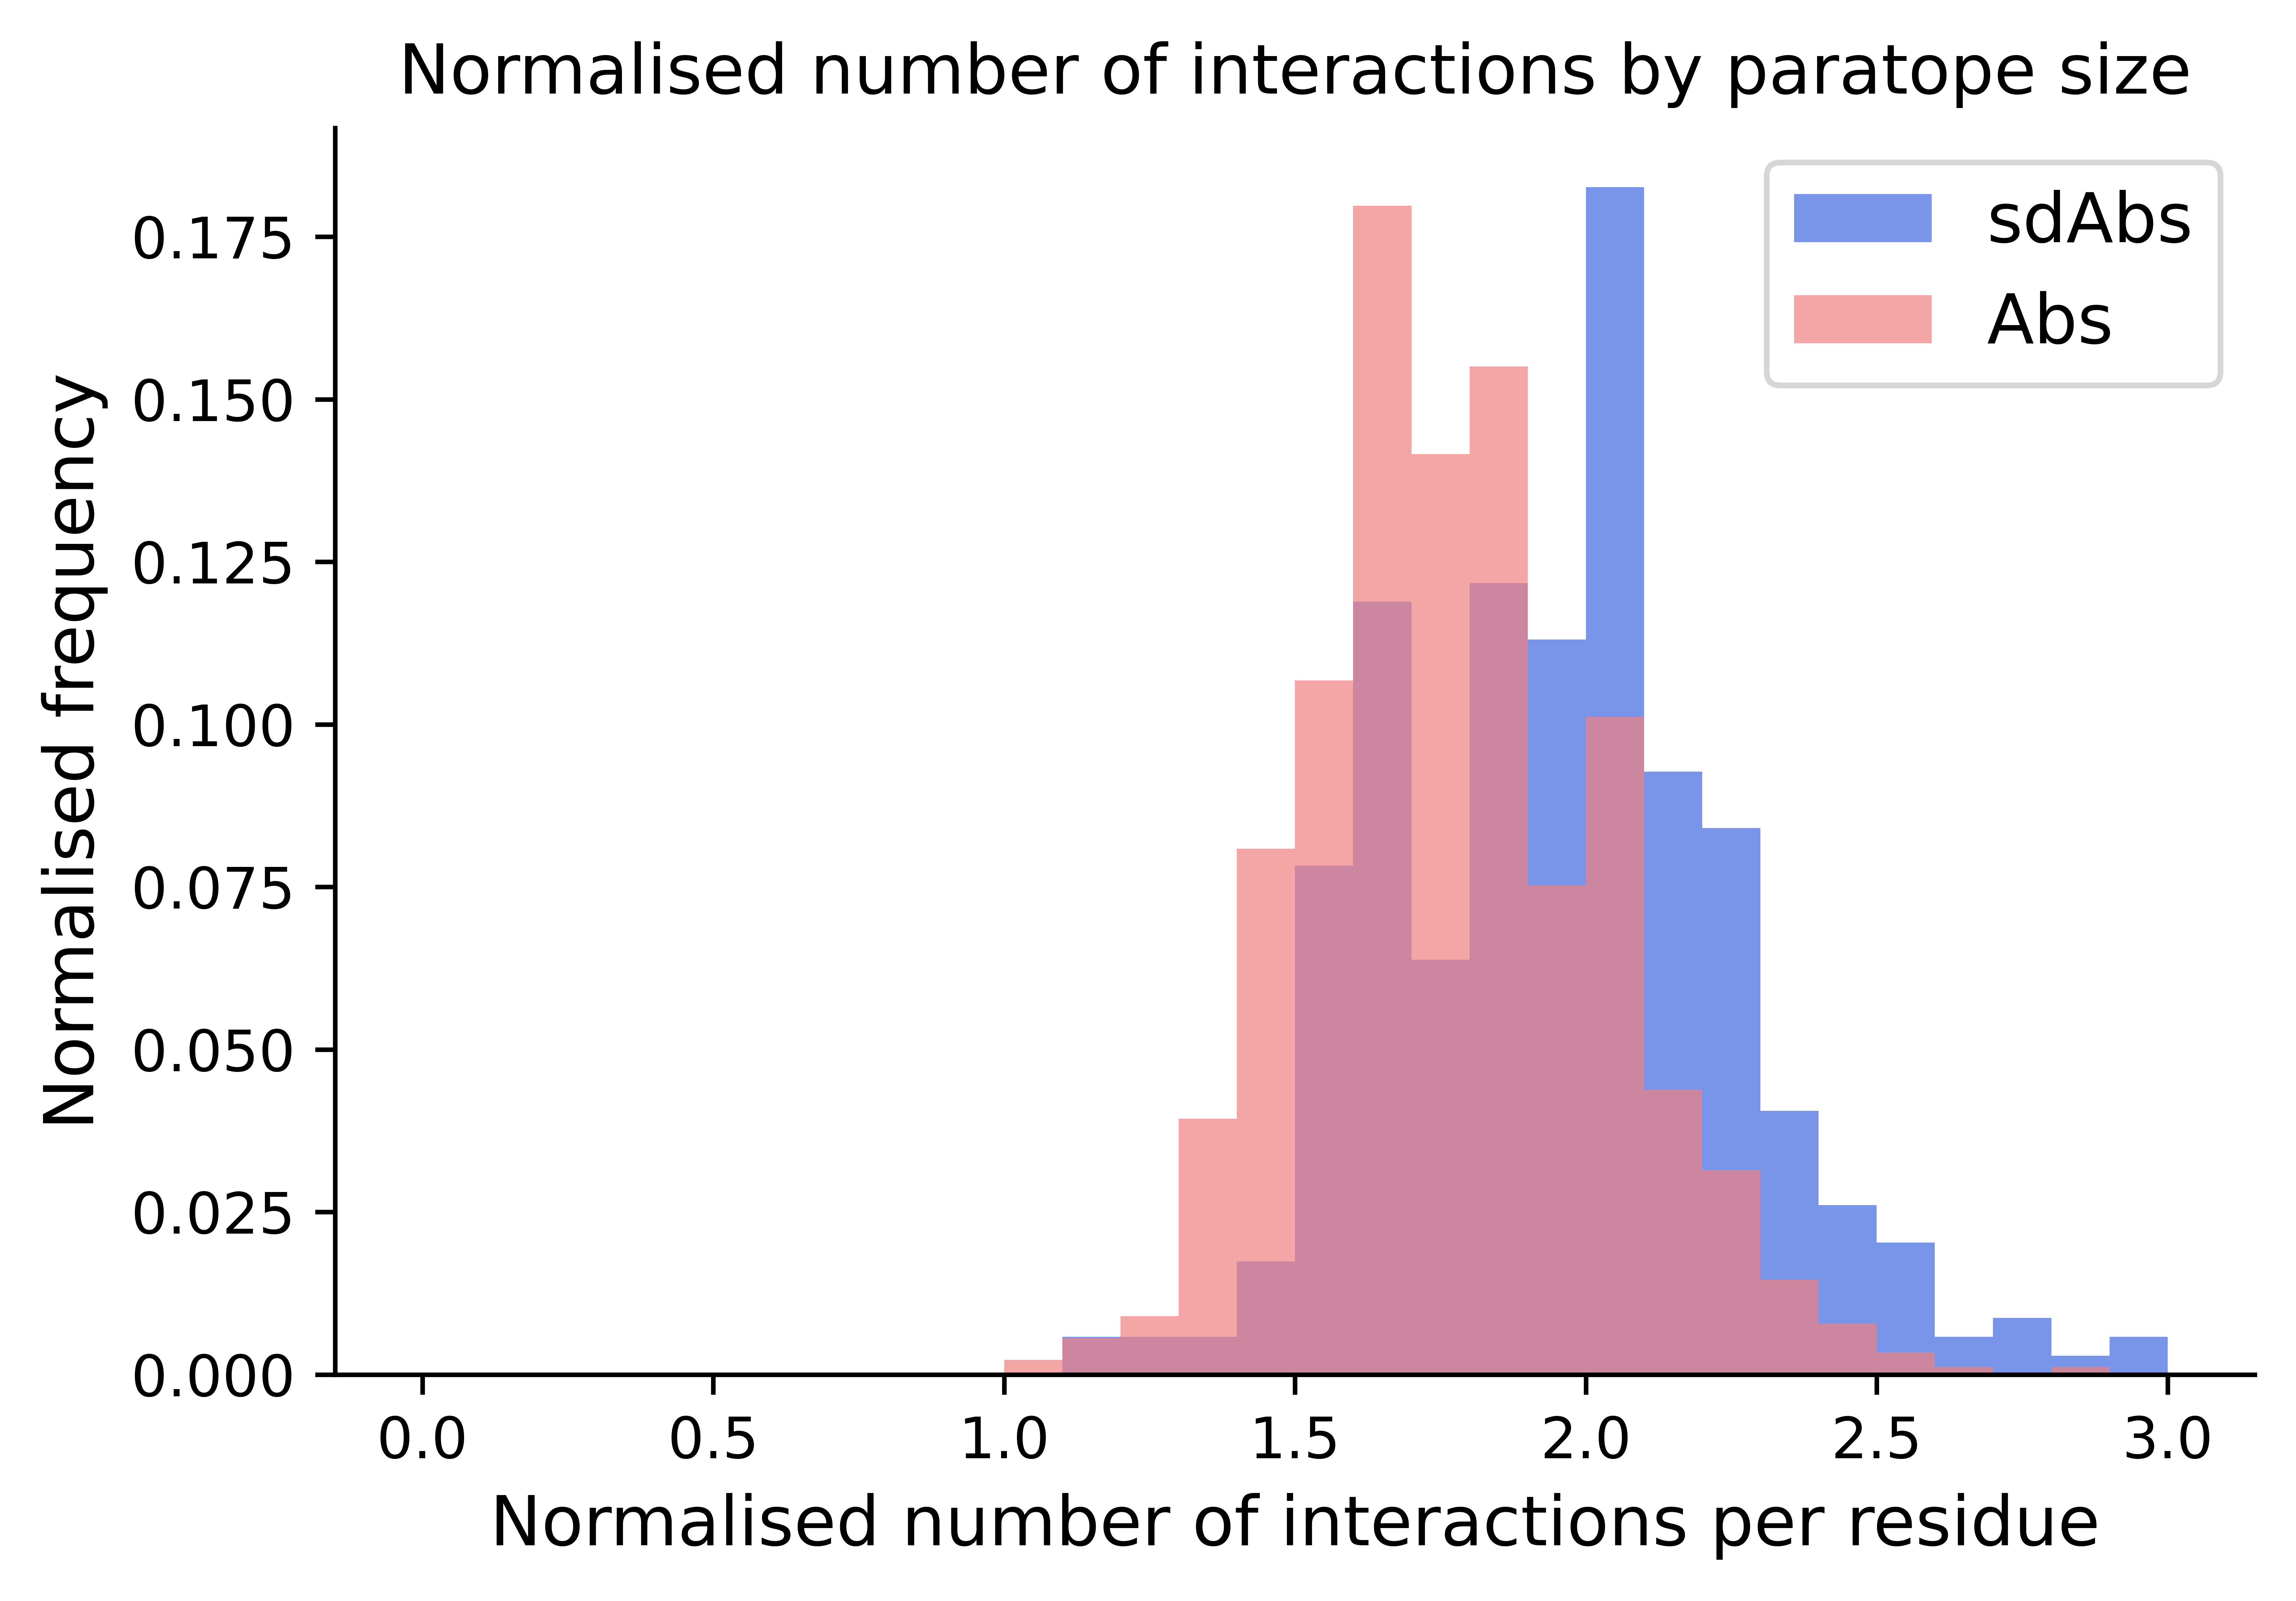

(4.949450748285087, 7.442320731680798e-07)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:06 2023.

The unpaired mean difference between sdab and flab is -0.111 [95%CI -0.164, -0.0563].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


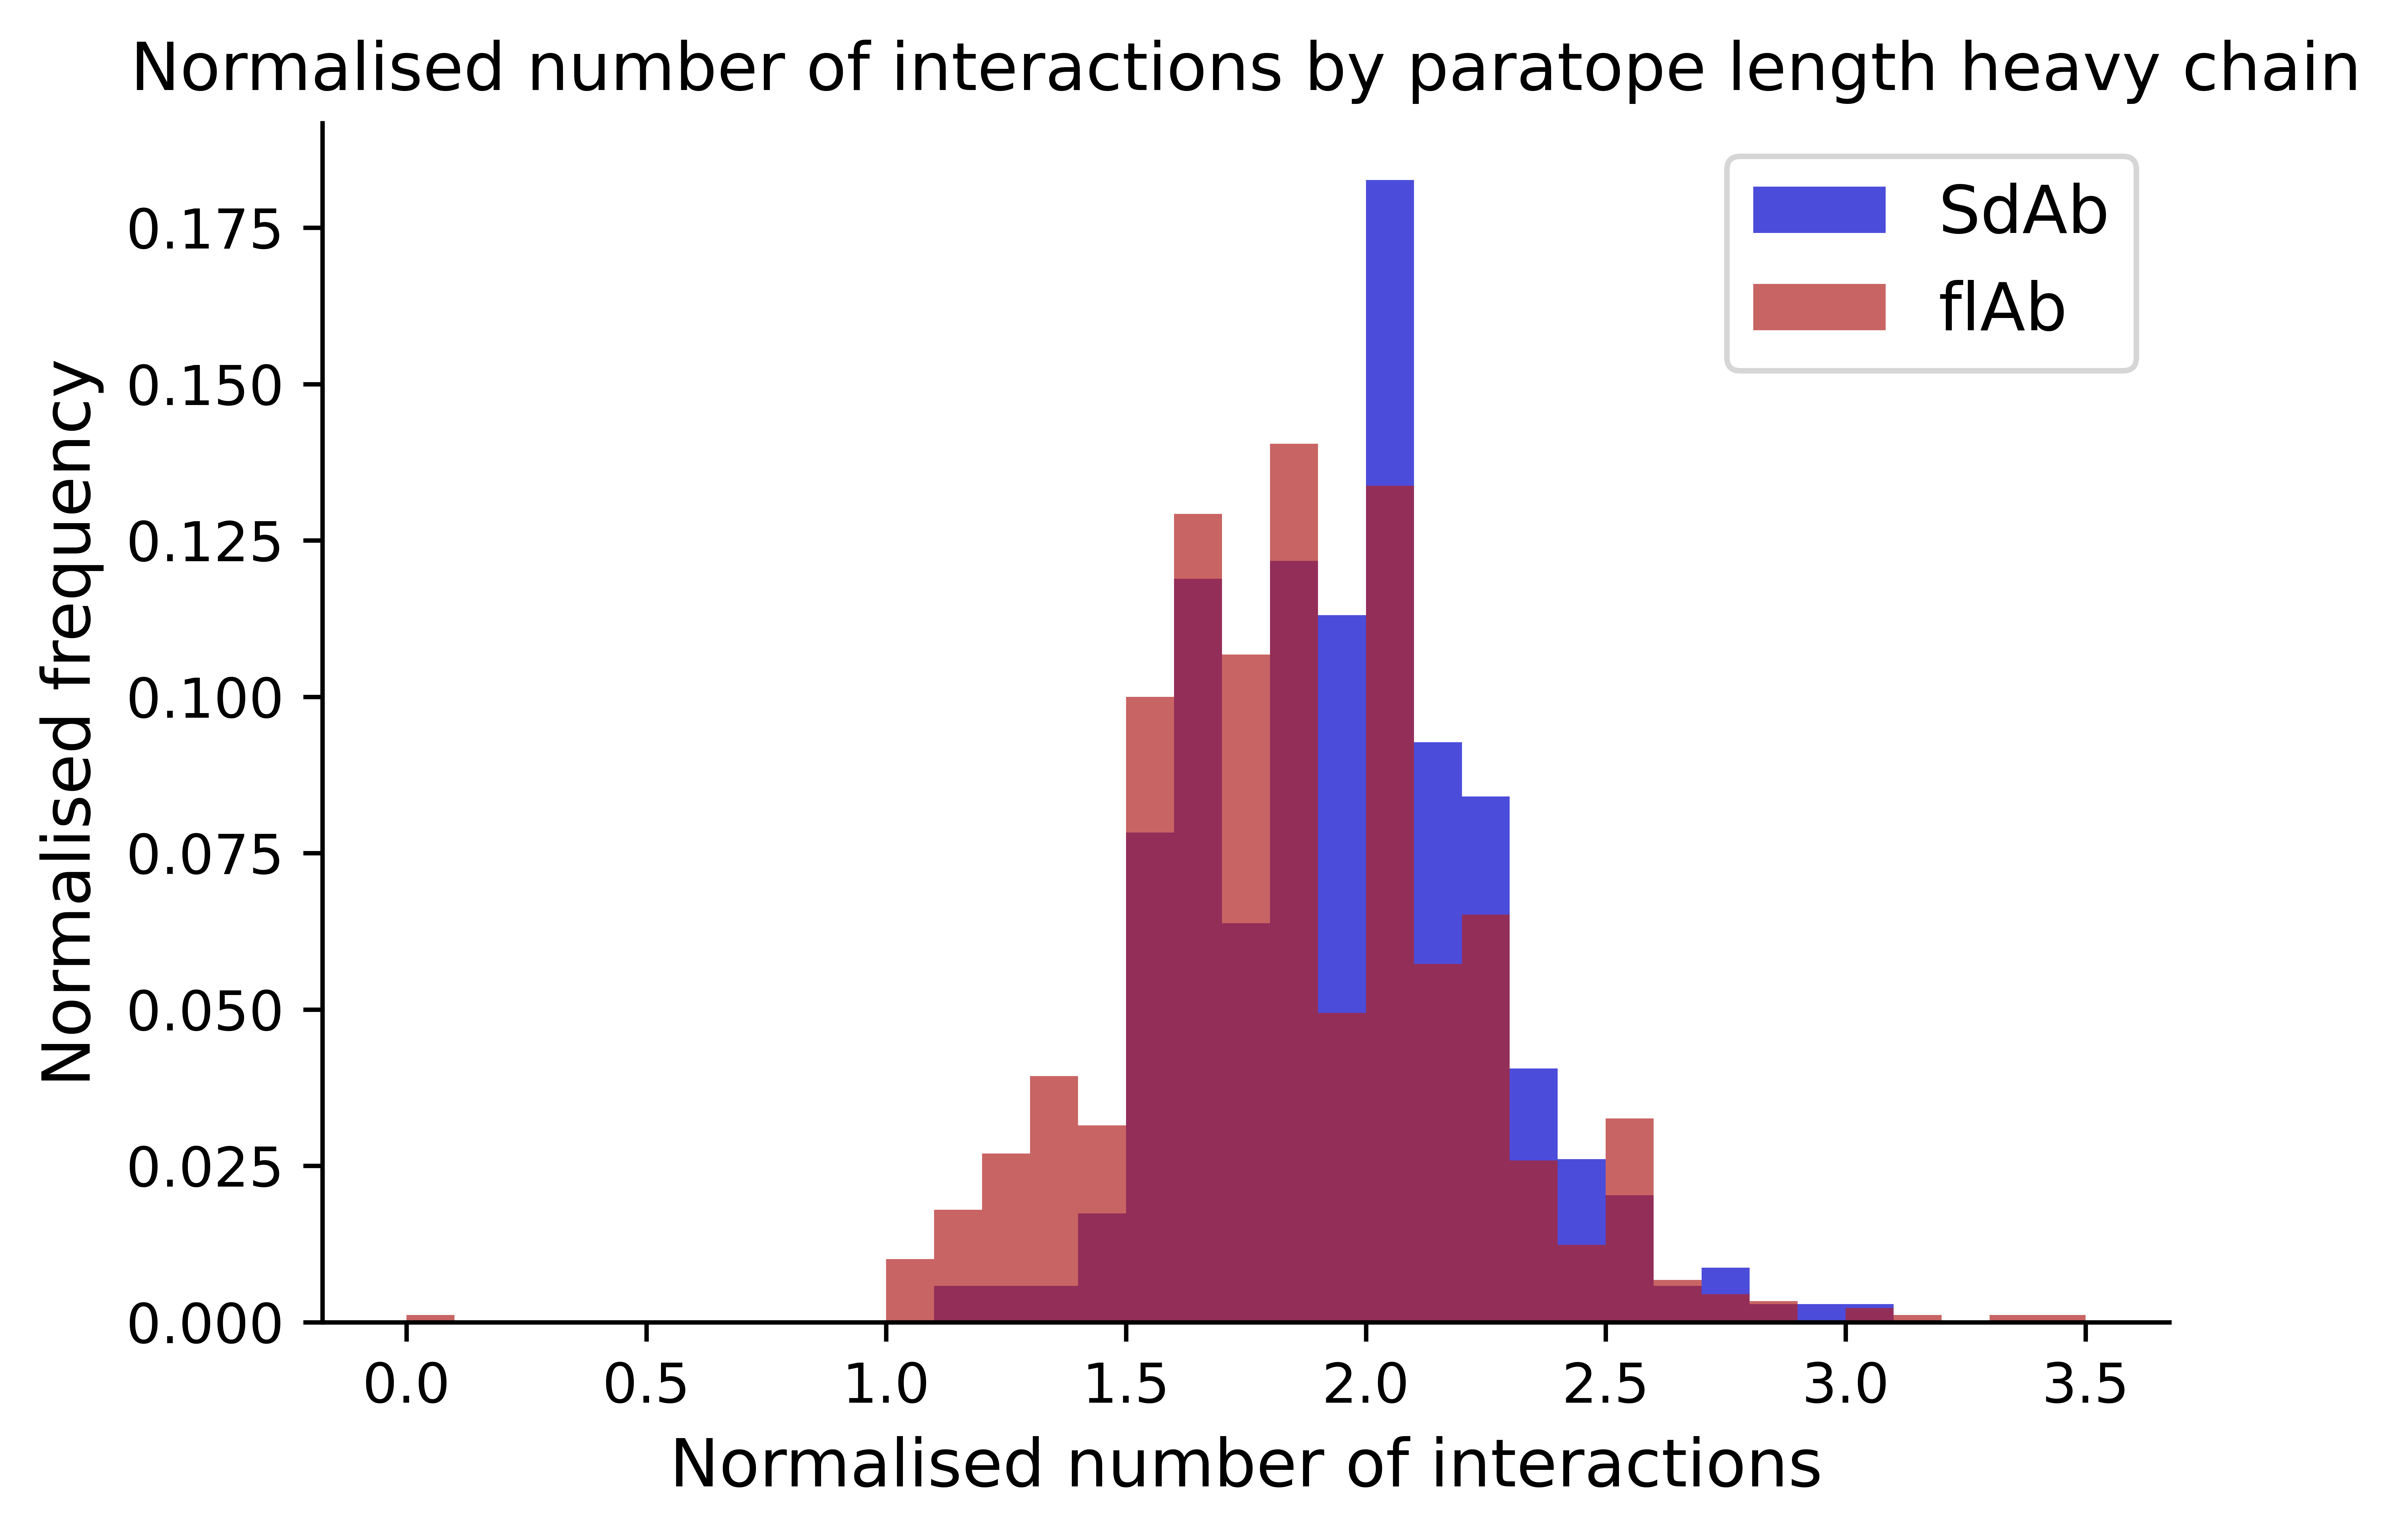

(-5.879305210118321, 4.119921029735016e-09)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:10 2023.

The unpaired mean difference between sdab and flab is 0.119 [95%CI 0.0692, 0.17].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


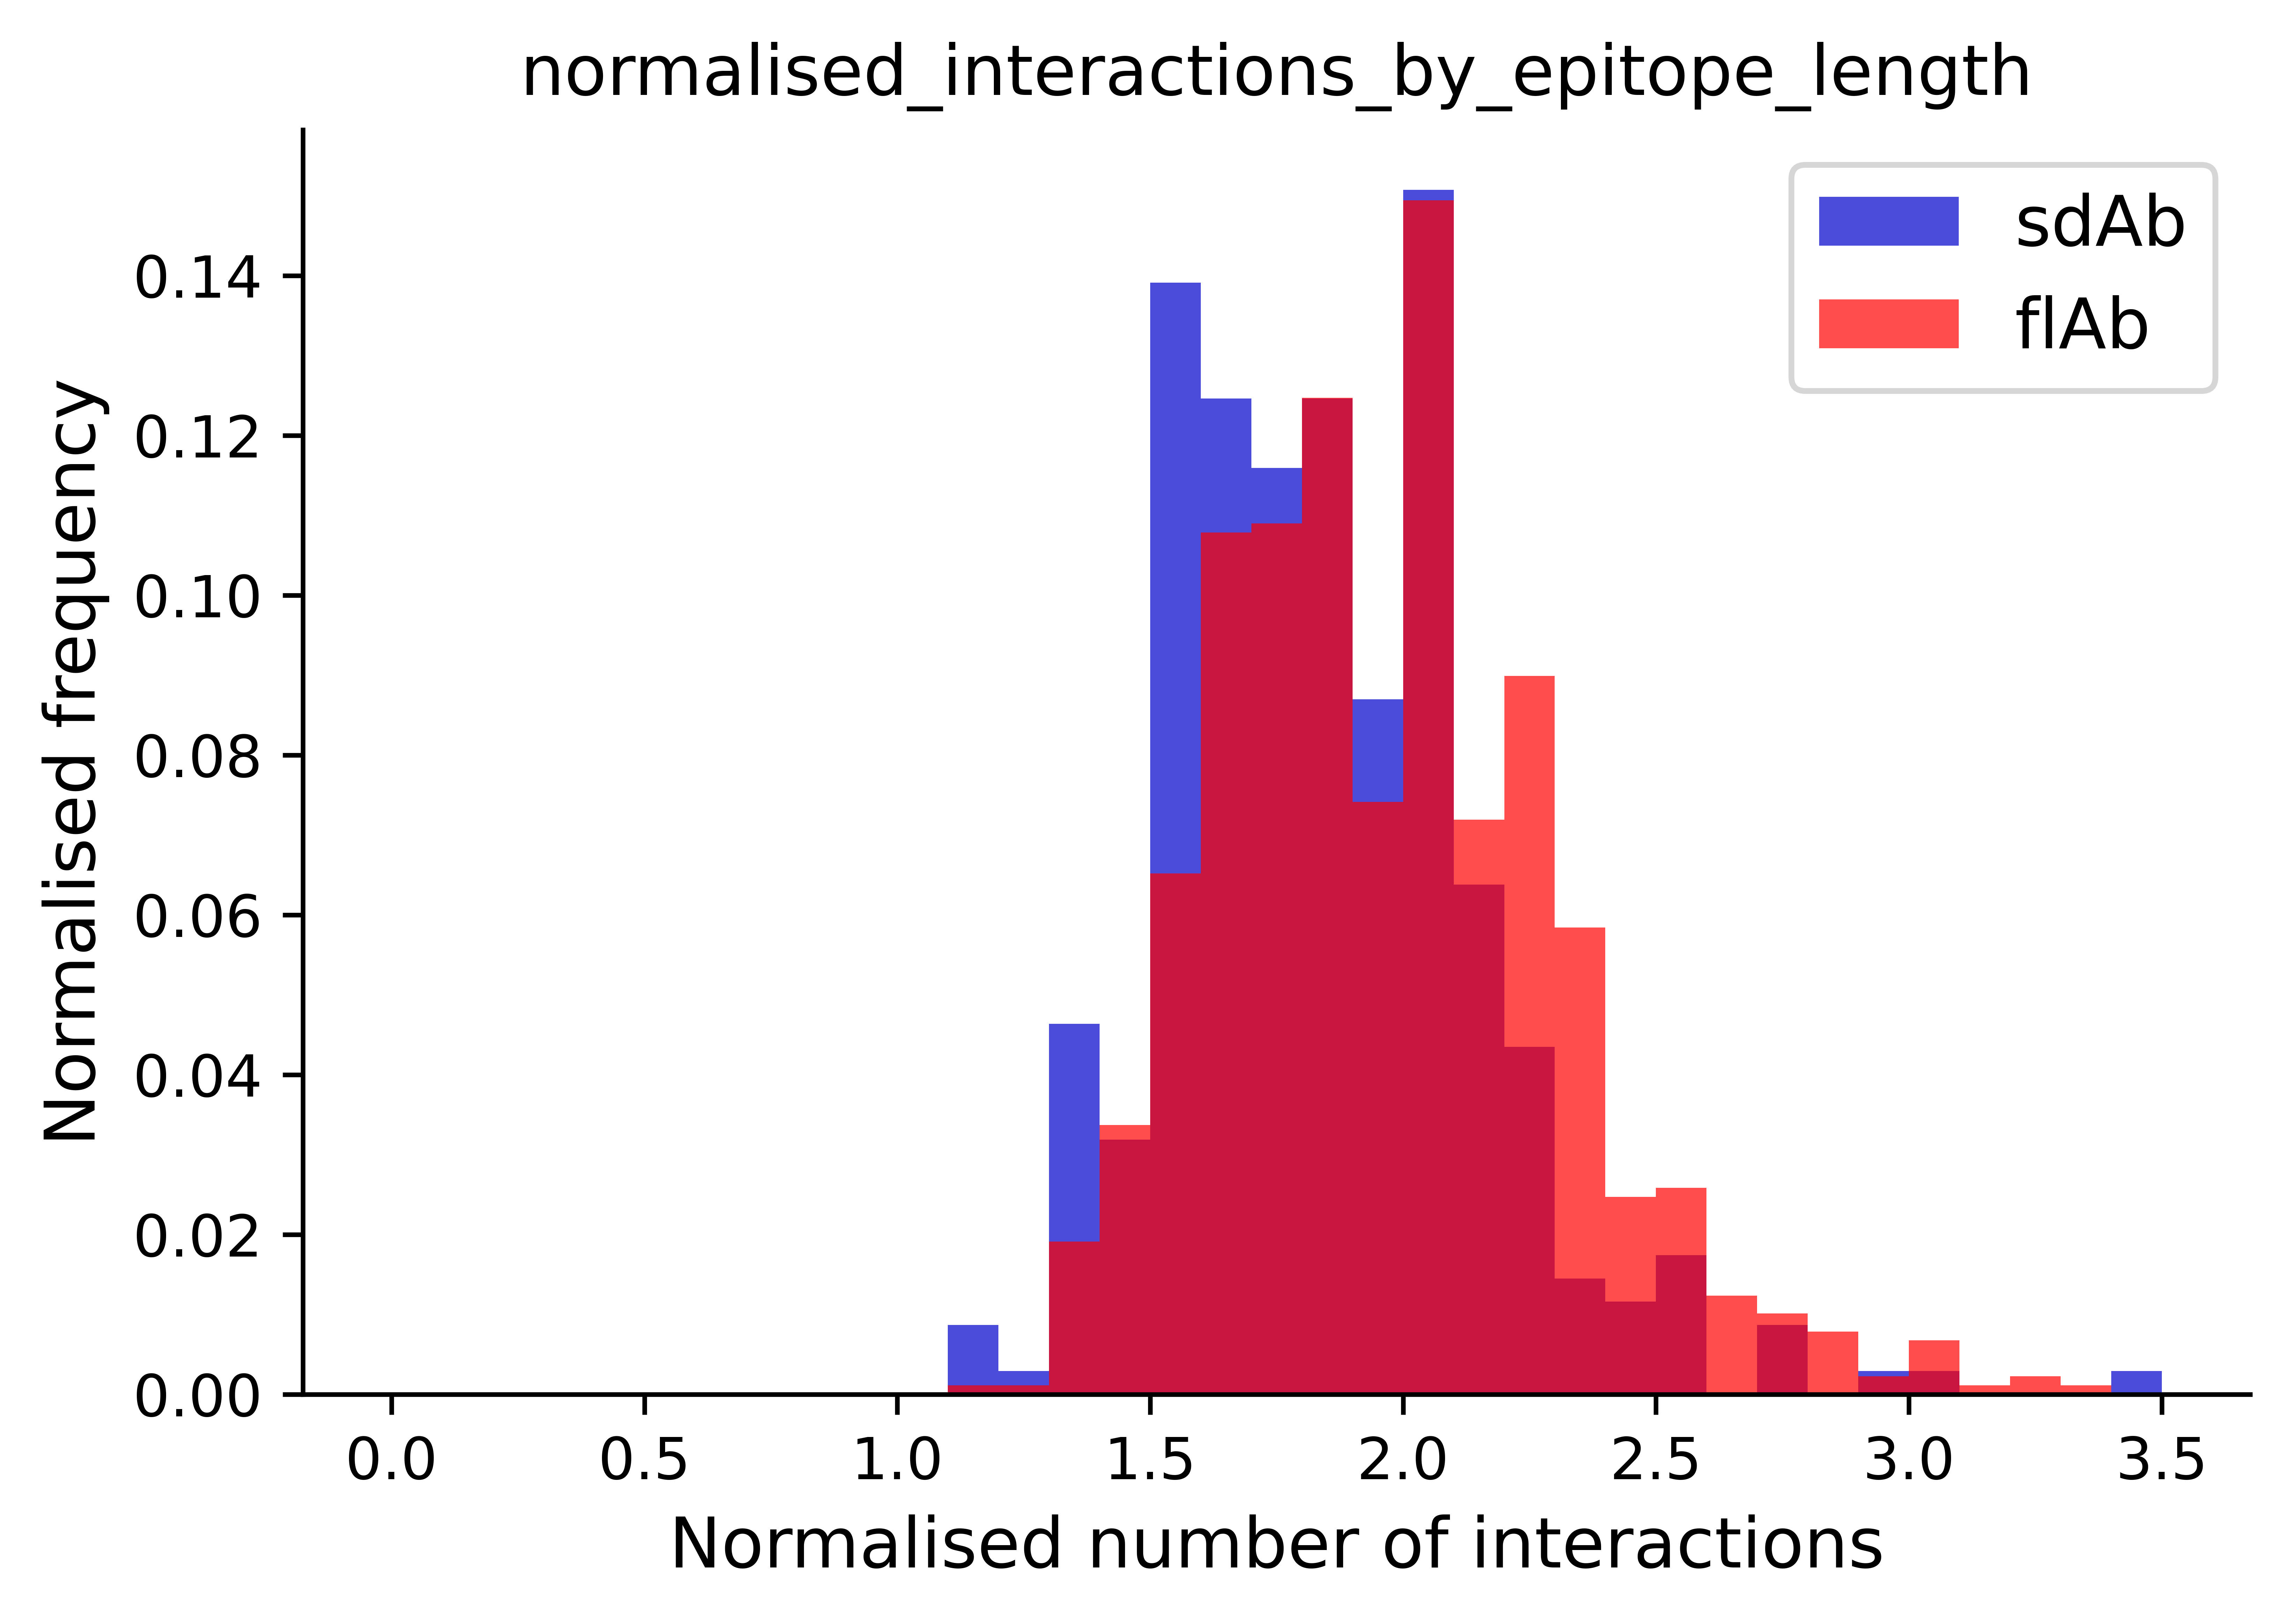

(-7.624787934887267, 2.4443588506741645e-14)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:15 2023.

The unpaired mean difference between sdab and flab is 0.0538 [95%CI 0.0293, 0.0777].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


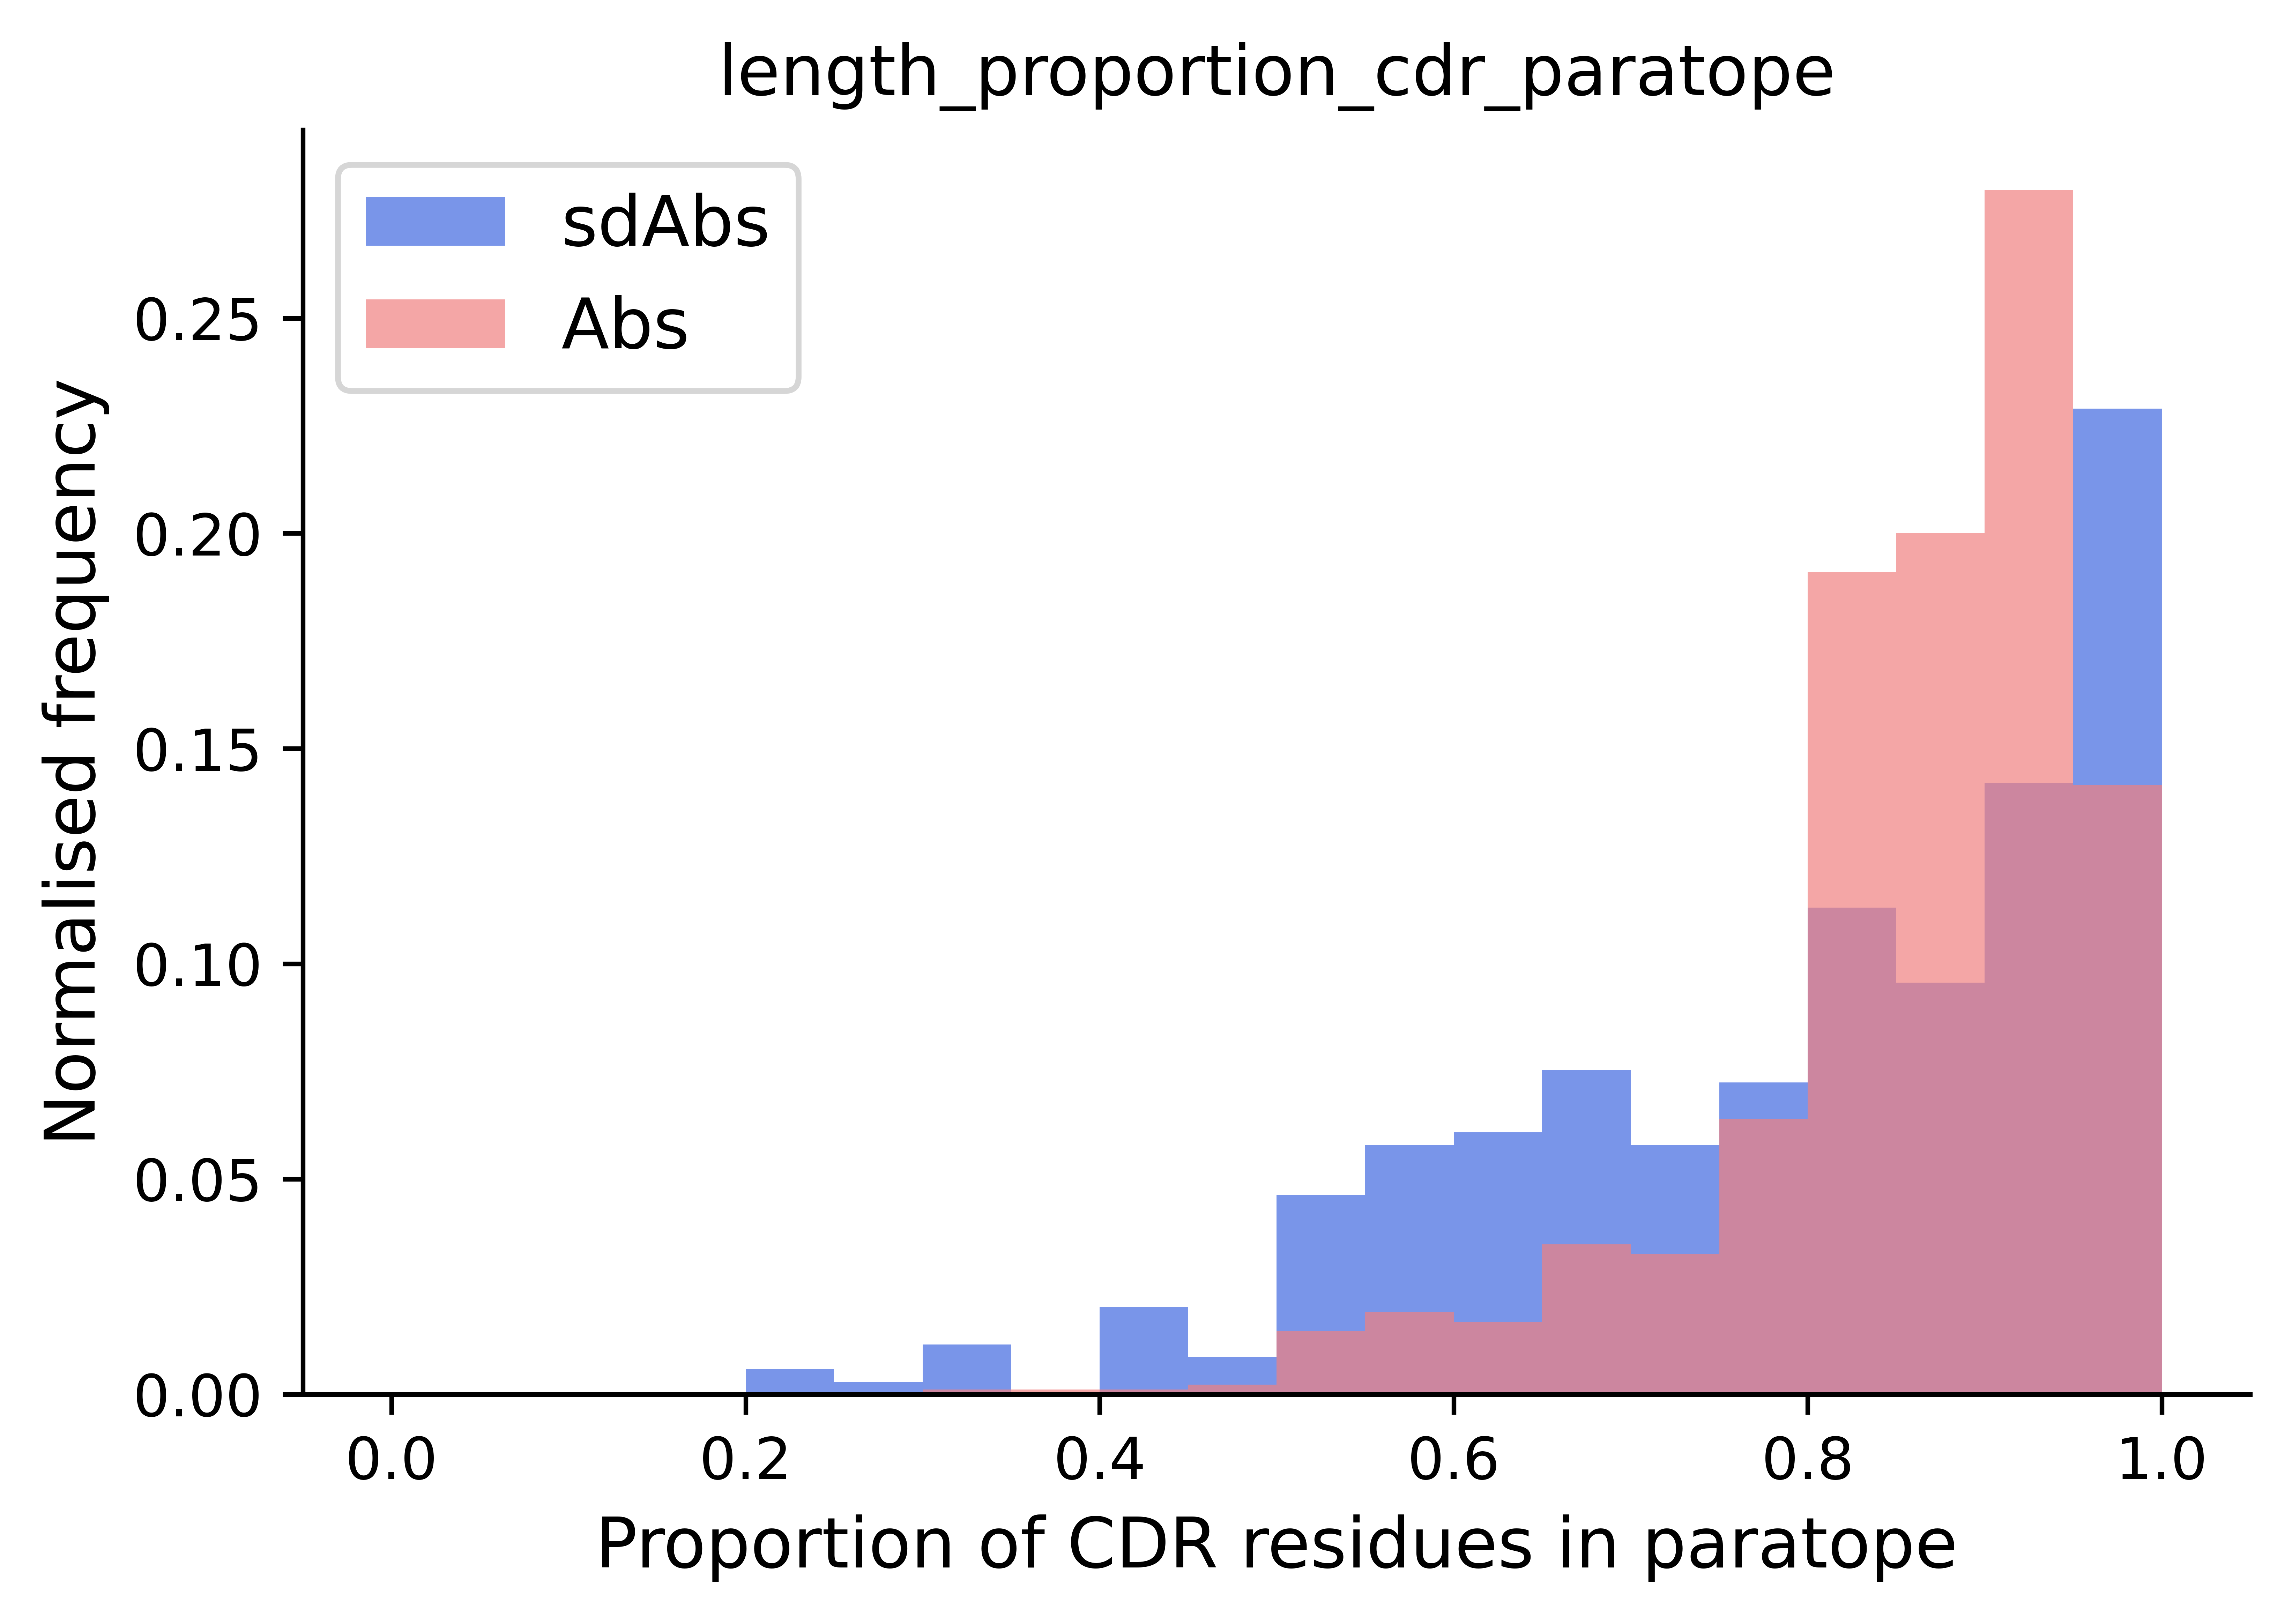

(nan, nan)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:17 2023.

The unpaired mean difference between sdab and flab is 0.0704 [95%CI 0.0453, 0.0946].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


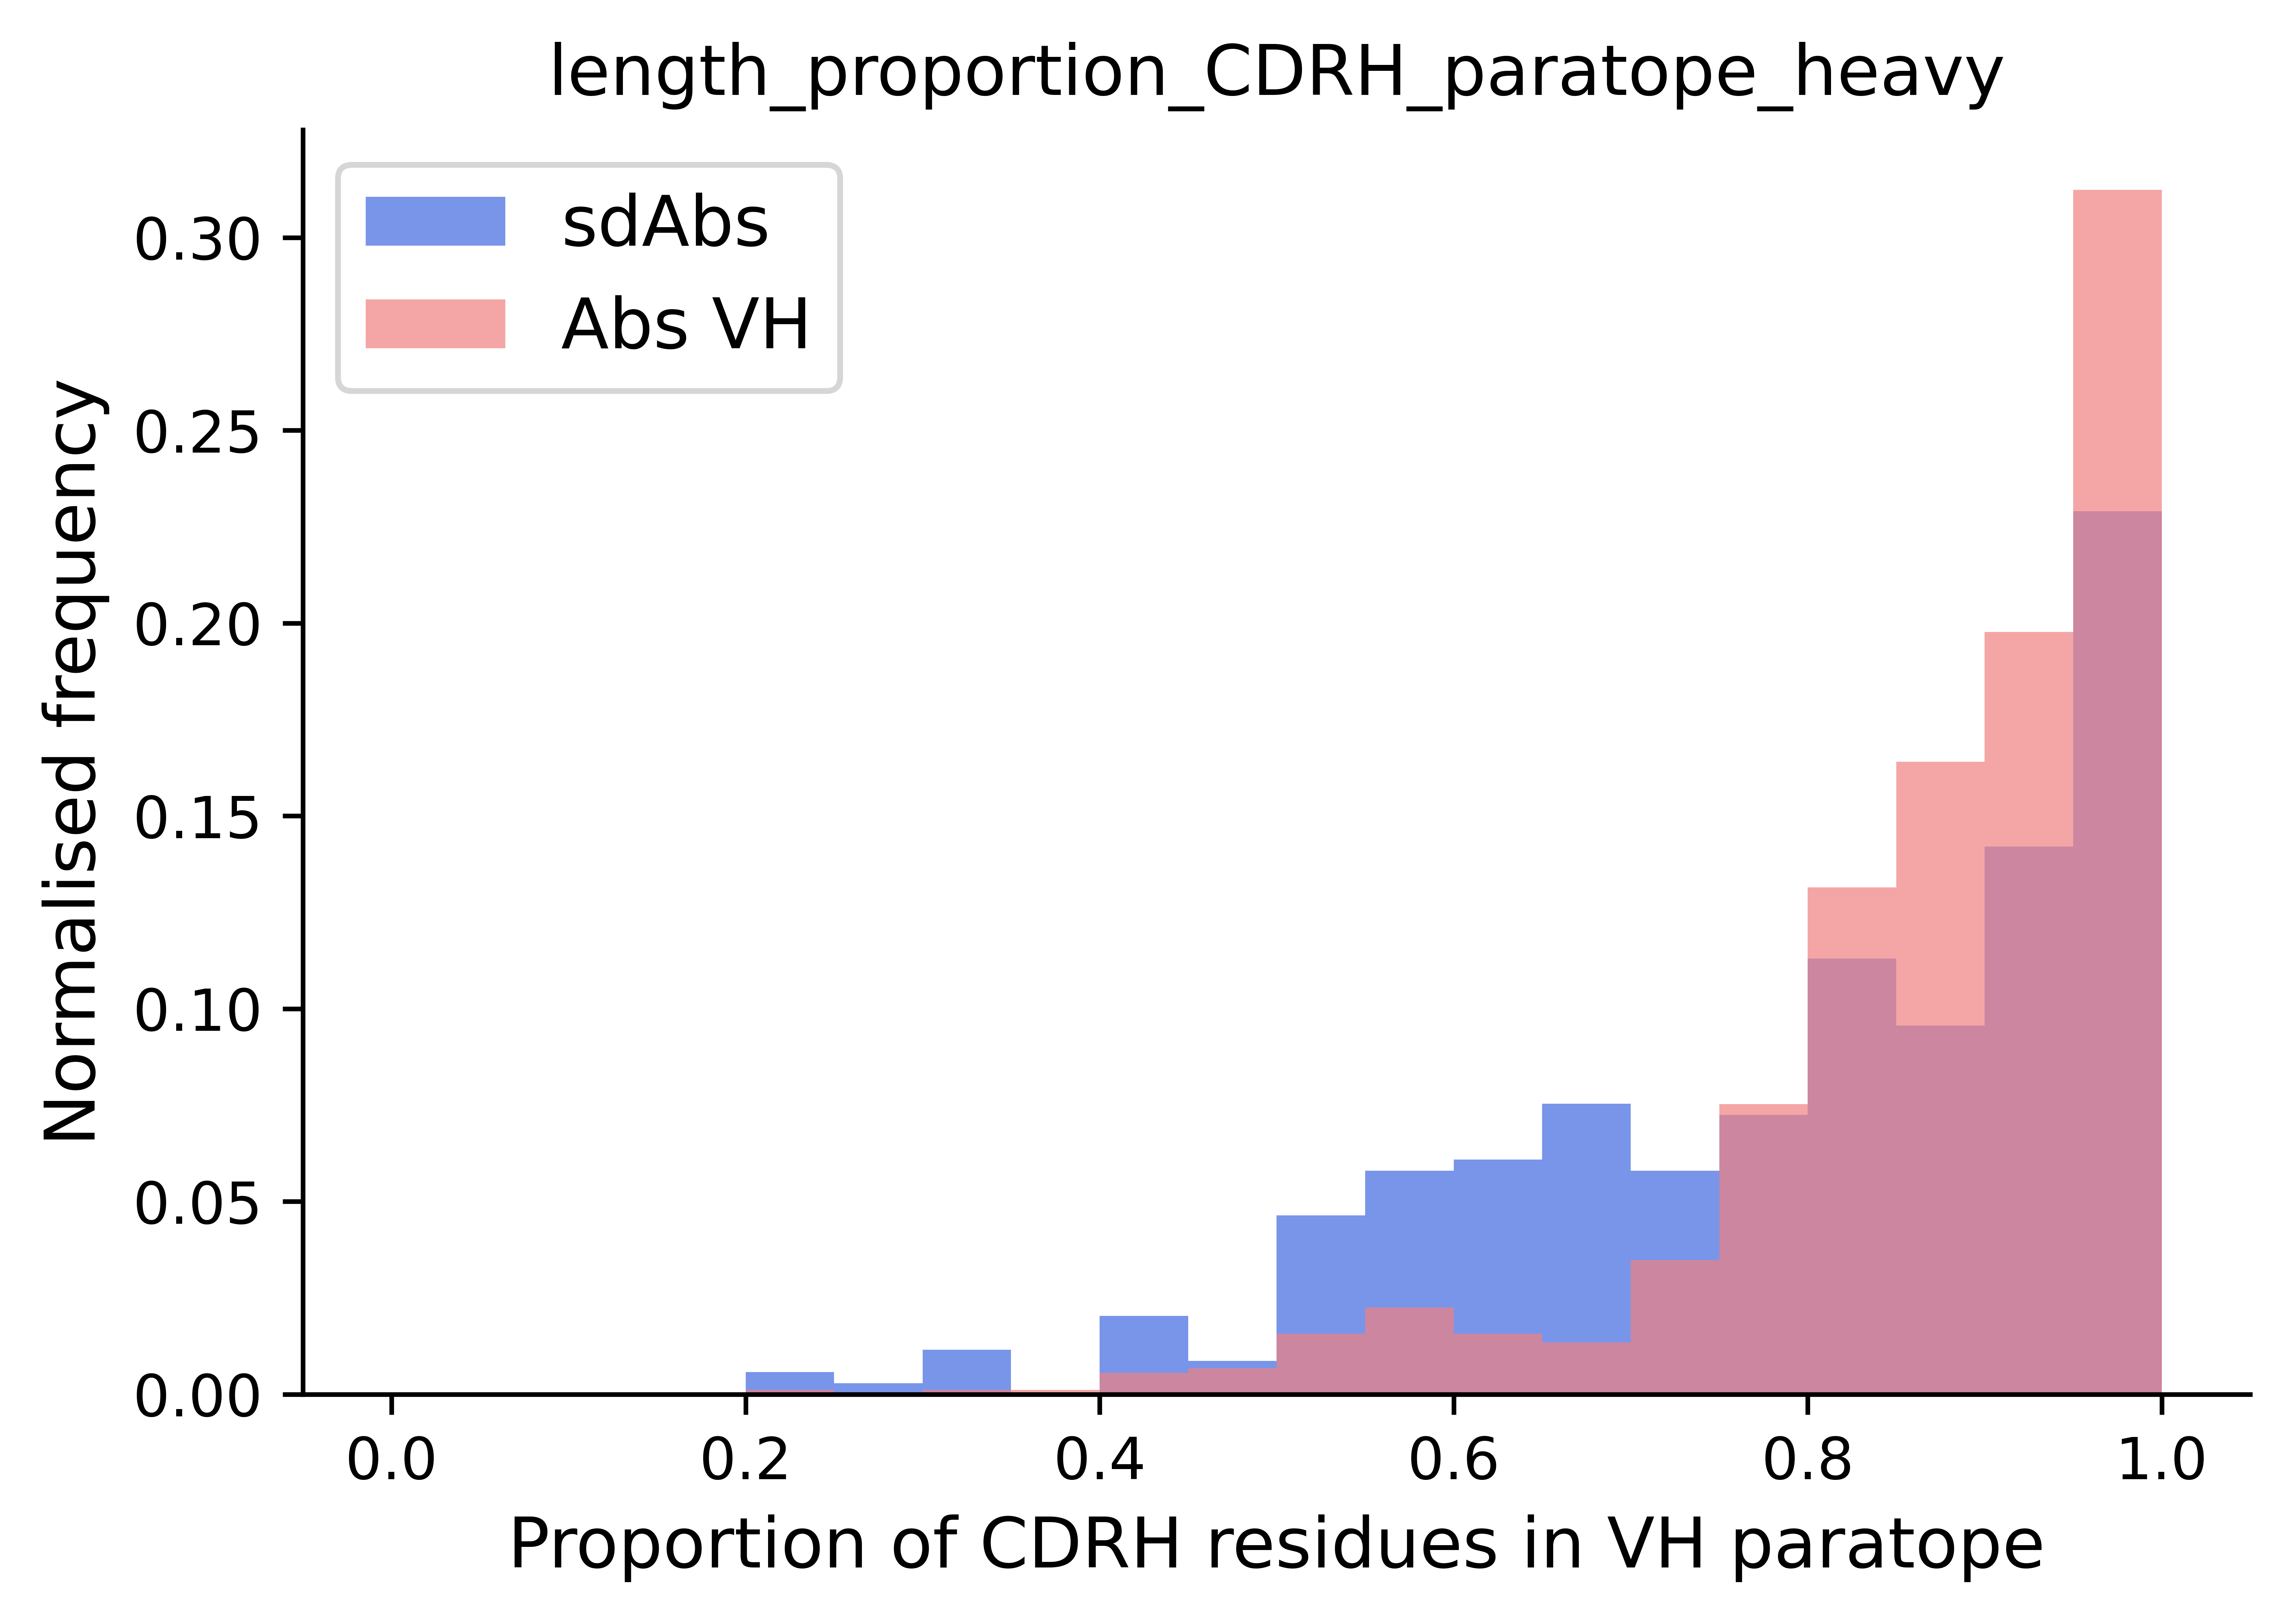

(-6.227357477406282, 4.743679271162058e-10)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:20 2023.

The unpaired mean difference between sdab and flab is 0.0549 [95%CI 0.0326, 0.0781].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


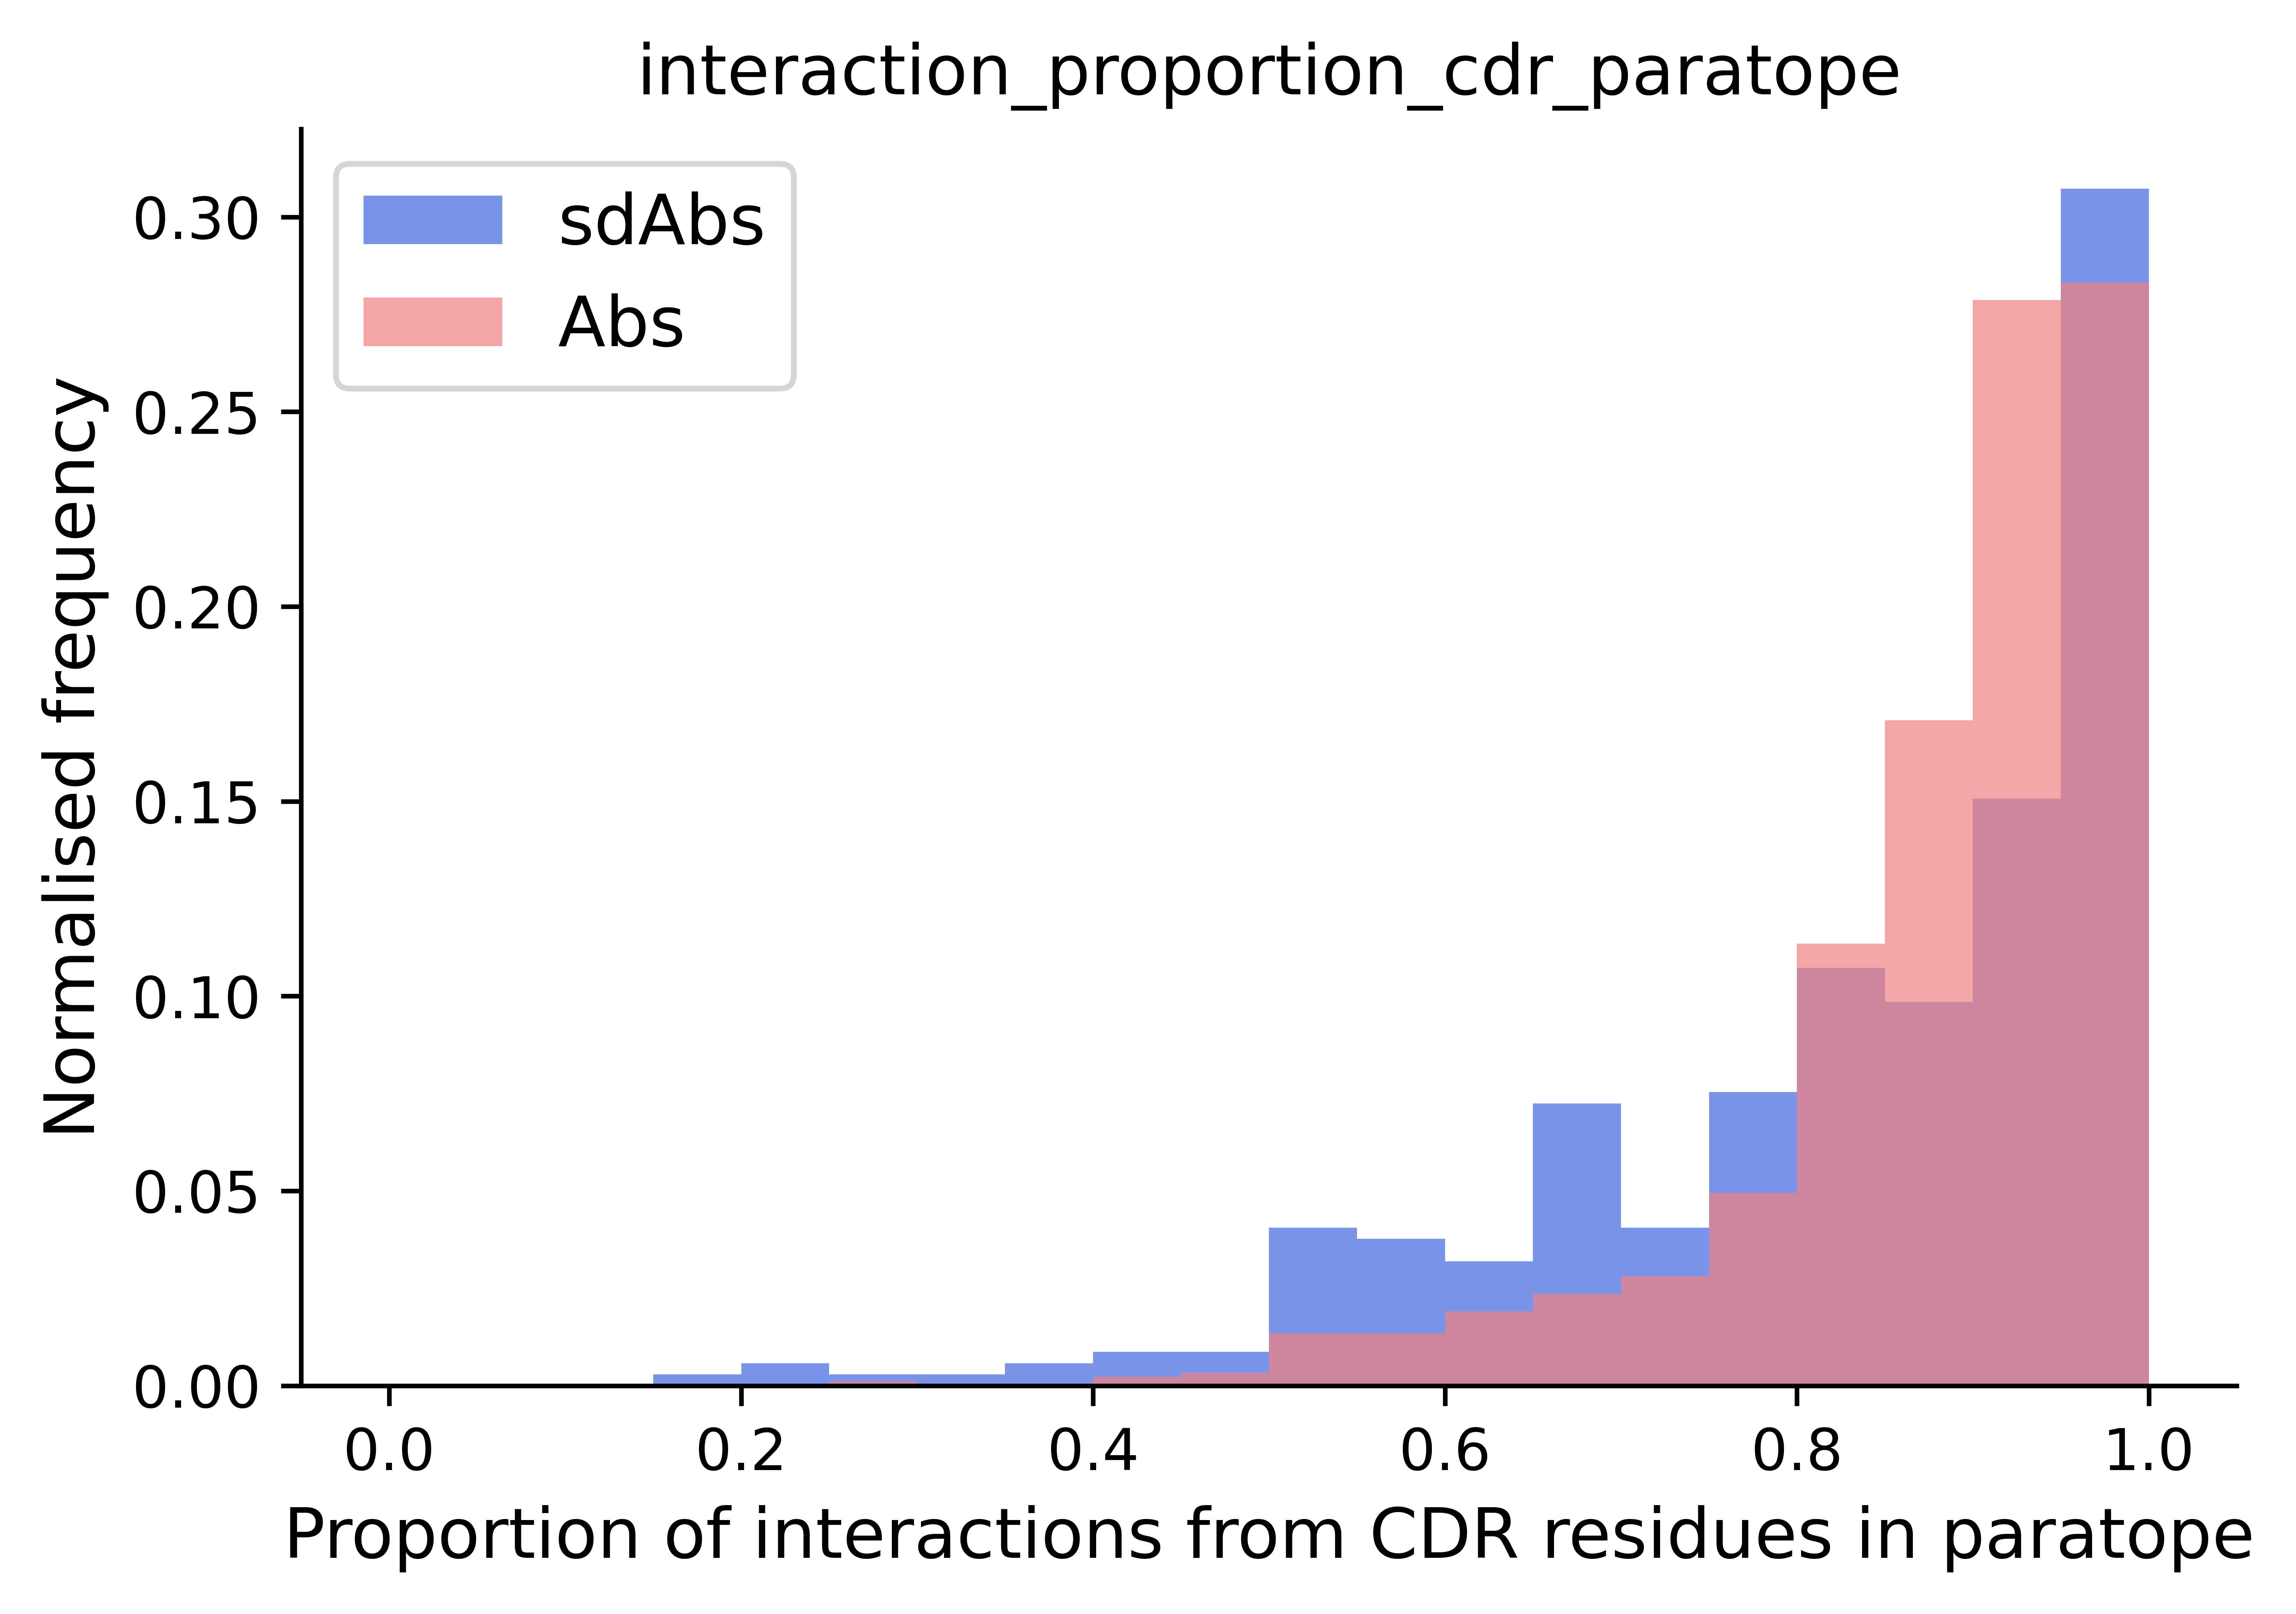

(nan, nan)
DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:54:22 2023.

The unpaired mean difference between sdab and flab is 0.0589 [95%CI 0.0345, 0.0831].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


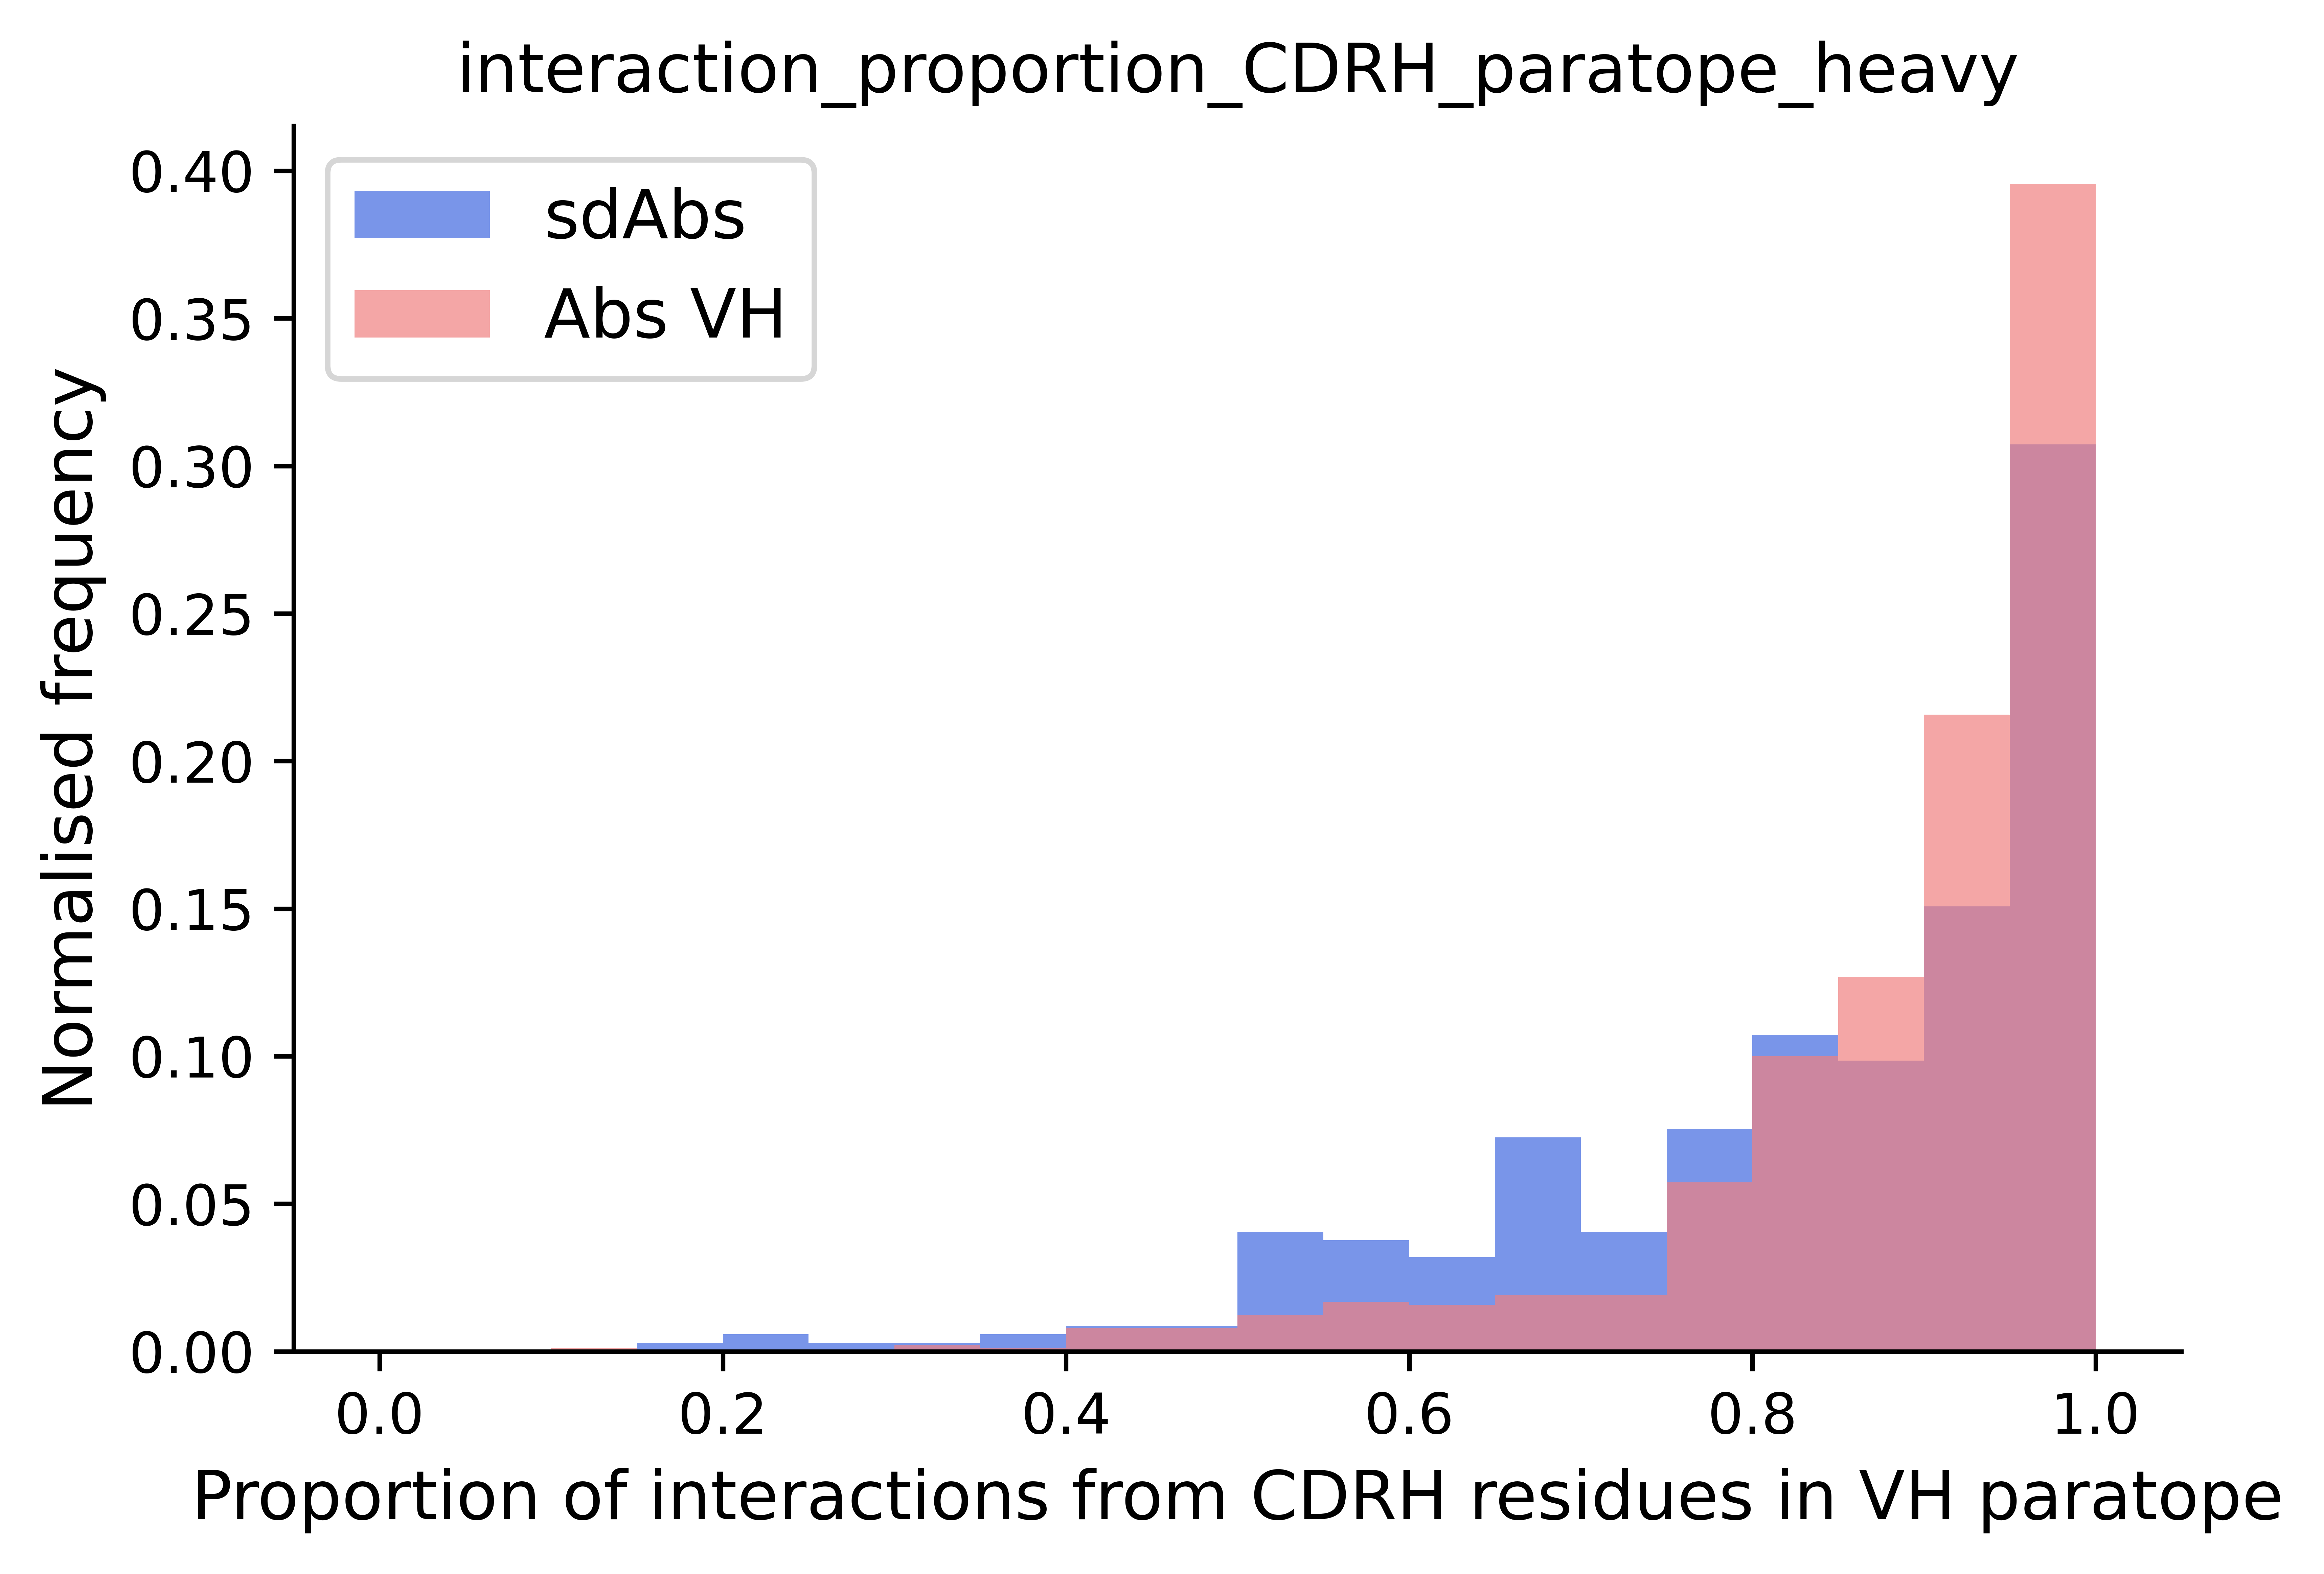

In [11]:
#Compare sd and fl for Arpeggio data
plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "sum_interactions", "sum_interactions", 2.0, "SdAb", "flAb", 'mediumblue', 'red', 'Distribution number of interactions')
plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "sum_interactions", "sum_interactions_heavy", 2.0, "SdAb", "flAb heavy chain", 'mediumblue', 'firebrick', 'Distribution of number interactions in VH')

# plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "normalised_interactions_per_CDRH_length", "normalised_interactions_per_CDRHL_length", 0.1, "SdAb arpeggio", "flAb arpeggio", 'mediumblue', 'red', 'Normalised number of interactions by total CDR length', 'Normalised number of interactions')
# plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "normalised_interactions_per_CDRH_length", "normalised_interactions_per_CDRH_length", 0.1, "SdAb arpeggio", "flAb arpeggio", 'mediumblue', 'red', 'Normalised number of interactions by CDRH length', 'Normalised number of interactions')

plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "normalised_interactions_by_paratope_length", "normalised_interactions_by_paratope_length", 0.1, "sdAbs", "Abs", 'royalblue', 'lightcoral', 'Normalised number of interactions by paratope size', 'Normalised number of interactions per residue')
plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "normalised_interactions_by_paratope_length", "normalised_interactions_by_paratope_length_heavy", 0.1, "SdAb", "flAb", 'mediumblue', 'firebrick', 'Normalised number of interactions by paratope length heavy chain', 'Normalised number of interactions')

plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "normalised_interactions_by_epitope_length", "normalised_interactions_by_epitope_length", 0.1, "sdAb", "flAb", 'mediumblue', 'red', 'normalised_interactions_by_epitope_length', 'Normalised number of interactions')

# NOTE change format below for paper
plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "length_proportion_all_cdrs_in_paratope", "length_proportion_all_cdrs_in_paratope", 0.05, "sdAbs", "Abs", 'royalblue', 'lightcoral', 'length_proportion_cdr_paratope', 'Proportion of CDR residues in paratope', grid = False)
plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "length_proportion_all_cdrs_in_paratope", "length_proportion_cdrhs_in_paratope_heavy", 0.05, "sdAbs", "Abs VH", 'royalblue', 'lightcoral', 'length_proportion_CDRH_paratope_heavy', 'Proportion of CDRH residues in VH paratope', grid = False)

plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "interaction_proportion_all_cdrs_in_paratope", "interaction_proportion_all_cdrs_in_paratope", 0.05, "sdAbs", "Abs", 'royalblue', 'lightcoral', 'interaction_proportion_cdr_paratope', 'Proportion of interactions from CDR residues in paratope', grid = False)
plot_distribution(df_summary_arpeggio_nb, df_summary_arpeggio_fv, "interaction_proportion_all_cdrs_in_paratope", "interaction_proportion_cdrhs_in_paratope_heavy", 0.05, "sdAbs", "Abs VH", 'royalblue', 'lightcoral', 'interaction_proportion_CDRH_paratope_heavy', 'Proportion of interactions from CDRH residues in VH paratope', grid = False)

#### EDIT BELOW 2 PLOTS FOR PAPER

(13.858240555332653, 1.1342040264676338e-43)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon May 22 17:17:53 2023.

The unpaired mean difference between sdab and flab is -4.78 [95%CI -5.69, -3.79].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


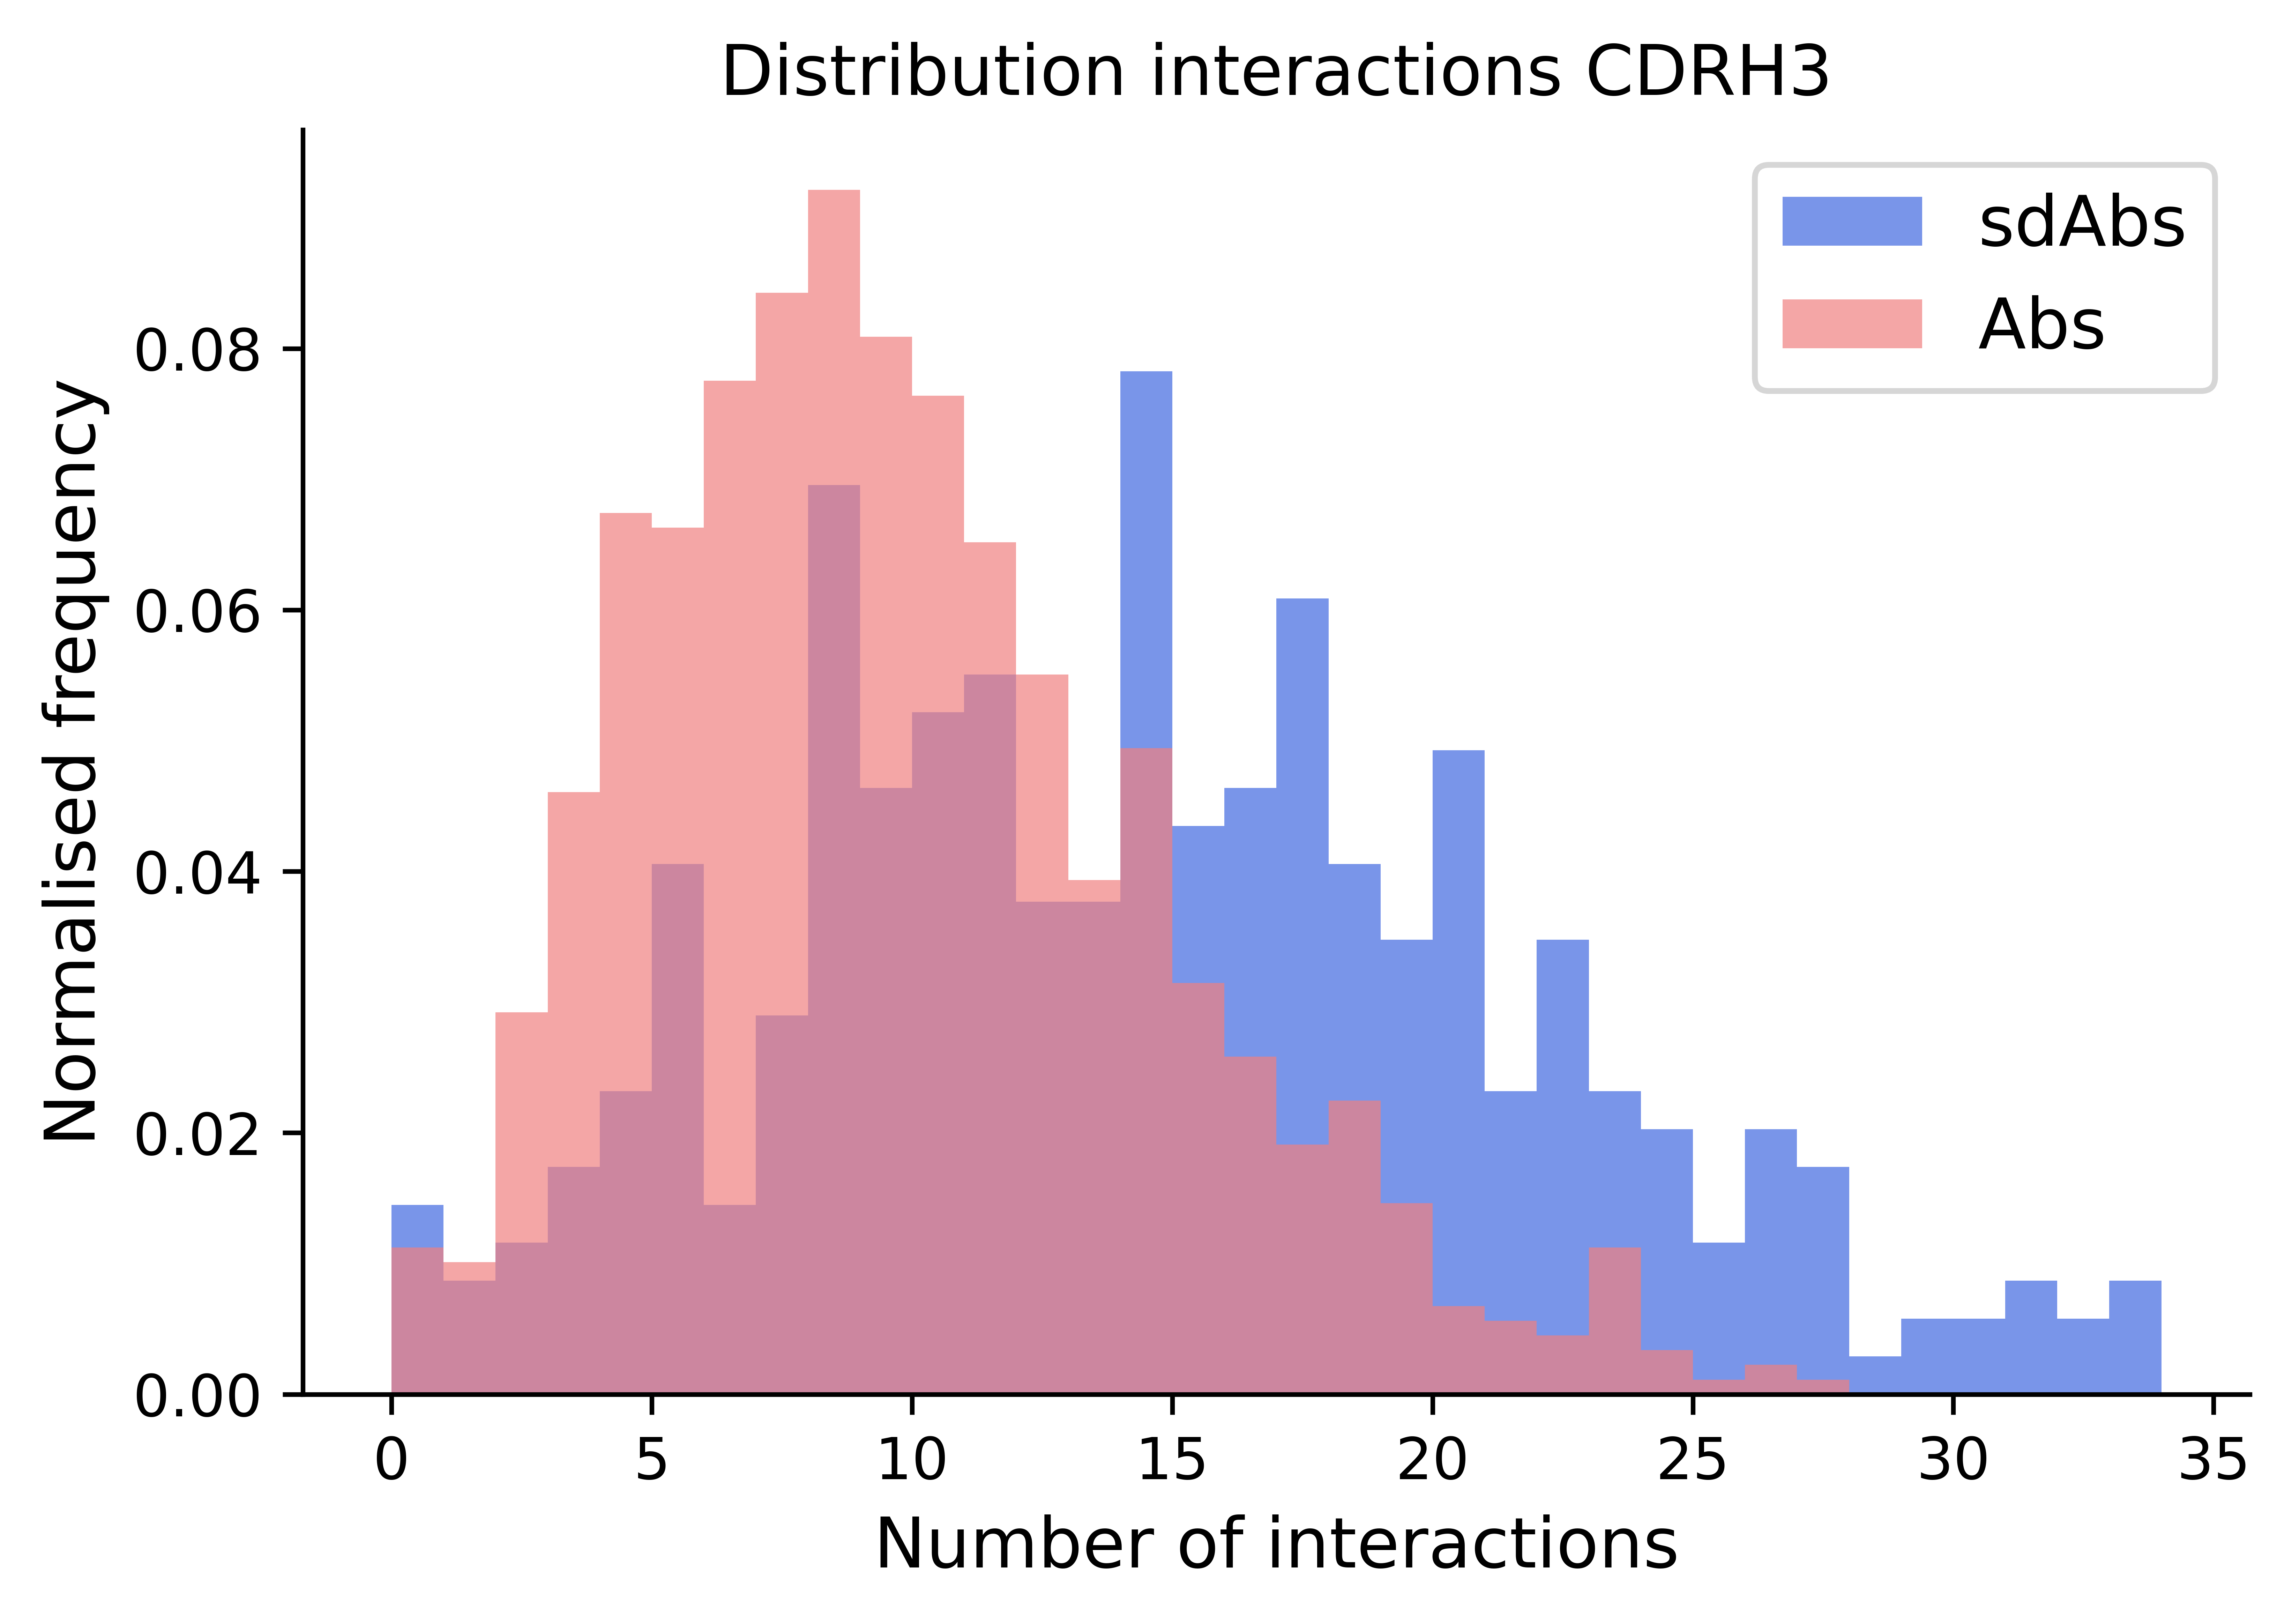

(12.543755650175939, 4.3011766543709735e-36)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon May 22 17:17:59 2023.

The unpaired mean difference between sdab and flab is -0.281 [95%CI -0.344, -0.22].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


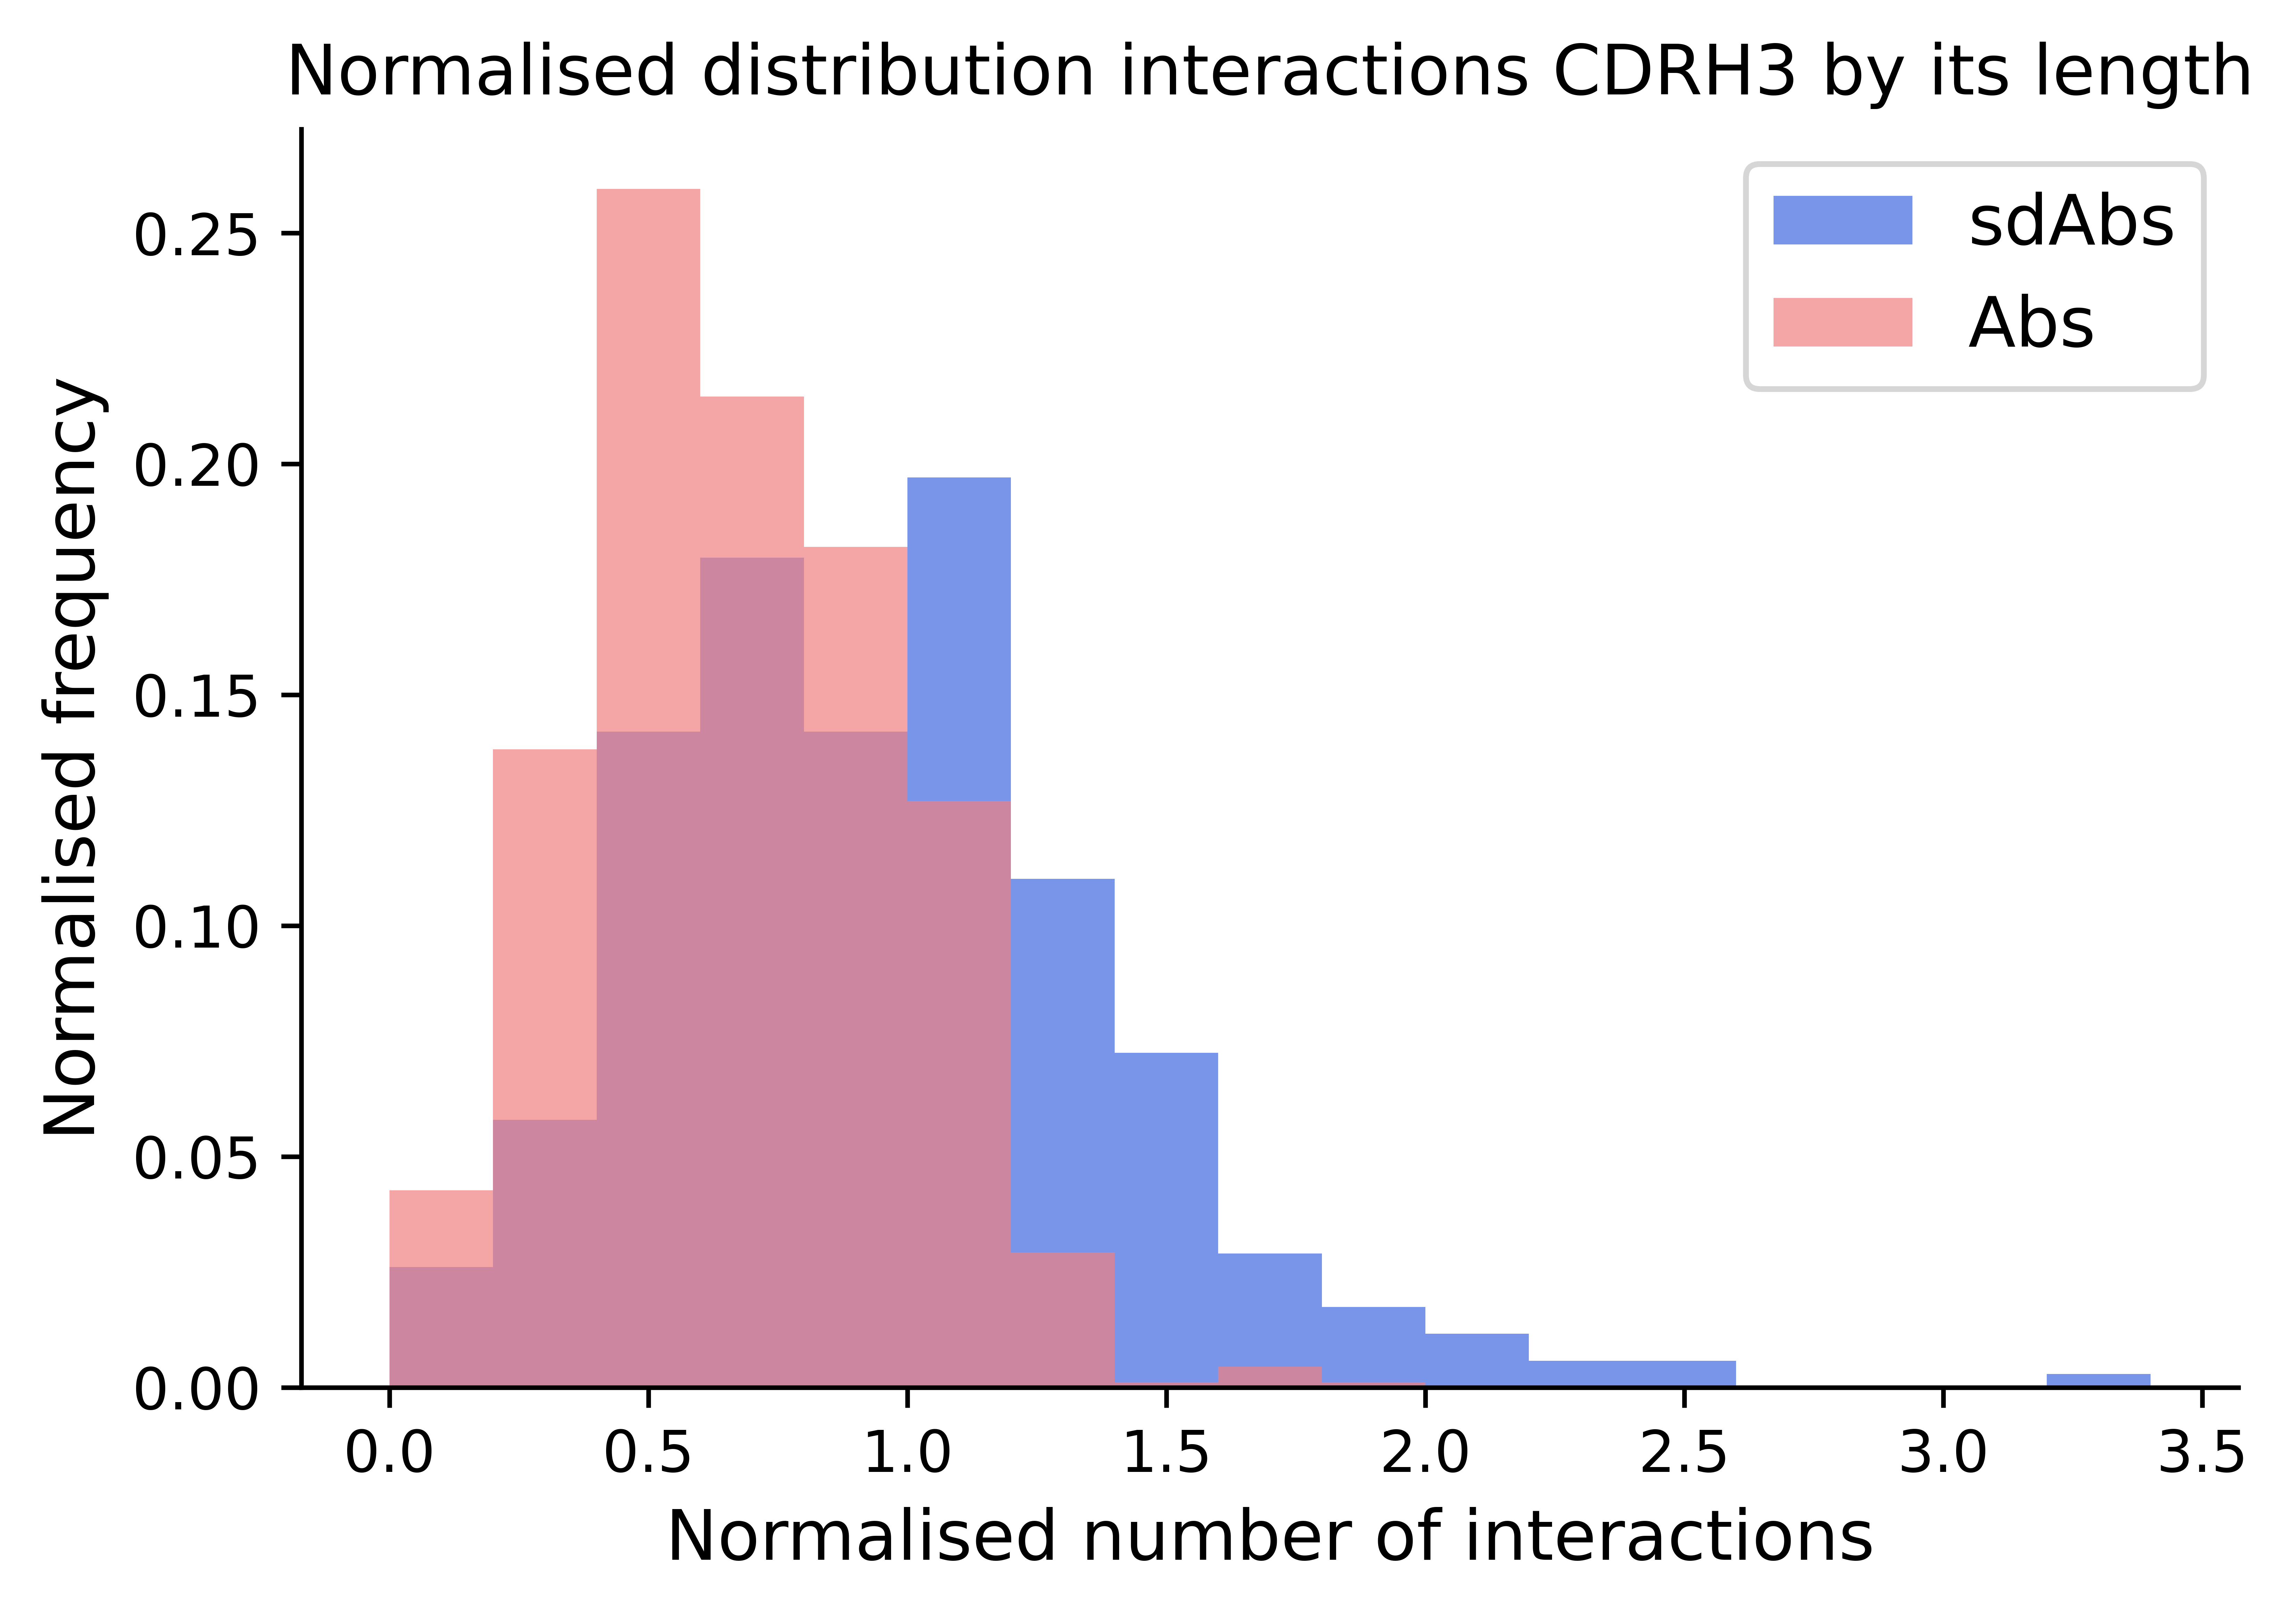

(nan, nan)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon May 22 17:18:05 2023.

The unpaired mean difference between sdab and flab is -0.0343 [95%CI -0.0687, -0.000574].
The p-value of the two-sided permutation t-test is 0.0456. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


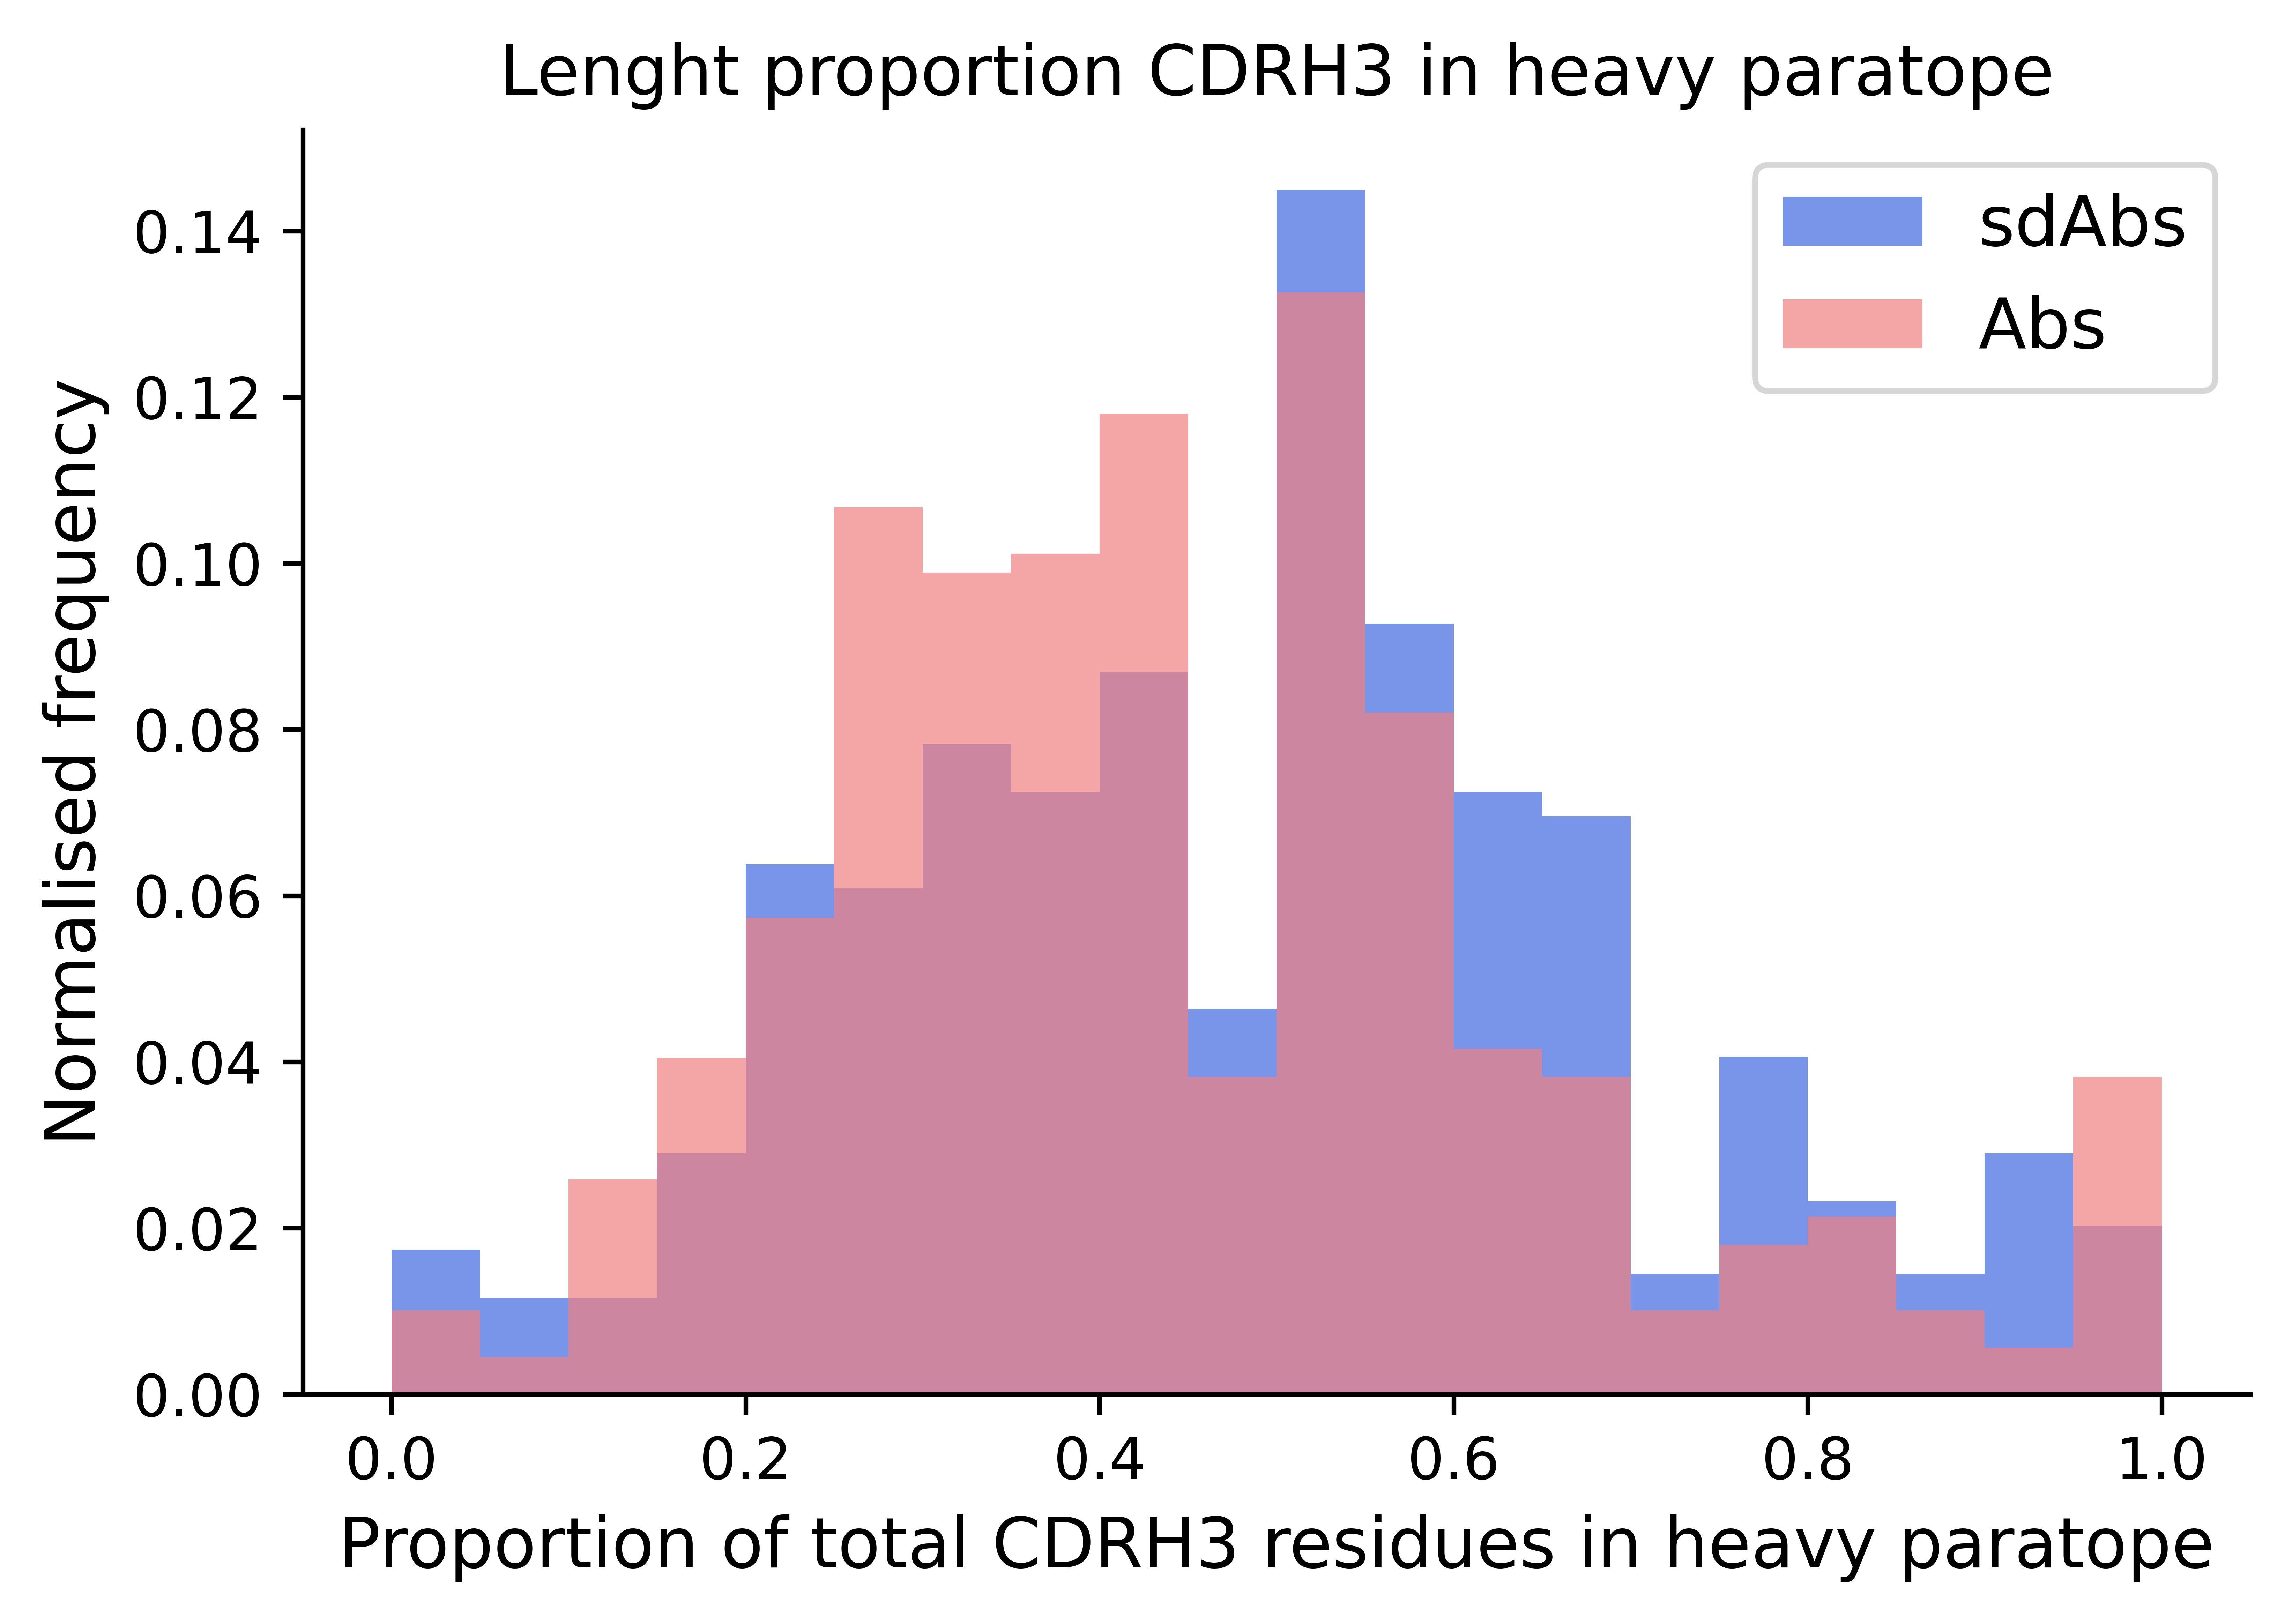

(19.510889237155926, 8.872525907871924e-85)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon May 22 17:18:10 2023.

The unpaired mean difference between sdab and flab is -0.207 [95%CI -0.235, -0.179].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


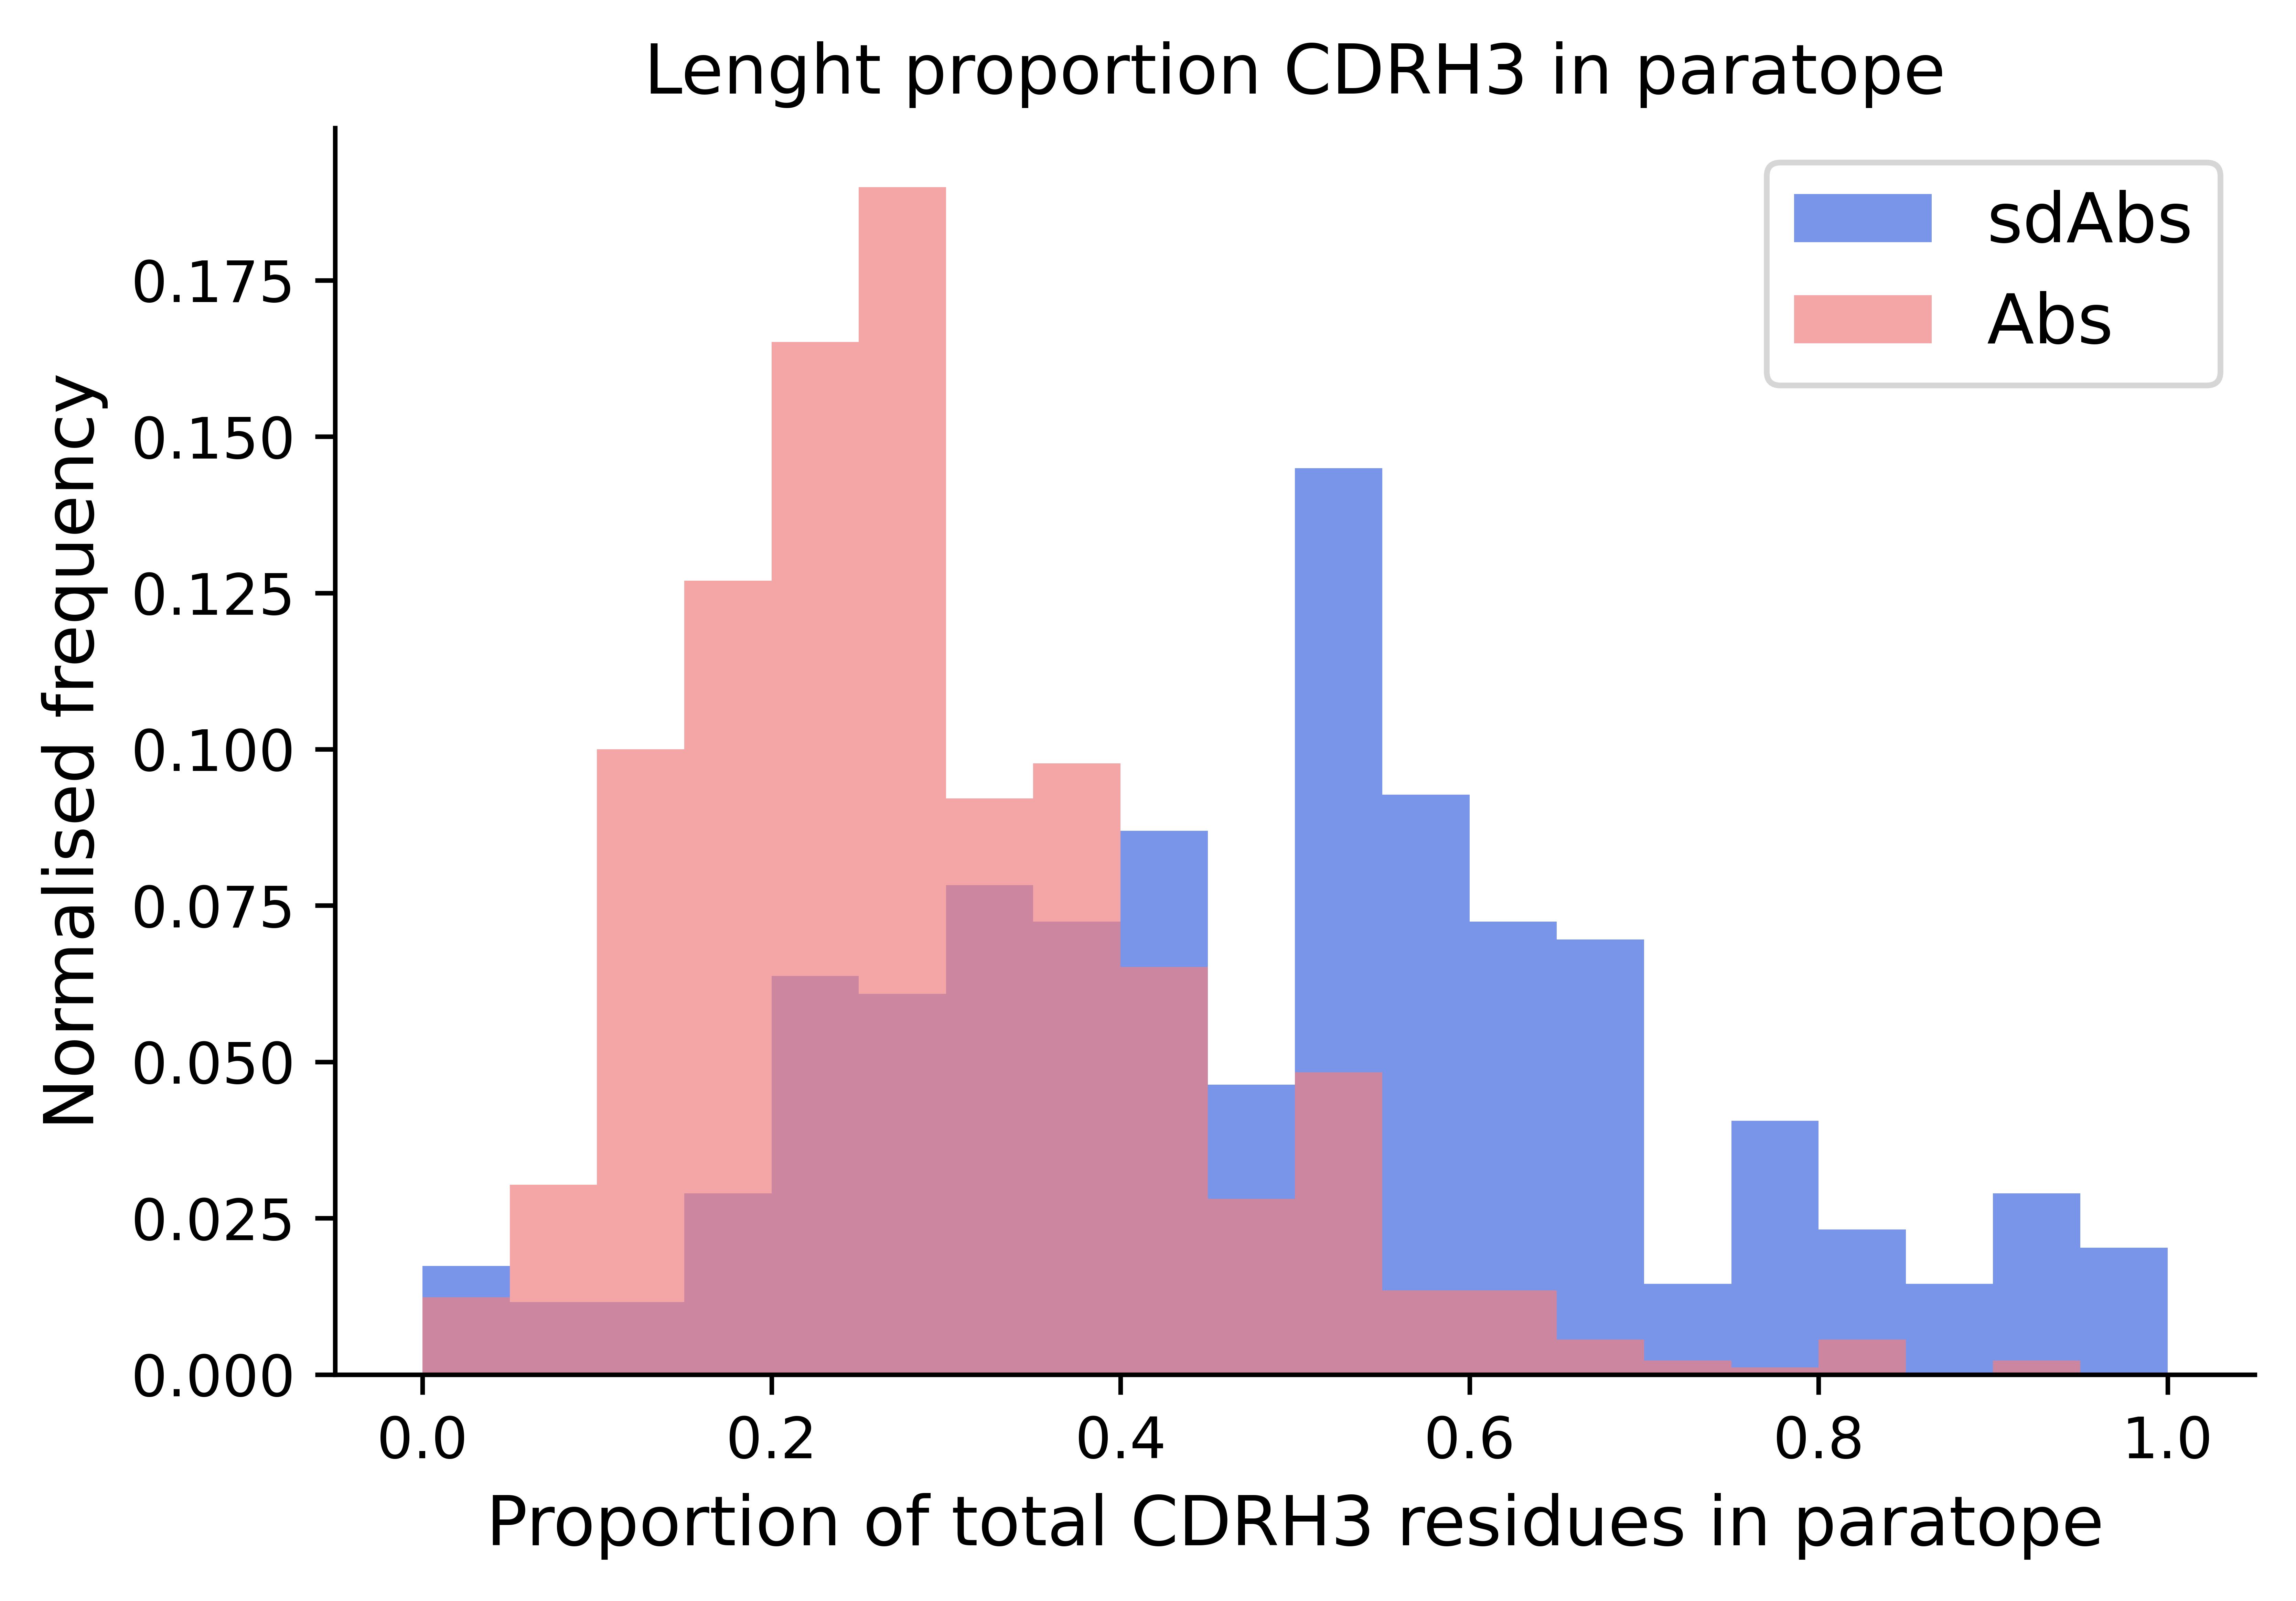

(nan, nan)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon May 22 17:18:17 2023.

The unpaired mean difference between sdab and flab is -0.0397 [95%CI -0.0767, -0.00159].
The p-value of the two-sided permutation t-test is 0.04. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


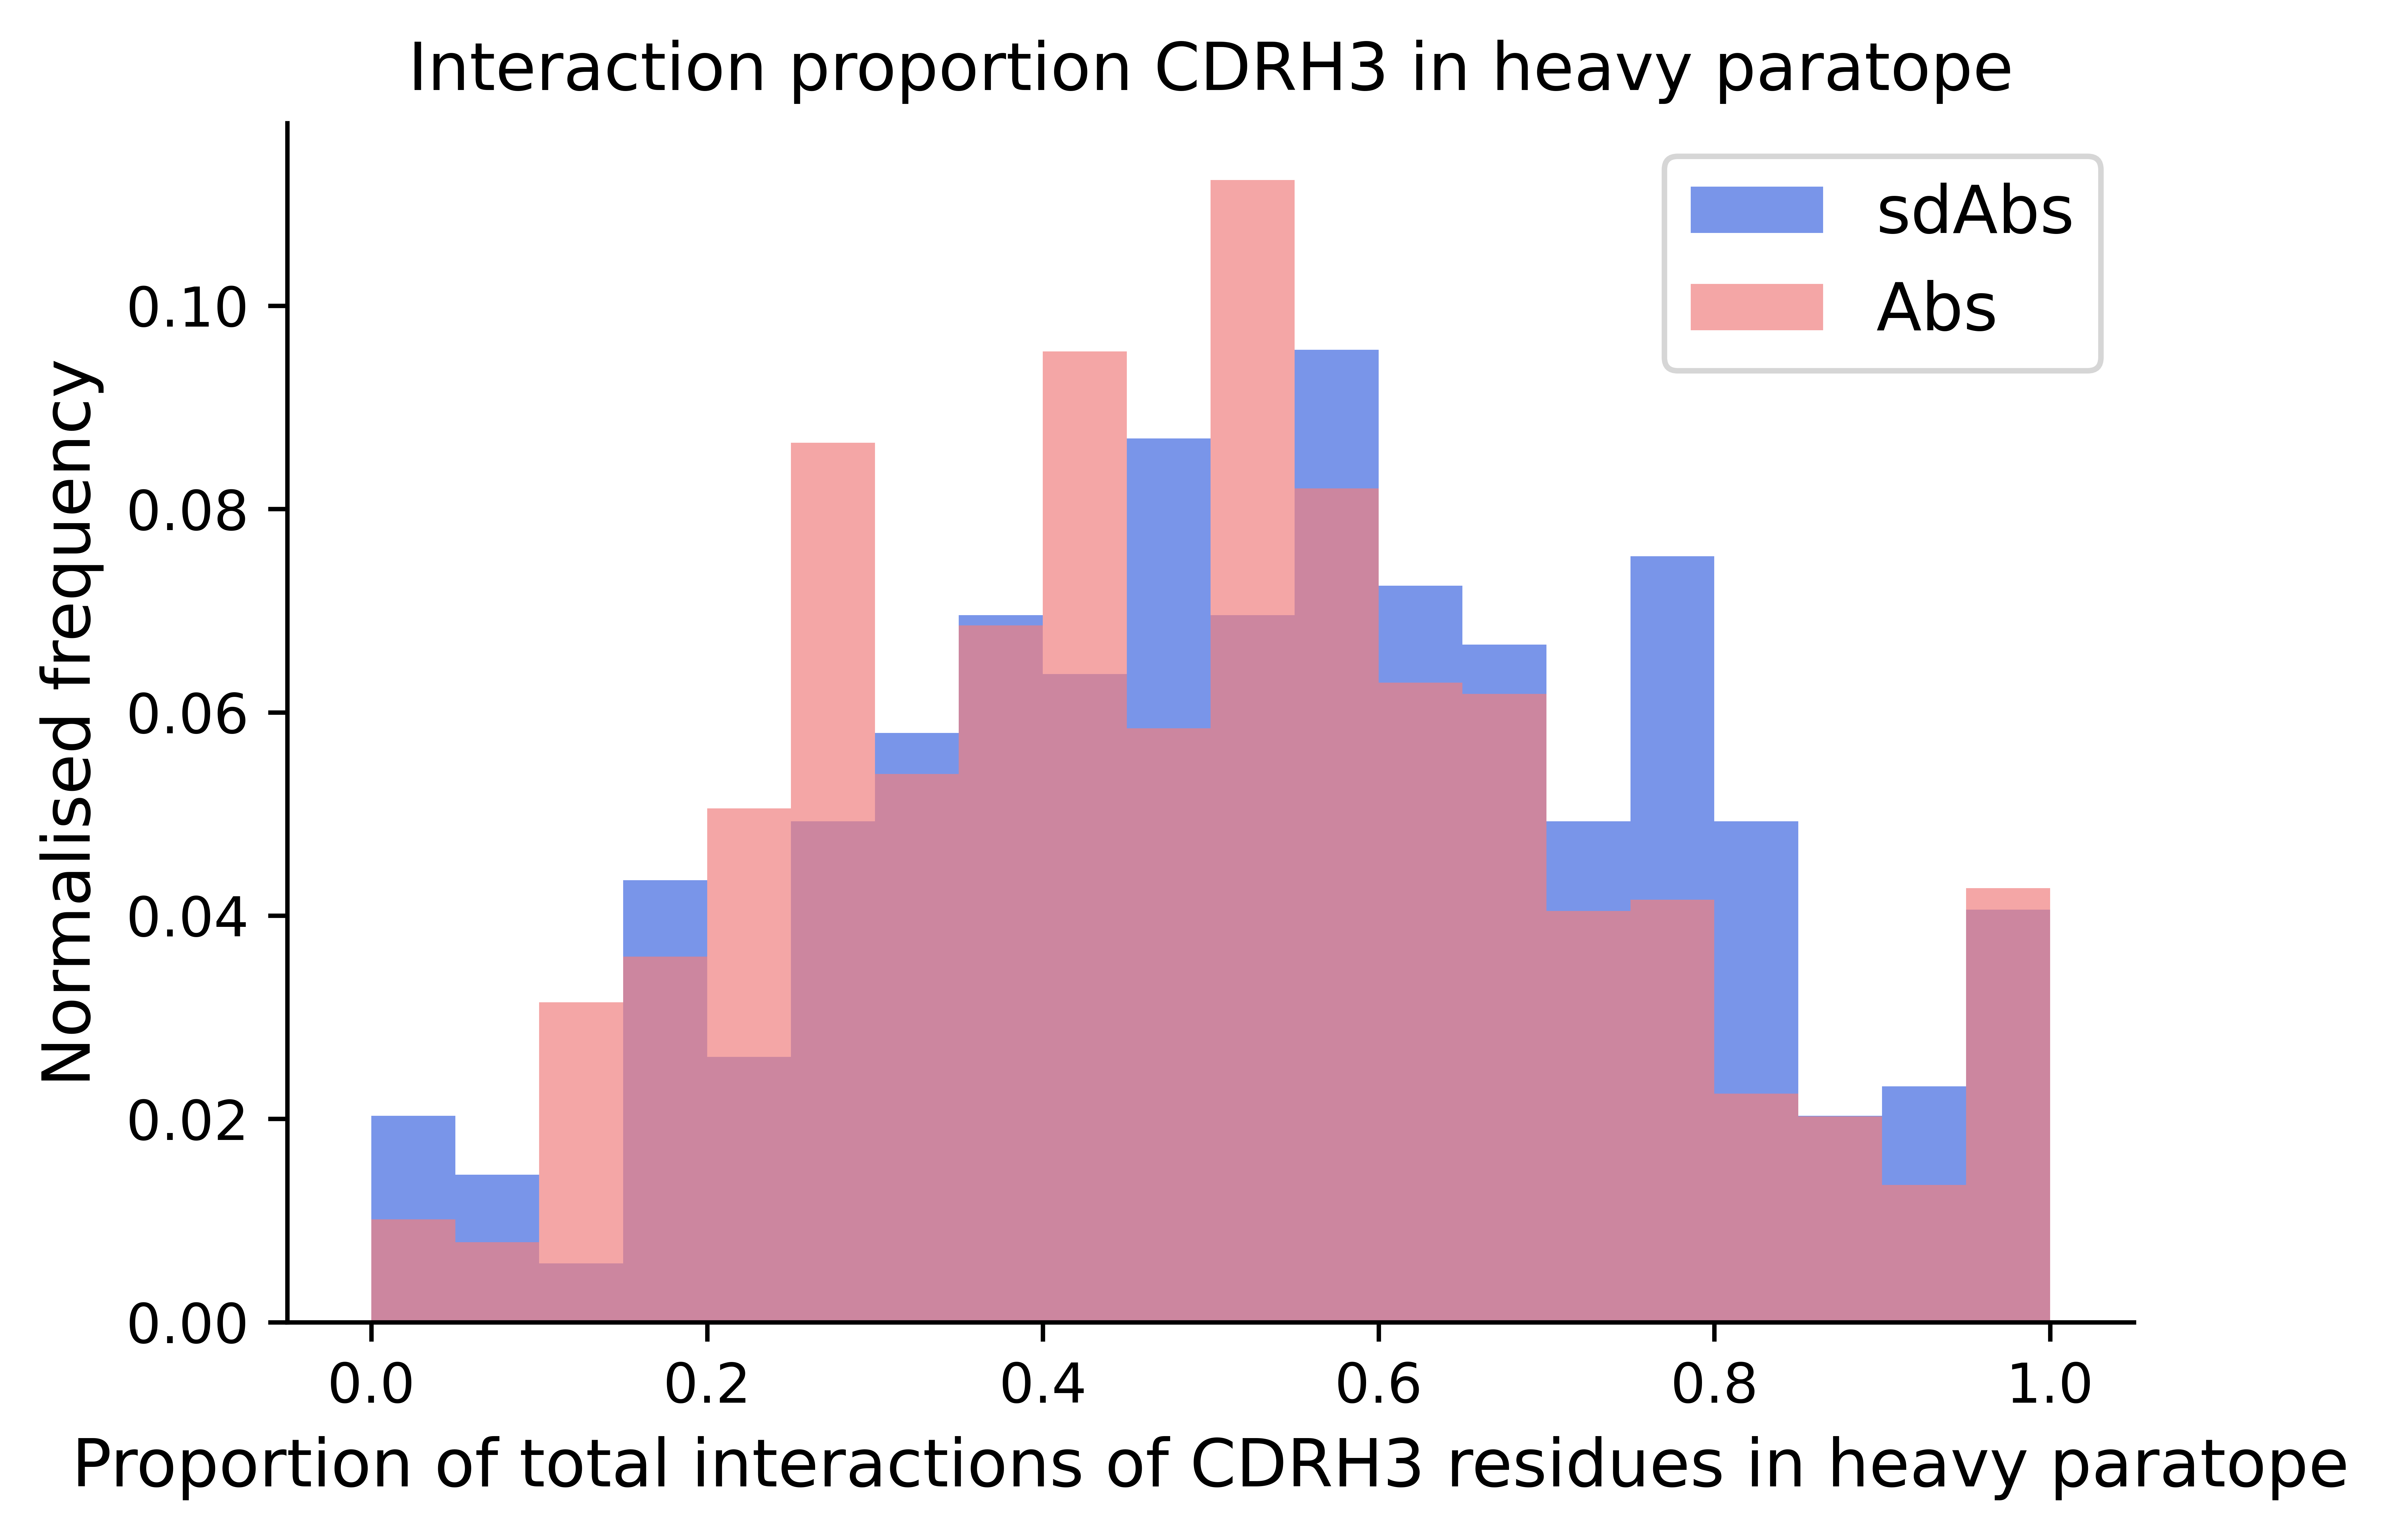

(17.160714545964563, 5.22666205182443e-66)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon May 22 17:18:21 2023.

The unpaired mean difference between sdab and flab is -0.189 [95%CI -0.222, -0.157].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


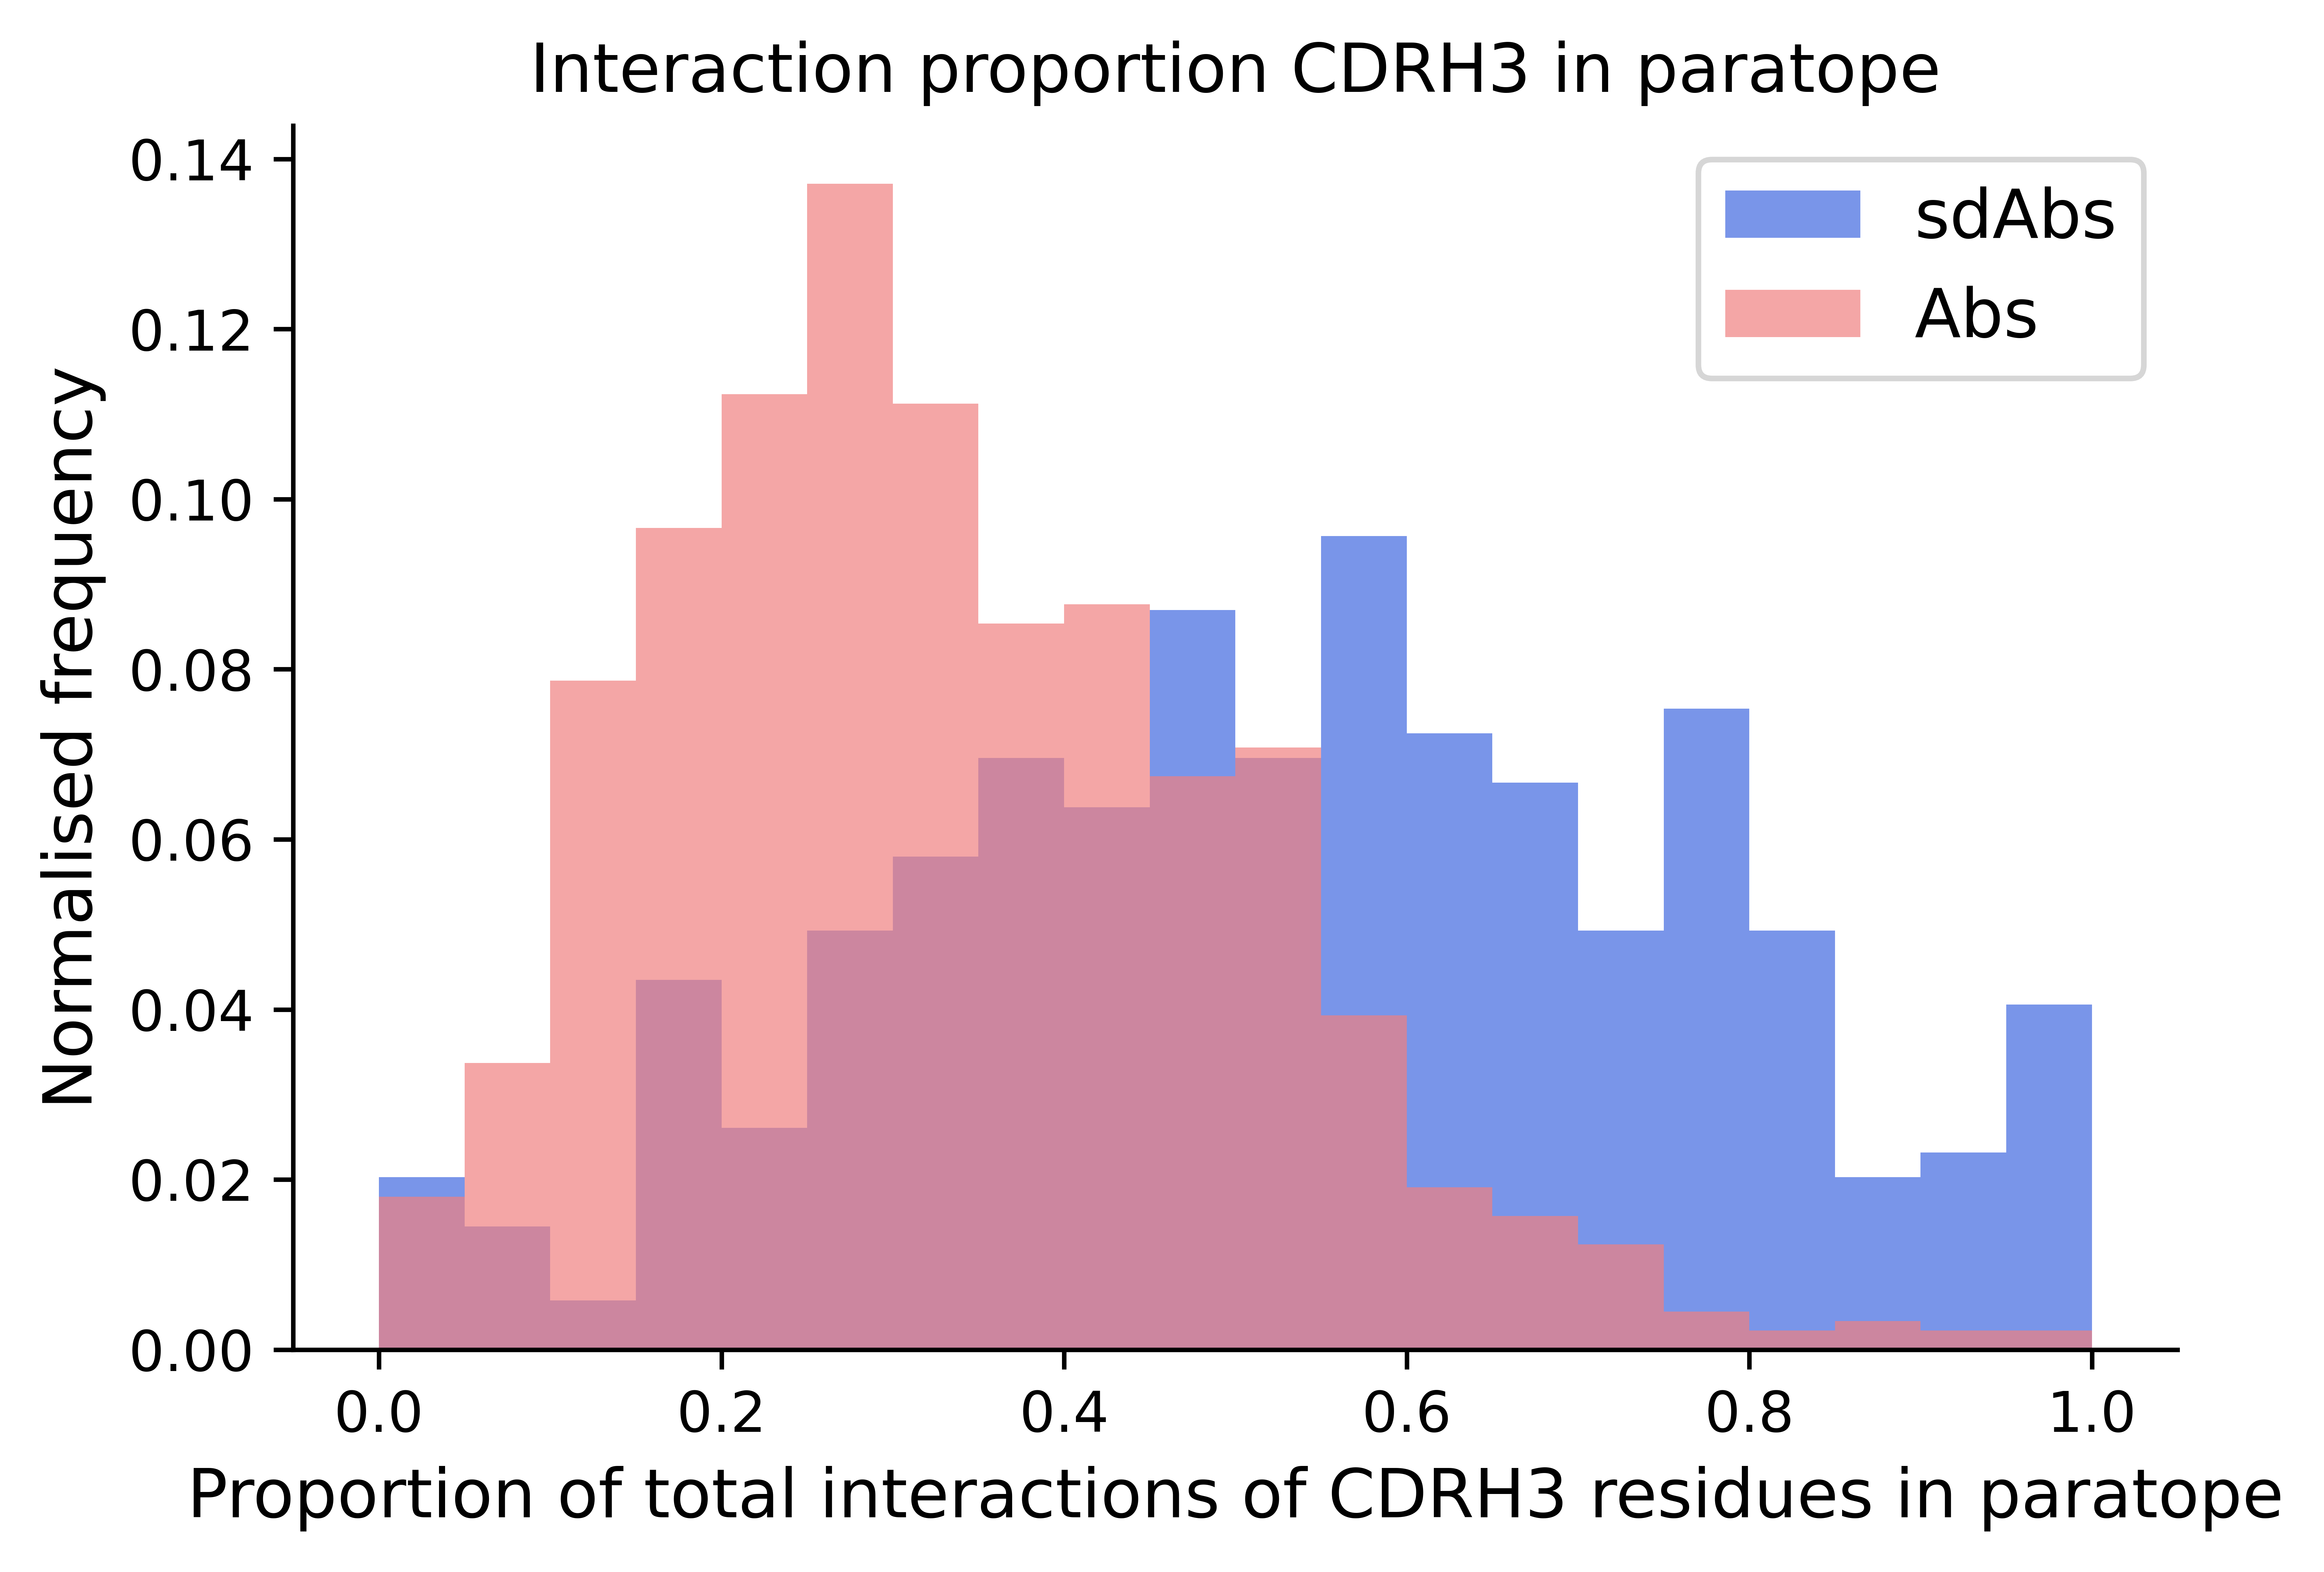

In [12]:
#Study per CDR type
cdr_type = "CDRH3"
df_all_info_arp_nb, df_all_arp_fv = evaluate_distributions_per_cdr(df_summary_arpeggio_nb, df_summary_arpeggio_fv, dict_cdr_positions, cdr_type, "sdAbs", "Abs", 'royalblue', 'lightcoral')


(-4.349074089156803, 1.3671352259564939e-05)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:46:54 2022.

The unpaired mean difference between sdab and flab is 0.887 [95%CI 0.313, 1.46].
The p-value of the two-sided permutation t-test is 0.0032. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


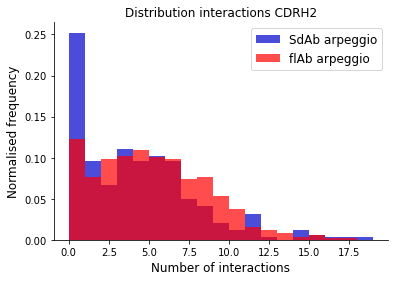

(-4.2089597577393505, 2.565490710591924e-05)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:46:55 2022.

The unpaired mean difference between sdab and flab is 0.109 [95%CI 0.0354, 0.181].
The p-value of the two-sided permutation t-test is 0.0026. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


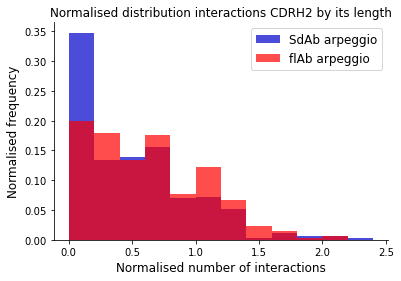

(nan, nan)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:46:57 2022.

The unpaired mean difference between sdab and flab is 0.0795 [95%CI 0.058, 0.101].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


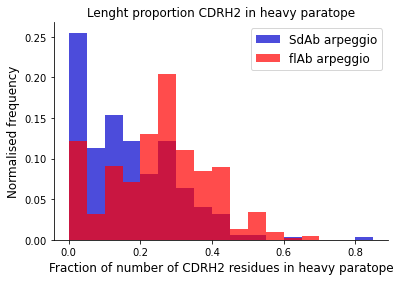

(-0.8274429916636464, 0.40798602157994746)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:46:58 2022.

The unpaired mean difference between sdab and flab is 0.00818 [95%CI -0.0107, 0.0264].
The p-value of the two-sided permutation t-test is 0.392. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


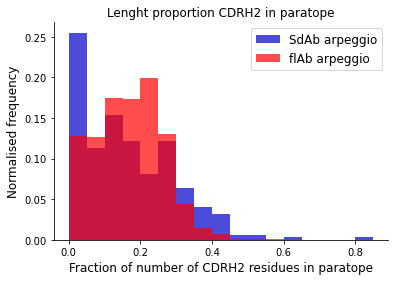

(nan, nan)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:46:59 2022.

The unpaired mean difference between sdab and flab is 0.0879 [95%CI 0.064, 0.11].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


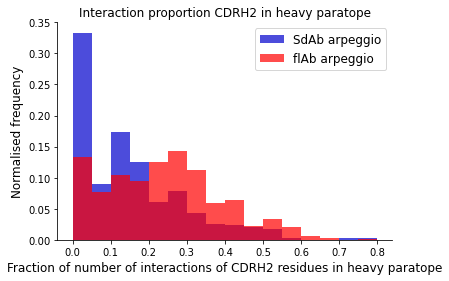

(-1.913705310280067, 0.05565782016317119)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:00 2022.

The unpaired mean difference between sdab and flab is 0.0111 [95%CI -0.00955, 0.0307].
The p-value of the two-sided permutation t-test is 0.275. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


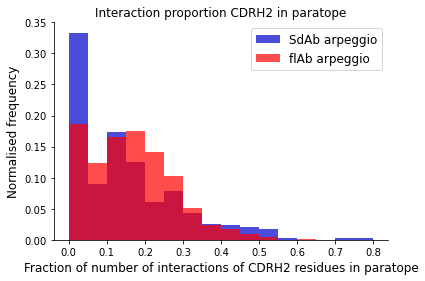

In [67]:
#Study per CDR type
cdr_type = "CDRH2"
df_all_info_arp_nb, df_all_arp_fv = evaluate_distributions_per_cdr(df_summary_arpeggio_nb, df_summary_arpeggio_fv, dict_cdr_positions, cdr_type, "SdAb arpeggio", "flAb arpeggio", 'mediumblue', 'red')


(3.160226799841674, 0.0015764637185961732)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:01 2022.

The unpaired mean difference between sdab and flab is -0.43 [95%CI -1.0, 0.12].
The p-value of the two-sided permutation t-test is 0.132. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


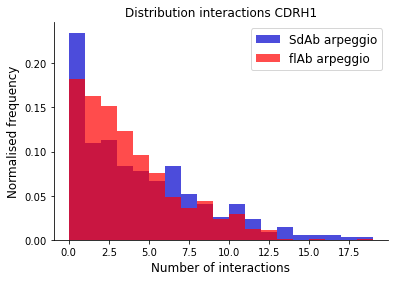

(3.496684801187285, 0.0004710780802622676)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:02 2022.

The unpaired mean difference between sdab and flab is -0.0855 [95%CI -0.16, -0.0126].
The p-value of the two-sided permutation t-test is 0.0144. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


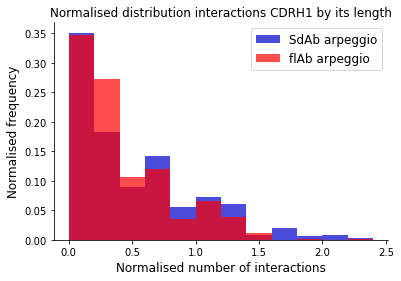

(nan, nan)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:03 2022.

The unpaired mean difference between sdab and flab is 0.0265 [95%CI 0.00612, 0.0476].
The p-value of the two-sided permutation t-test is 0.0104. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


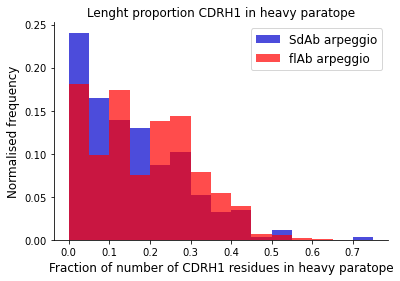

(4.8234329894345676, 1.4110818838169622e-06)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:04 2022.

The unpaired mean difference between sdab and flab is -0.034 [95%CI -0.0523, -0.016].
The p-value of the two-sided permutation t-test is 0.0004. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


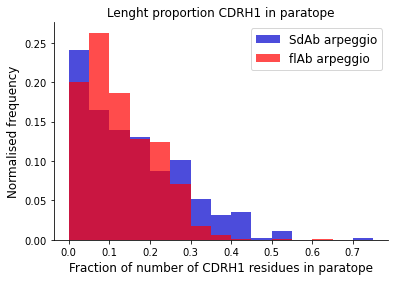

(nan, nan)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:05 2022.

The unpaired mean difference between sdab and flab is 0.0235 [95%CI 0.00207, 0.0463].
The p-value of the two-sided permutation t-test is 0.0312. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


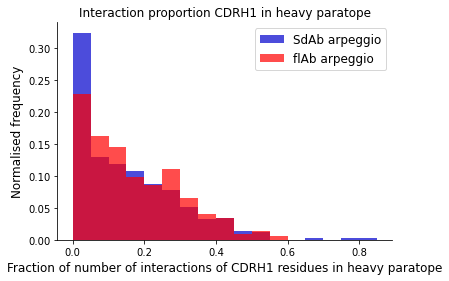

(5.2498664283928065, 1.5220953830976493e-07)
DABEST v0.3.1
             
Good morning!
The current time is Fri Dec 16 10:47:07 2022.

The unpaired mean difference between sdab and flab is -0.0306 [95%CI -0.0515, -0.0109].
The p-value of the two-sided permutation t-test is 0.0014. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


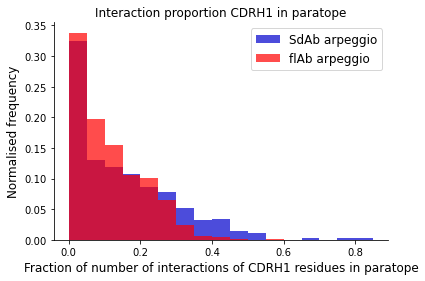

In [68]:
#Study per CDR type
cdr_type = "CDRH1"
df_all_info_arp_nb, df_all_arp_fv = evaluate_distributions_per_cdr(df_summary_arpeggio_nb, df_summary_arpeggio_fv, dict_cdr_positions, cdr_type, "SdAb arpeggio", "flAb arpeggio", 'mediumblue', 'red')
